## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

#### Find corners of the calibration images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create the test_images_output directory.
if not os.path.exists("drawn_chessboards_corners_output"):
    os.makedirs("drawn_chessboards_corners_output")

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        drawn_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Extract filename from path 
        # (See https://stackoverflow.com/questions/8384737/extract-file-name-from-path-no-matter-what-the-os-path-format)
        head, tail = os.path.split(fname)
        # Save the drawn images to a folder to visualize the result
        mpimg.imsave("drawn_chessboards_corners_output/" + tail, img)

#### Correct for distortion

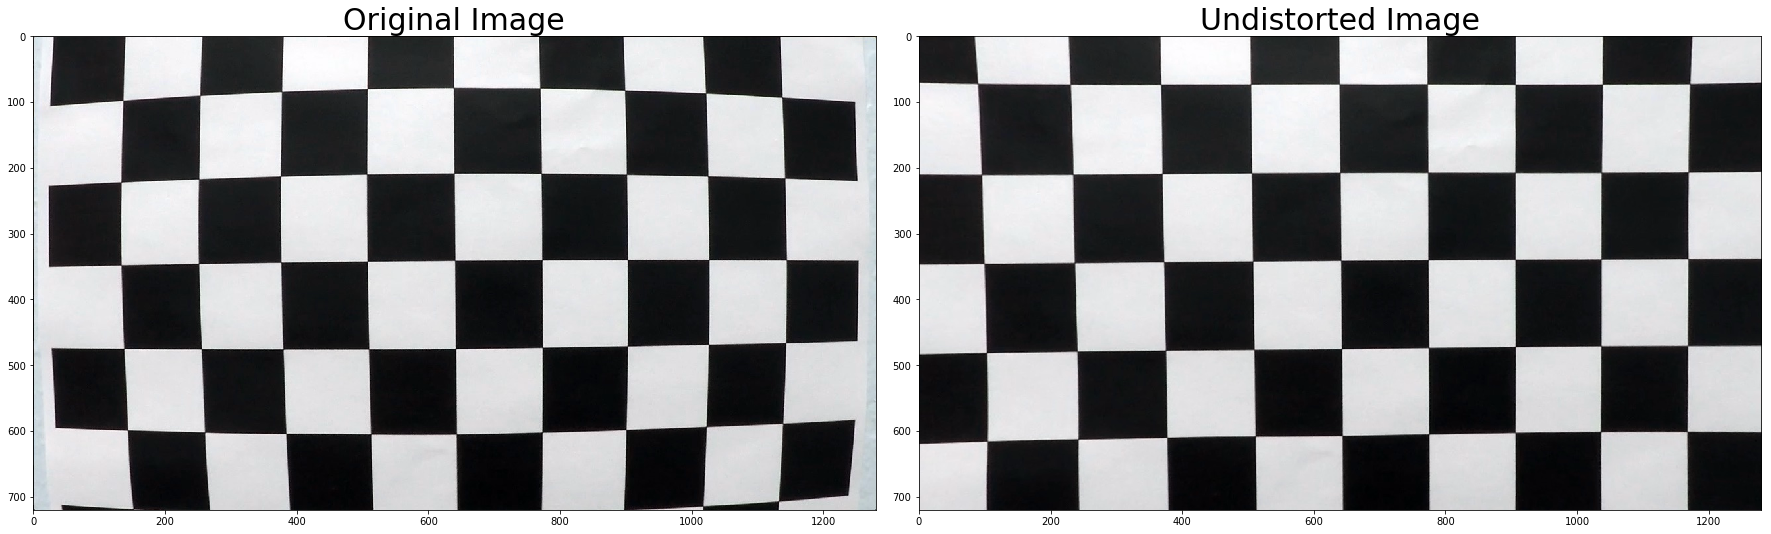

In [3]:
'''
Take an image, object points and image points and perform 
the camera calibration and image distortion correction. 

Return the undistorted image
'''
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate the camera given object points, image points and the shape of the grayscale image.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

distorted_image = cv2.imread('./camera_cal/calibration1.jpg')
# Get the undistorted image
undistorted = cal_undistort(distorted_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
f.set_facecolor("white")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/undistort_output.jpg")

## Pipeline

#### Define threshold functions

In [4]:
'''
Apply Sobel x or y, then take an absolute value and apply a threshold.

'''
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient=='x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return this mask as binary_output image
    return grad_binary

'''
Apply Sobel x and y, then compute the magnitude of the gradient and apply a threshold.
'''
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(grad_mag)
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return mag_binary

'''
Apply Sobel x and y, then compute the direction of the gradient and apply a threshold.
'''
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return dir_binary

#### Create a thresholded binary image

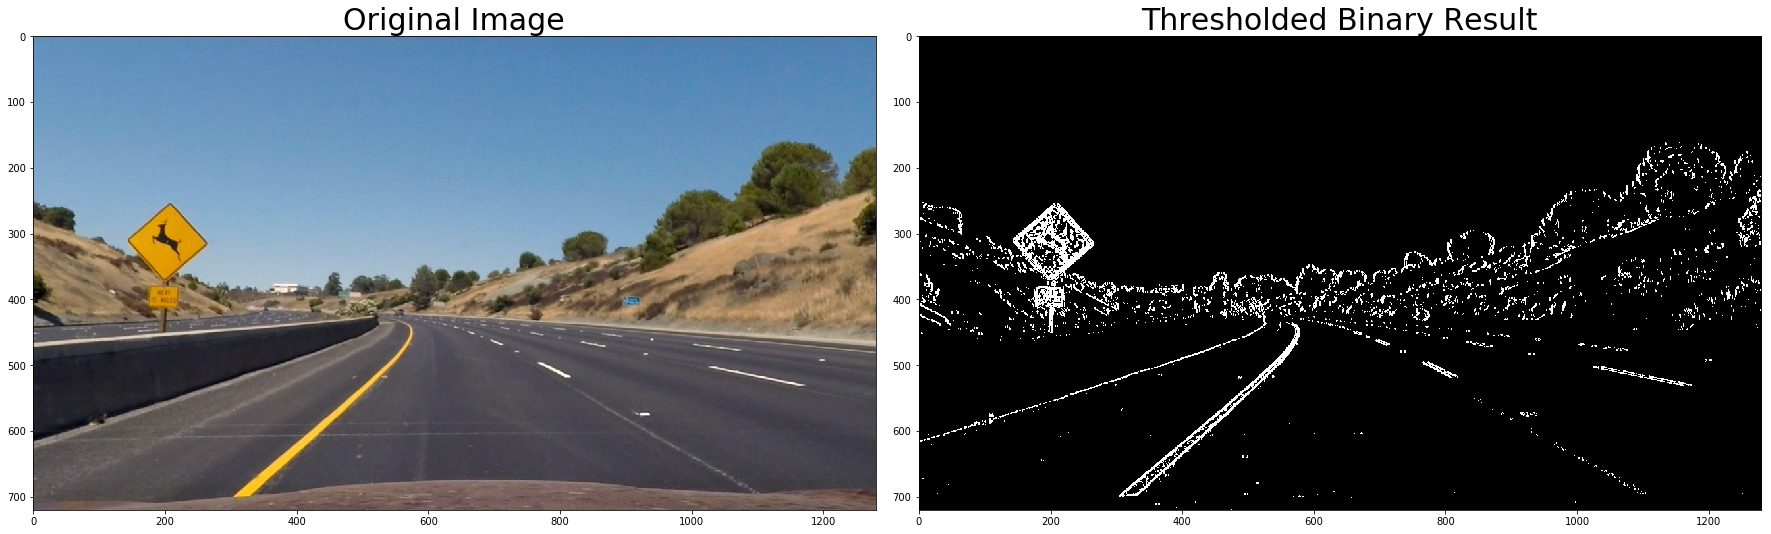

In [5]:
'''
Use color transforms and gradients to create a thresholded binary image.
'''
def threshold_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
        
    # Get Sobel thresholds
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 150))  #thresh=(20, 100)
    
    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 250
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255
    combined = np.zeros_like(s_binary)
    combined[(s_binary == 1) | (gradx == 1)] = 1    

    return combined
    
# Load a test image
test_image = mpimg.imread('./test_images/test2.jpg')  

# Undistort the test image
undistorted_test_image = cal_undistort(test_image, objpoints, imgpoints)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
    
# Apply the threshold binary function
result = threshold_binary(undistorted_test_image)

mpimg.imsave("output_images/binary_combo_example.jpg", result, cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_test_image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Perspective Transform

In [6]:
# Load an image with strainght lines to perform a perspective transform
straight_lines_image = mpimg.imread('./test_images/straight_lines1.jpg')

image_undist = cal_undistort(straight_lines_image, objpoints, imgpoints)

img_size = (image_undist.shape[1], image_undist.shape[0])

# Source and destination points
src = np.float32(
    [[(img_size[0] / 2) - 59, img_size[1] / 2 + 100],  # Top left
    [((img_size[0] / 6) - 10), img_size[1]],  # Bottom left
    [(img_size[0] * 5 / 6) + 40, img_size[1]],  # Bottom right
    [(img_size[0] / 2 + 61), img_size[1] / 2 + 100]])  # Top right
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

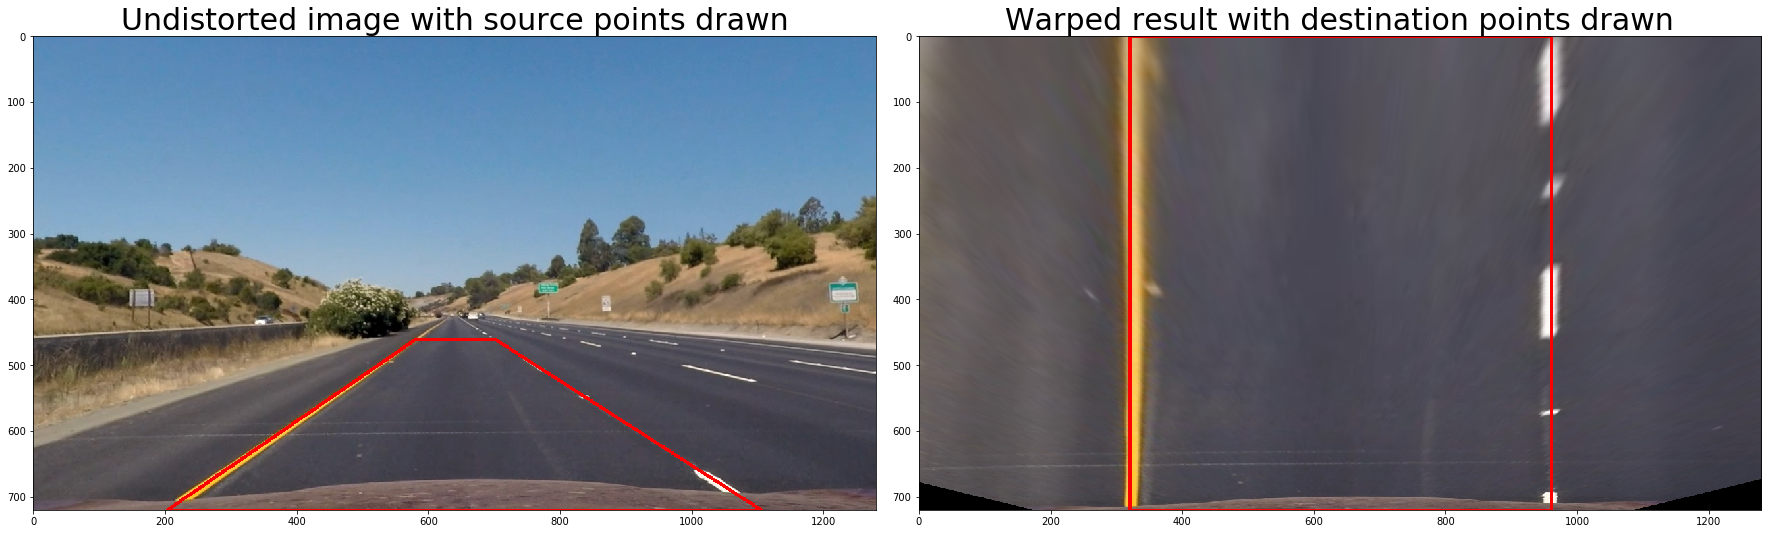

In [7]:
# Define a perspective transform function
def warper(img, src, dst):
    # Given source and destination points, compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image, given the perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

# Get the warped image
warped_image = warper(image_undist, src, dst)

# Line thickness 
line_thickness = 4

# Draw lines in the original image
cv2.line(image_undist, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[1][0], src[1][1]), (src[2][0], src[2][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(image_undist, (src[3][0], src[3][1]), (src[0][0], src[0][1]), (255, 0, 0), thickness=line_thickness)
# Draw lines in the warped image
cv2.line(warped_image, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[1][0], dst[1][1]), (dst[2][0], dst[2][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255, 0, 0), thickness=line_thickness)
cv2.line(warped_image, (dst[3][0], dst[3][1]), (dst[0][0], dst[0][1]), (255, 0, 0), thickness=line_thickness)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_undist)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)

ax2.imshow(warped_image)
ax2.set_title('Warped result with destination points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/warped_straight_lines.jpg")

#### Create a binary warped image

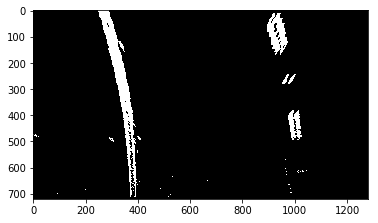

In [8]:
# Create a binary warped image. 
# result is the thresholded binary image found on cell 5 above
binary_warped = warper(result, src, dst)

plt.imshow(binary_warped, cmap='gray')

# Save on disk the warped binary image
mpimg.imsave("output_images/binary_warped.jpg", binary_warped, cmap='gray')

#### Locate the lane lines

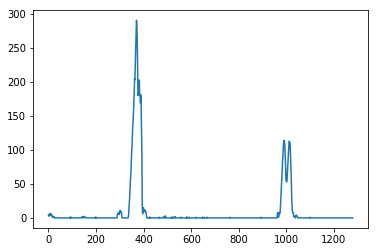

In [9]:
# Find peaks in a histogram
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)

#### Implement sliding windows

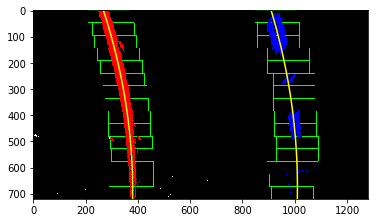

In [10]:
# Determine where the lane lines go
def find_lane_pixels(binary_warped):    
    # Create a histogram of the bottom half of the image
    histogram = hist(binary_warped)        
    # Convert the binary warped image to use the correct data type
    # See https://knowledge.udacity.com/questions/272574
    new_warped = binary_warped.astype(np.uint8)*255
    # Create an output image to draw on and visualize the result later on
    out_img = np.dstack((new_warped, new_warped, new_warped))
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin       
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return leftx, lefty, rightx, righty, ploty, out_img

# Fit a second order polynomial
def fit(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


# Fit a polynomial to all the relevant pixels found in the sliding windows
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(binary_warped)
    left_fit, right_fit = fit(binary_warped, leftx, lefty, rightx, righty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img

def visualize_lanes(left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img):
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img = fit_polynomial(binary_warped)
# Visualize the lines in the output image 
visualize_lanes(left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, out_img)

plt.imshow(out_img)

# Save on disk the image with lines drawn
plt.savefig("output_images/color_fit_lines.jpg")

### Measure the curvature 

In [11]:
def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(binary_warped)
    left_fit_cr, right_fit_cr = fit(binary_warped, leftx, lefty, rightx, righty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define the y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty * ym_per_pix)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(binary_warped)

### Radius of curvature and position of the vehicle

In [12]:
'''
Draw your measurement onto the road to identify the lane lines. 

'''
def draw(warped_binary, original_image, src, dst, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    x_left = left_fitx[len(left_fitx) - 1]
    x_right = right_fitx[len(right_fitx) - 1]
    
    # Find the center of the lane area
    half_length = (x_right + x_left) / 2
    # Find the center of the image
    center_of_image = (src[1][0] + src[2][0]) / 2

    # The distance from the center is the difference between the center of the
    # image and the center of the lane, taking the camera is positioned at the
    # center of the car. 
    distance = '%.2f'%(abs((center_of_image - half_length) * xm_per_pix))
    position = 'left'
    if half_length > center_of_image:
        position = 'right'
        
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad = measure_curvature_pixels(warped_binary)
    
    # Text to show on the image for the curvature
    curvature = int(np.mean([left_curverad, right_curverad]))
    text = 'Radius of curvature = ' + str(curvature) + '(m)'

    # Parameters for 'putText'
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,80)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 4

    cv2.putText(result,
        text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    # Text to show on the image for the position relative to center
    other_bottomLeftCornerOfText = (100,140)

    other_text = 'Vehicle is ' + distance + 'm ' + position + ' of center'
    cv2.putText(result,
        other_text, 
        other_bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    return result

### Apply the pipeline back to the original image

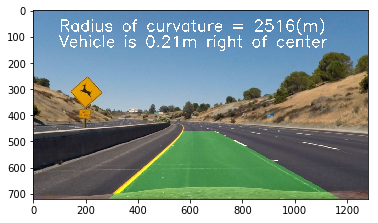

In [13]:
# Apply the pipeline to the original image, given src and dst points. 
def pipeline(original, src, dst):
    # Undistort the original image
    undistorted_image = cal_undistort(original, objpoints, imgpoints)
    # Apply the threshold binary function
    threshold_image = threshold_binary(undistorted_image)

    # Create a binary warped image
    binary_warped_image = warper(threshold_image, src, dst)

    # Create histogram of image binary activations
    activations_histogram = hist(binary_warped_image)
    
    left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, output_img = fit_polynomial(binary_warped_image)

    result = draw(binary_warped_image, undistorted_image, src, dst, ploty, left_fitx, right_fitx)
    return result
    
test_image = mpimg.imread('./test_images/test2.jpg')
image_to_draw = pipeline(test_image, src, dst)
plt.imshow(image_to_draw)
plt.savefig("output_images/example_output.jpg")

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped_image, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of 
    # our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    frame_left_fitx, frame_right_fitx, ploty = fit_poly(binary_warped_image.shape, leftx, lefty, rightx, righty)
    
    # Save the frame variables
    left_line.recent_xfitted = frame_left_fitx
    right_line.recent_xfitted = frame_right_fitx
        
    left_fitx = (frame_left_fitx + left_line.averaged_xfitted) / 2
    right_fitx = (frame_right_fitx + right_line.averaged_xfitted) / 2
    left_line.averaged_xfitted = left_fitx
    right_line.averaged_xfitted = right_fitx
        
        
    #left_line.averaged_fit = (left_line.current_fit + left_fit) / 2
    #right_line.averaged_fit = (right_line.recent_xfitted + right_fitx) / 2
        
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_image, binary_warped_image, binary_warped_image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, ploty

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([])
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([])
        #averaged x values
        self.averaged_xfitted = np.array([])
        
left_line = Line()
right_line = Line()

In [16]:
# Pipeline for the video. 
# With respect to the pipeline for the image, it first saves the values
# left_fit and right_fit from the first step, that is Calculating the sliding windows.
# Then it applies the methodology found on Search on prior. 
def pipeline_video(original, src, dst):
    # Undistort the original image
    undistorted_image = cal_undistort(original, objpoints, imgpoints)    
    # Apply the threshold binary function
    threshold_image = threshold_binary(undistorted_image)
    # Create a binary warped image
    binary_warped_image = warper(threshold_image, src, dst)
    # Create histogram of image binary activations
    activations_histogram = hist(binary_warped_image)
    
    # The first time we measure, recent_xfitted is an empty array for the lines. 
    if left_line.averaged_xfitted.size == 0 or right_line.averaged_xfitted.size == 0:
        left_fitx, leftx, lefty, right_fitx, rightx, righty, ploty, output_img = fit_polynomial(binary_warped_image)
        
        left_line.averaged_xfitted = left_fitx
        right_line.averaged_xfitted = right_fitx        
        
        left_line.current_fit, right_line.current_fit = fit(binary_warped, leftx, lefty, rightx, righty)
        
        result = draw(binary_warped_image, undistorted_image, src, dst, ploty, left_fitx, right_fitx)    
    else:
        result, ploty = search_around_poly(binary_warped_image, left_line.current_fit, right_line.current_fit)
        result = draw(binary_warped_image, undistorted_image, src, dst, ploty, left_line.averaged_xfitted, right_line.averaged_xfitted)
    return result

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below    
    result = pipeline_video(image, src, dst)
    
    return result

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


  0%|          | 1/1261 [00:01<21:32,  1.03s/it]

left fit [ -2.25905580e-04   3.05891429e-01   2.69454614e+02]
right fit [ -1.86833491e-04   2.83963759e-01   9.17616419e+02]
left fit x length 720
right fit x length 720


  0%|          | 2/1261 [00:01<21:11,  1.01s/it]

left fit [ -2.47980889e-04   3.24999027e-01   2.67273339e+02]
right fit [ -1.71190511e-04   2.79829870e-01   9.12933987e+02]
left fit x length 720
right fit x length 720


  0%|          | 3/1261 [00:02<20:46,  1.01it/s]

left fit [ -2.42235332e-04   3.22299337e-01   2.67541532e+02]
right fit [ -2.65007757e-04   3.69249001e-01   8.92203180e+02]
left fit x length 720
right fit x length 720


  0%|          | 4/1261 [00:03<20:28,  1.02it/s]

left fit [ -2.44234796e-04   3.27324229e-01   2.66477092e+02]
right fit [ -2.53766120e-04   3.74187233e-01   8.84932079e+02]
left fit x length 720
right fit x length 720


  0%|          | 5/1261 [00:04<20:12,  1.04it/s]

left fit [ -2.20774110e-04   3.18056144e-01   2.65922162e+02]
right fit [ -2.40486761e-04   3.67524110e-01   8.84275918e+02]
left fit x length 720
right fit x length 720


  0%|          | 6/1261 [00:05<20:00,  1.05it/s]

left fit [ -2.32457481e-04   3.29623124e-01   2.64014575e+02]
right fit [ -1.96330569e-04   3.38609462e-01   8.84591572e+02]
left fit x length 720
right fit x length 720


  1%|          | 7/1261 [00:06<19:47,  1.06it/s]

left fit [ -2.27690194e-04   3.32560222e-01   2.60906697e+02]
right fit [ -1.63672460e-04   3.12102840e-01   8.90360790e+02]
left fit x length 720
right fit x length 720


  1%|          | 8/1261 [00:07<19:40,  1.06it/s]

left fit [ -2.32827389e-04   3.40945573e-01   2.59070259e+02]
right fit [  1.85781948e-05   2.18997137e-01   8.93009440e+02]
left fit x length 720
right fit x length 720


  1%|          | 9/1261 [00:08<19:34,  1.07it/s]

left fit [ -2.19273229e-04   3.34909319e-01   2.56541820e+02]
right fit [  2.13227441e-05   2.02156437e-01   9.00410666e+02]
left fit x length 720
right fit x length 720


  1%|          | 10/1261 [00:09<19:32,  1.07it/s]

left fit [ -2.15998243e-04   3.37359590e-01   2.53182509e+02]
right fit [ -3.75824266e-07   2.10000090e-01   8.99756456e+02]
left fit x length 720
right fit x length 720


  1%|          | 11/1261 [00:10<19:30,  1.07it/s]

left fit [ -2.14045710e-04   3.37017927e-01   2.52354932e+02]
right fit [ -5.31358688e-05   2.44689969e-01   8.91777798e+02]
left fit x length 720
right fit x length 720


  1%|          | 12/1261 [00:11<19:27,  1.07it/s]

left fit [ -1.92744040e-04   3.29033712e-01   2.46172567e+02]
right fit [ -5.35338981e-05   2.16538239e-01   9.11093811e+02]
left fit x length 720
right fit x length 720


  1%|          | 13/1261 [00:12<19:27,  1.07it/s]

left fit [ -1.87657877e-04   3.27064899e-01   2.45657101e+02]
right fit [ -7.68265789e-05   2.39148739e-01   9.02626296e+02]
left fit x length 720
right fit x length 720


  1%|          | 14/1261 [00:13<19:23,  1.07it/s]

left fit [ -1.75732231e-04   3.18072343e-01   2.46164871e+02]
right fit [ -7.16257204e-05   2.39278716e-01   8.99338646e+02]
left fit x length 720
right fit x length 720


  1%|          | 15/1261 [00:14<19:18,  1.08it/s]

left fit [ -1.81274104e-04   3.17662322e-01   2.48724010e+02]
right fit [ -1.56736303e-04   3.24837156e-01   8.72771995e+02]
left fit x length 720
right fit x length 720


  1%|▏         | 16/1261 [00:15<19:19,  1.07it/s]

left fit [ -1.48670058e-04   2.91155155e-01   2.53993742e+02]
right fit [ -2.14236824e-04   3.89118869e-01   8.49943269e+02]
left fit x length 720
right fit x length 720


  1%|▏         | 17/1261 [00:15<19:18,  1.07it/s]

left fit [ -1.58962688e-04   3.00203841e-01   2.51426301e+02]
right fit [ -1.84737844e-04   3.65494921e-01   8.51564202e+02]
left fit x length 720
right fit x length 720


  1%|▏         | 18/1261 [00:16<19:17,  1.07it/s]

left fit [ -1.52783920e-04   2.95805586e-01   2.52065636e+02]
right fit [ -1.42677515e-04   3.34442457e-01   8.52329372e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 19/1261 [00:17<19:17,  1.07it/s]

left fit [ -1.46042278e-04   2.91241070e-01   2.49841845e+02]
right fit [ -1.39285767e-04   3.19465583e-01   8.61721163e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 20/1261 [00:18<19:17,  1.07it/s]

left fit [ -1.36833844e-04   2.86746849e-01   2.47943347e+02]
right fit [ -1.09450542e-04   2.88796048e-01   8.70608962e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 21/1261 [00:19<19:14,  1.07it/s]

left fit [ -1.30842797e-04   2.82031789e-01   2.46183141e+02]
right fit [ -5.87630975e-05   2.49129713e-01   8.82577715e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 22/1261 [00:20<19:11,  1.08it/s]

left fit [ -1.32890576e-04   2.84519145e-01   2.42115701e+02]
right fit [ -7.79763715e-05   2.42349364e-01   8.93203099e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 23/1261 [00:21<19:09,  1.08it/s]

left fit [ -1.37992509e-04   2.86890938e-01   2.39635061e+02]
right fit [ -8.14941509e-05   2.31521401e-01   9.01474017e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 24/1261 [00:22<19:09,  1.08it/s]

left fit [ -1.51001078e-04   2.89081500e-01   2.42240761e+02]
right fit [ -1.65677669e-04   2.93472811e-01   8.89168664e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 25/1261 [00:23<19:09,  1.08it/s]

left fit [ -1.70400068e-04   2.98407043e-01   2.43032803e+02]
right fit [ -1.98625928e-04   3.23886071e-01   8.81566946e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 26/1261 [00:24<19:06,  1.08it/s]

left fit [ -1.69822150e-04   2.96153185e-01   2.41362881e+02]
right fit [ -1.60577864e-04   2.80805917e-01   8.97814322e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 27/1261 [00:25<19:09,  1.07it/s]

left fit [ -1.85248644e-04   3.04529555e-01   2.40668803e+02]
right fit [ -1.22973028e-04   2.51658449e-01   9.03210443e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 28/1261 [00:26<19:11,  1.07it/s]

left fit [ -1.86567825e-04   3.05893164e-01   2.37835127e+02]
right fit [ -1.21328974e-04   2.31322511e-01   9.18047998e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 29/1261 [00:27<19:07,  1.07it/s]

left fit [ -1.87439970e-04   3.02363518e-01   2.41422191e+02]
right fit [ -1.51718810e-04   2.62604926e-01   9.08850003e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 30/1261 [00:28<19:04,  1.08it/s]

left fit [ -2.09685313e-04   3.17113677e-01   2.42460882e+02]
right fit [ -2.50033927e-04   3.65156222e-01   8.81681260e+02]
left fit x length 720
right fit x length 720


  2%|▏         | 31/1261 [00:29<19:02,  1.08it/s]

left fit [ -2.18813552e-04   3.21598192e-01   2.44977986e+02]
right fit [ -2.31205101e-04   3.64760670e-01   8.73878933e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 32/1261 [00:29<19:05,  1.07it/s]

left fit [ -2.38306429e-04   3.32531694e-01   2.47671262e+02]
right fit [ -1.94607200e-04   3.49837156e-01   8.66318446e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 33/1261 [00:30<19:03,  1.07it/s]

left fit [ -2.35665521e-04   3.31343582e-01   2.46182886e+02]
right fit [ -1.55261075e-04   3.13469480e-01   8.79184335e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 34/1261 [00:31<19:05,  1.07it/s]

left fit [ -2.52935014e-04   3.43691414e-01   2.46105417e+02]
right fit [ -3.24621243e-05   2.48481563e-01   8.81788775e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 35/1261 [00:32<19:14,  1.06it/s]

left fit [ -2.70293306e-04   3.57481014e-01   2.45243425e+02]
right fit [ -8.63345537e-05   2.78593252e-01   8.78074274e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 36/1261 [00:33<19:09,  1.07it/s]

left fit [ -2.76165214e-04   3.63761673e-01   2.45693766e+02]
right fit [ -1.85793128e-04   3.48358985e-01   8.64336433e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 37/1261 [00:34<19:04,  1.07it/s]

left fit [ -2.93755678e-04   3.78704783e-01   2.43886302e+02]
right fit [ -1.92870676e-04   3.53906907e-01   8.61804729e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 38/1261 [00:35<19:02,  1.07it/s]

left fit [ -3.08413360e-04   3.93003501e-01   2.42129082e+02]
right fit [ -1.49437601e-04   3.29731152e-01   8.61353274e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 39/1261 [00:36<19:00,  1.07it/s]

left fit [ -3.23441115e-04   4.07232491e-01   2.40503242e+02]
right fit [ -2.26352958e-04   3.97071464e-01   8.44098353e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 40/1261 [00:37<18:57,  1.07it/s]

left fit [ -3.23570132e-04   4.11367674e-01   2.37986140e+02]
right fit [ -2.76414414e-04   4.35698016e-01   8.39611341e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 41/1261 [00:38<18:54,  1.07it/s]

left fit [ -3.28912265e-04   4.19101856e-01   2.35818087e+02]
right fit [ -2.59884532e-04   4.25447522e-01   8.40244258e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 42/1261 [00:39<18:56,  1.07it/s]

left fit [ -3.17855560e-04   4.17350579e-01   2.33807772e+02]
right fit [ -2.42089293e-04   4.11371416e-01   8.43349604e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 43/1261 [00:40<18:55,  1.07it/s]

left fit [ -3.09018743e-04   4.18776745e-01   2.30946164e+02]
right fit [ -2.55370638e-04   4.20778630e-01   8.44560966e+02]
left fit x length 720
right fit x length 720


  3%|▎         | 44/1261 [00:41<18:53,  1.07it/s]

left fit [ -2.98844504e-04   4.15029167e-01   2.28602585e+02]
right fit [ -2.41608004e-04   3.98026706e-01   8.55101106e+02]
left fit x length 720
right fit x length 720


  4%|▎         | 45/1261 [00:42<18:52,  1.07it/s]

left fit [ -2.80658626e-04   4.05125463e-01   2.27898606e+02]
right fit [ -2.06787676e-04   3.66999629e-01   8.63735890e+02]
left fit x length 720
right fit x length 720


  4%|▎         | 46/1261 [00:43<18:49,  1.08it/s]

left fit [ -2.75995820e-04   4.05386560e-01   2.25756491e+02]
right fit [ -1.14032948e-04   3.09431542e-01   8.70770753e+02]
left fit x length 720
right fit x length 720


  4%|▎         | 47/1261 [00:43<18:52,  1.07it/s]

left fit [ -2.57214047e-04   3.93376159e-01   2.24837696e+02]
right fit [ -1.15050931e-04   3.01003716e-01   8.74959792e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 48/1261 [00:44<19:04,  1.06it/s]

left fit [ -2.56686622e-04   3.94487228e-01   2.24235765e+02]
right fit [ -8.30216437e-05   2.83926672e-01   8.72766003e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 49/1261 [00:45<18:59,  1.06it/s]

left fit [ -2.35952557e-04   3.81097949e-01   2.22852782e+02]
right fit [ -1.16699723e-04   2.88597385e-01   8.80574733e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 50/1261 [00:46<18:57,  1.06it/s]

left fit [ -2.26319151e-04   3.77492595e-01   2.21837265e+02]
right fit [ -2.30656084e-04   3.77172256e-01   8.64742944e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 51/1261 [00:47<19:03,  1.06it/s]

left fit [ -2.07636224e-04   3.64448747e-01   2.22619551e+02]
right fit [ -1.72453658e-04   3.33805240e-01   8.70630837e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 52/1261 [00:48<18:59,  1.06it/s]

left fit [ -1.96076497e-04   3.54920554e-01   2.24992720e+02]
right fit [ -1.56688959e-04   3.32038576e-01   8.63210065e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 53/1261 [00:49<18:55,  1.06it/s]

left fit [ -1.98839871e-04   3.54848986e-01   2.25522566e+02]
right fit [ -2.23328539e-04   3.88287903e-01   8.50937960e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 54/1261 [00:50<18:55,  1.06it/s]

left fit [ -1.76839033e-04   3.37318702e-01   2.27535040e+02]
right fit [ -2.51194790e-04   4.21381064e-01   8.40141602e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 55/1261 [00:51<18:55,  1.06it/s]

left fit [ -1.51953239e-04   3.21731610e-01   2.27606467e+02]
right fit [ -2.55606030e-04   4.23817977e-01   8.41550876e+02]
left fit x length 720
right fit x length 720


  4%|▍         | 56/1261 [00:52<18:54,  1.06it/s]

left fit [ -1.38347909e-04   3.09001436e-01   2.28927470e+02]
right fit [ -2.24346970e-04   3.95798323e-01   8.47257192e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 57/1261 [00:53<18:55,  1.06it/s]

left fit [ -1.36673036e-04   3.04814112e-01   2.30125656e+02]
right fit [ -2.10253675e-04   3.89676986e-01   8.46044435e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 58/1261 [00:54<18:50,  1.06it/s]

left fit [ -1.34312331e-04   2.99552240e-01   2.31030362e+02]
right fit [ -1.18330562e-04   3.29704517e-01   8.53965165e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 59/1261 [00:55<18:47,  1.07it/s]

left fit [ -1.52812059e-04   3.04011382e-01   2.35244165e+02]
right fit [ -5.25749595e-05   3.06059096e-01   8.44666083e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 60/1261 [00:56<18:46,  1.07it/s]

left fit [ -1.69494923e-04   3.08149246e-01   2.38633779e+02]
right fit [ -1.17103482e-04   3.46078326e-01   8.33098392e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 61/1261 [00:57<18:43,  1.07it/s]

left fit [ -1.88046693e-04   3.17028967e-01   2.38829265e+02]
right fit [ -7.83508465e-05   3.19846955e-01   8.34033077e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 62/1261 [00:58<18:39,  1.07it/s]

left fit [ -2.06174737e-04   3.25564295e-01   2.40222561e+02]
right fit [ -8.44935642e-05   3.22893309e-01   8.29764331e+02]
left fit x length 720
right fit x length 720


  5%|▍         | 63/1261 [00:59<18:40,  1.07it/s]

left fit [ -2.15543548e-04   3.29978491e-01   2.38935959e+02]
right fit [ -4.61026626e-05   2.82948733e-01   8.40456788e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 64/1261 [00:59<18:39,  1.07it/s]

left fit [ -2.26567653e-04   3.34416611e-01   2.40580065e+02]
right fit [ -1.09029316e-04   3.30140273e-01   8.31096207e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 65/1261 [01:00<18:37,  1.07it/s]

left fit [ -2.27553505e-04   3.33354898e-01   2.39605744e+02]
right fit [ -1.26501752e-04   3.29663886e-01   8.37269269e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 66/1261 [01:01<18:35,  1.07it/s]

left fit [ -2.27300317e-04   3.29811015e-01   2.42168395e+02]
right fit [ -1.29801869e-04   3.32202925e-01   8.34956070e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 67/1261 [01:02<18:32,  1.07it/s]

left fit [ -2.35391987e-04   3.35093037e-01   2.41055690e+02]
right fit [ -1.31567998e-04   3.25266815e-01   8.38110542e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 68/1261 [01:03<18:31,  1.07it/s]

left fit [ -2.03099162e-04   3.12727042e-01   2.41900677e+02]
right fit [ -1.38887895e-04   3.24991375e-01   8.41172249e+02]
left fit x length 720
right fit x length 720


  5%|▌         | 69/1261 [01:04<18:29,  1.07it/s]

left fit [ -2.07300534e-04   3.13834079e-01   2.43659615e+02]
right fit [ -1.14484108e-04   3.06817608e-01   8.40570643e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 70/1261 [01:05<18:30,  1.07it/s]

left fit [ -1.98763826e-04   3.10814687e-01   2.40891193e+02]
right fit [ -1.04253779e-04   2.92358572e-01   8.48268414e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 71/1261 [01:06<18:31,  1.07it/s]

left fit [ -1.87954618e-04   3.02026166e-01   2.42541317e+02]
right fit [ -6.82646171e-05   2.74603876e-01   8.48141157e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 72/1261 [01:07<18:28,  1.07it/s]

left fit [ -1.69807853e-04   2.90510201e-01   2.41582447e+02]
right fit [ -1.39598110e-04   3.08939444e-01   8.48397868e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 73/1261 [01:08<18:31,  1.07it/s]

left fit [ -1.51757178e-04   2.77174767e-01   2.42269937e+02]
right fit [ -2.19666242e-04   3.56917614e-01   8.44722912e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 74/1261 [01:09<18:37,  1.06it/s]

left fit [ -1.40837331e-04   2.67095182e-01   2.43254335e+02]
right fit [ -1.63913428e-04   3.17057472e-01   8.49689558e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 75/1261 [01:10<18:37,  1.06it/s]

left fit [ -1.14385830e-04   2.51367289e-01   2.41880719e+02]
right fit [ -1.42342688e-04   2.89997538e-01   8.59842618e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 76/1261 [01:11<18:34,  1.06it/s]

left fit [ -1.10427952e-04   2.44255337e-01   2.44234549e+02]
right fit [ -1.69714106e-04   3.14304747e-01   8.54147824e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 77/1261 [01:12<18:30,  1.07it/s]

left fit [ -9.62500281e-05   2.37601885e-01   2.39474496e+02]
right fit [ -1.65913846e-04   2.90698690e-01   8.70529167e+02]
left fit x length 720
right fit x length 720


  6%|▌         | 78/1261 [01:13<18:45,  1.05it/s]

left fit [ -7.77006281e-05   2.23431435e-01   2.39704124e+02]
right fit [ -2.57169708e-04   3.59596029e-01   8.63244315e+02]
left fit x length 720
right fit x length 720


  6%|▋         | 79/1261 [01:14<18:38,  1.06it/s]

left fit [ -8.19219705e-05   2.24312921e-01   2.37943342e+02]
right fit [ -2.93815591e-04   3.90927383e-01   8.59671317e+02]
left fit x length 720
right fit x length 720


  6%|▋         | 80/1261 [01:14<18:32,  1.06it/s]

left fit [ -8.74658681e-05   2.21998421e-01   2.39204524e+02]
right fit [ -2.63538986e-04   3.67055898e-01   8.62654559e+02]
left fit x length 720
right fit x length 720


  6%|▋         | 81/1261 [01:15<18:29,  1.06it/s]

left fit [ -8.08774234e-05   2.13808314e-01   2.42201229e+02]
right fit [ -2.34955564e-04   3.52959827e-01   8.58504238e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 82/1261 [01:16<18:29,  1.06it/s]

left fit [ -7.71786150e-05   2.06210304e-01   2.42987223e+02]
right fit [ -2.19867227e-04   3.37469610e-01   8.62794579e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 83/1261 [01:17<18:29,  1.06it/s]

left fit [ -8.88310116e-05   2.12522527e-01   2.41763794e+02]
right fit [ -1.69973747e-04   3.04347426e-01   8.67841103e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 84/1261 [01:18<18:24,  1.07it/s]

left fit [ -9.46427280e-05   2.20379876e-01   2.35461737e+02]
right fit [ -1.14427683e-04   2.51404313e-01   8.86956068e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 85/1261 [01:19<18:22,  1.07it/s]

left fit [ -1.03676755e-04   2.21685223e-01   2.37071197e+02]
right fit [ -4.35263985e-05   2.07698878e-01   8.91294415e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 86/1261 [01:20<18:25,  1.06it/s]

left fit [ -1.23344416e-04   2.32352962e-01   2.37567841e+02]
right fit [ -3.84577865e-05   1.96688071e-01   8.93886888e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 87/1261 [01:21<18:27,  1.06it/s]

left fit [ -1.55887797e-04   2.43784009e-01   2.45673604e+02]
right fit [ -1.77997536e-04   3.08807409e-01   8.66336897e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 88/1261 [01:22<18:30,  1.06it/s]

left fit [ -1.80233319e-04   2.54541808e-01   2.49777974e+02]
right fit [ -7.27029867e-05   2.42945227e-01   8.67707430e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 89/1261 [01:23<18:32,  1.05it/s]

left fit [ -1.98314697e-04   2.63527020e-01   2.52705815e+02]
right fit [ -1.55086734e-04   3.07727460e-01   8.54291714e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 90/1261 [01:24<18:39,  1.05it/s]

left fit [ -2.13094450e-04   2.69770114e-01   2.57826456e+02]
right fit [ -1.83528672e-04   3.45435977e-01   8.38142587e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 91/1261 [01:25<18:29,  1.05it/s]

left fit [ -2.18211664e-04   2.75967366e-01   2.55510062e+02]
right fit [ -2.16500436e-04   3.65535317e-01   8.40007824e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 92/1261 [01:26<18:23,  1.06it/s]

left fit [ -2.22943886e-04   2.82171141e-01   2.53917874e+02]
right fit [ -2.08617848e-04   3.53574885e-01   8.44832280e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 93/1261 [01:27<18:15,  1.07it/s]

left fit [ -2.31803621e-04   2.87294413e-01   2.56034095e+02]
right fit [ -1.78691627e-04   3.34102346e-01   8.43769565e+02]
left fit x length 720
right fit x length 720


  7%|▋         | 94/1261 [01:28<18:13,  1.07it/s]

left fit [ -2.30566331e-04   2.87039432e-01   2.57570208e+02]
right fit [ -1.53191022e-04   3.13603082e-01   8.45970787e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 95/1261 [01:29<18:12,  1.07it/s]

left fit [ -2.26706880e-04   2.88275800e-01   2.54943677e+02]
right fit [ -1.49372649e-04   2.99217095e-01   8.53194275e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 96/1261 [01:30<18:24,  1.05it/s]

left fit [ -2.16340117e-04   2.83419017e-01   2.54834682e+02]
right fit [ -9.71808733e-05   2.67873307e-01   8.57627776e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 97/1261 [01:30<18:18,  1.06it/s]

left fit [ -2.15591062e-04   2.86113061e-01   2.54126547e+02]
right fit [ -1.00360429e-04   2.65112683e-01   8.59045227e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 98/1261 [01:31<18:11,  1.07it/s]

left fit [ -2.11532251e-04   2.85190825e-01   2.52479628e+02]
right fit [ -1.75495599e-04   2.99779399e-01   8.62382378e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 99/1261 [01:32<18:07,  1.07it/s]

left fit [ -2.03305712e-04   2.79082367e-01   2.54802729e+02]
right fit [ -1.64278572e-04   2.97085452e-01   8.59036288e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 100/1261 [01:33<18:09,  1.07it/s]

left fit [ -2.01012251e-04   2.79441709e-01   2.53576435e+02]
right fit [ -1.33343874e-04   2.64848475e-01   8.69094048e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 101/1261 [01:34<18:08,  1.07it/s]

left fit [ -2.04534216e-04   2.82557196e-01   2.54119874e+02]
right fit [ -1.70717020e-04   2.94429834e-01   8.64169227e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 102/1261 [01:35<18:05,  1.07it/s]

left fit [ -2.07625852e-04   2.81681888e-01   2.56394571e+02]
right fit [ -2.19376167e-04   3.36157815e-01   8.54867573e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 103/1261 [01:36<18:04,  1.07it/s]

left fit [ -2.10989636e-04   2.84991830e-01   2.56157429e+02]
right fit [ -2.77822407e-04   3.83383246e-01   8.49597316e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 104/1261 [01:37<18:13,  1.06it/s]

left fit [ -2.11565429e-04   2.85378540e-01   2.56870247e+02]
right fit [ -2.68661727e-04   3.79355510e-01   8.50071516e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 105/1261 [01:38<18:18,  1.05it/s]

left fit [ -1.98631340e-04   2.78700741e-01   2.54802228e+02]
right fit [ -2.41113302e-04   3.42338525e-01   8.66345903e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 106/1261 [01:39<18:09,  1.06it/s]

left fit [ -1.89617675e-04   2.75802047e-01   2.54186260e+02]
right fit [ -2.28089012e-04   3.23601181e-01   8.75915825e+02]
left fit x length 720
right fit x length 720


  8%|▊         | 107/1261 [01:40<18:04,  1.06it/s]

left fit [ -1.95134395e-04   2.82677044e-01   2.52047209e+02]
right fit [ -2.10100858e-04   3.00799727e-01   8.86354767e+02]
left fit x length 720
right fit x length 720


  9%|▊         | 108/1261 [01:41<17:57,  1.07it/s]

left fit [ -2.08526280e-04   2.89627323e-01   2.55324632e+02]
right fit [ -1.90267719e-04   2.96476135e-01   8.81685162e+02]
left fit x length 720
right fit x length 720


  9%|▊         | 109/1261 [01:42<17:56,  1.07it/s]

left fit [ -2.08812248e-04   2.89032932e-01   2.56238018e+02]
right fit [ -7.69127934e-05   2.32010431e-01   8.88795161e+02]
left fit x length 720
right fit x length 720


  9%|▊         | 110/1261 [01:43<17:52,  1.07it/s]

left fit [ -2.14411478e-04   2.91620644e-01   2.57131318e+02]
right fit [ -7.23899751e-05   2.21032258e-01   8.93284829e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 111/1261 [01:44<17:51,  1.07it/s]

left fit [ -2.20498149e-04   2.97442029e-01   2.56573575e+02]
right fit [ -1.01001277e-04   2.37546046e-01   8.90997964e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 112/1261 [01:45<17:50,  1.07it/s]

left fit [ -2.08365566e-04   2.92406002e-01   2.53807323e+02]
right fit [ -1.14437201e-04   2.25530452e-01   9.05331748e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 113/1261 [01:45<17:51,  1.07it/s]

left fit [ -2.31626214e-04   3.05629092e-01   2.55850836e+02]
right fit [ -1.87128195e-04   2.91789552e-01   8.88161771e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 114/1261 [01:46<17:53,  1.07it/s]

left fit [ -2.34469213e-04   3.07717623e-01   2.57056993e+02]
right fit [ -1.70504435e-04   2.82776165e-01   8.88650797e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 115/1261 [01:47<17:52,  1.07it/s]

left fit [ -2.62567108e-04   3.28626891e-01   2.56666948e+02]
right fit [ -2.47982688e-04   3.55043751e-01   8.71054298e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 116/1261 [01:48<17:49,  1.07it/s]

left fit [ -2.59862879e-04   3.27740864e-01   2.57333363e+02]
right fit [ -3.15854258e-04   4.20018024e-01   8.56192776e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 117/1261 [01:49<17:47,  1.07it/s]

left fit [ -2.49055440e-04   3.22468472e-01   2.56833389e+02]
right fit [ -2.88526919e-04   4.01934293e-01   8.58854956e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 118/1261 [01:50<17:47,  1.07it/s]

left fit [ -2.43473323e-04   3.22714230e-01   2.56704089e+02]
right fit [ -2.83446871e-04   4.02158258e-01   8.57252656e+02]
left fit x length 720
right fit x length 720


  9%|▉         | 119/1261 [01:51<17:45,  1.07it/s]

left fit [ -2.36611048e-04   3.17860387e-01   2.57717792e+02]
right fit [ -2.66186601e-04   3.91469988e-01   8.58016270e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 120/1261 [01:52<17:42,  1.07it/s]

left fit [ -2.55222684e-04   3.33251056e-01   2.57604014e+02]
right fit [ -2.36454347e-04   3.83069381e-01   8.51613147e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 121/1261 [01:53<17:40,  1.07it/s]

left fit [ -2.48300293e-04   3.30549154e-01   2.56774994e+02]
right fit [ -1.89500304e-04   3.49892597e-01   8.61085675e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 122/1261 [01:54<17:38,  1.08it/s]

left fit [ -2.59401412e-04   3.41515435e-01   2.55555603e+02]
right fit [ -1.61635089e-04   3.39018719e-01   8.59743715e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 123/1261 [01:55<17:40,  1.07it/s]

left fit [ -2.67932395e-04   3.48398261e-01   2.56274022e+02]
right fit [ -2.50001178e-04   4.01971528e-01   8.45686956e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 124/1261 [01:56<17:39,  1.07it/s]

left fit [ -2.75786159e-04   3.54068596e-01   2.55843162e+02]
right fit [ -1.99661833e-04   3.70556670e-01   8.49047109e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 125/1261 [01:57<17:38,  1.07it/s]

left fit [ -2.78617042e-04   3.58207263e-01   2.55606051e+02]
right fit [ -2.15564181e-04   3.84670398e-01   8.44942383e+02]
left fit x length 720
right fit x length 720


 10%|▉         | 126/1261 [01:58<17:36,  1.07it/s]

left fit [ -2.52480600e-04   3.43502074e-01   2.54067854e+02]
right fit [ -1.64549060e-04   3.30006220e-01   8.63804673e+02]
left fit x length 720
right fit x length 720


 10%|█         | 127/1261 [01:59<17:43,  1.07it/s]

left fit [ -2.69307057e-04   3.56426640e-01   2.52860291e+02]
right fit [ -2.87966583e-04   4.33958944e-01   8.43421474e+02]
left fit x length 720
right fit x length 720


 10%|█         | 128/1261 [02:00<17:51,  1.06it/s]

left fit [ -2.57770050e-04   3.52340786e-01   2.51602584e+02]
right fit [ -3.03163586e-04   4.40544671e-01   8.46398602e+02]
left fit x length 720
right fit x length 720


 10%|█         | 129/1261 [02:00<17:46,  1.06it/s]

left fit [ -2.68570766e-04   3.60797125e-01   2.52805320e+02]
right fit [ -2.41310605e-04   4.10412312e-01   8.40052504e+02]
left fit x length 720
right fit x length 720


 10%|█         | 130/1261 [02:01<17:44,  1.06it/s]

left fit [ -2.46876047e-04   3.45784604e-01   2.53226648e+02]
right fit [ -2.49048591e-04   4.13661304e-01   8.40902926e+02]
left fit x length 720
right fit x length 720


 10%|█         | 131/1261 [02:02<17:39,  1.07it/s]

left fit [ -2.31178330e-04   3.38444997e-01   2.54271368e+02]
right fit [ -2.30130885e-04   4.01943762e-01   8.41124084e+02]
left fit x length 720
right fit x length 720


 10%|█         | 132/1261 [02:03<17:35,  1.07it/s]

left fit [ -2.29661193e-04   3.37010782e-01   2.56101519e+02]
right fit [ -2.14275143e-04   3.97039472e-01   8.37835305e+02]
left fit x length 720
right fit x length 720


 11%|█         | 133/1261 [02:04<17:32,  1.07it/s]

left fit [ -2.19774602e-04   3.29677881e-01   2.56963270e+02]
right fit [ -2.20420830e-04   3.94760728e-01   8.43156583e+02]
left fit x length 720
right fit x length 720


 11%|█         | 134/1261 [02:05<17:30,  1.07it/s]

left fit [ -2.21400870e-04   3.31209129e-01   2.57684117e+02]
right fit [ -1.47375235e-04   3.60967791e-01   8.43671355e+02]
left fit x length 720
right fit x length 720


 11%|█         | 135/1261 [02:06<17:27,  1.08it/s]

left fit [ -2.14509530e-04   3.25790248e-01   2.58712927e+02]
right fit [ -2.29134581e-04   3.99293178e-01   8.44740644e+02]
left fit x length 720
right fit x length 720


 11%|█         | 136/1261 [02:07<17:25,  1.08it/s]

left fit [ -2.15157971e-04   3.27029453e-01   2.57812842e+02]
right fit [ -1.71528252e-04   3.54258925e-01   8.55815686e+02]
left fit x length 720
right fit x length 720


 11%|█         | 137/1261 [02:08<17:24,  1.08it/s]

left fit [ -2.05997214e-04   3.21334215e-01   2.57170367e+02]
right fit [ -1.36087333e-04   3.15912695e-01   8.67494756e+02]
left fit x length 720
right fit x length 720


 11%|█         | 138/1261 [02:09<17:23,  1.08it/s]

left fit [ -2.01844273e-04   3.16717800e-01   2.56386560e+02]
right fit [ -1.29155466e-04   2.93734028e-01   8.80537885e+02]
left fit x length 720
right fit x length 720


 11%|█         | 139/1261 [02:10<17:23,  1.08it/s]

left fit [ -2.11147629e-04   3.21154611e-01   2.55666982e+02]
right fit [ -1.11483760e-04   2.79441710e-01   8.83307479e+02]
left fit x length 720
right fit x length 720


 11%|█         | 140/1261 [02:11<17:31,  1.07it/s]

left fit [ -2.02872345e-04   3.16854568e-01   2.52816723e+02]
right fit [ -7.84748028e-05   2.35658494e-01   8.99556661e+02]
left fit x length 720
right fit x length 720


 11%|█         | 141/1261 [02:12<17:37,  1.06it/s]

left fit [ -2.03522496e-04   3.15378223e-01   2.53781853e+02]
right fit [ -1.93506869e-04   3.31075722e-01   8.81778339e+02]
left fit x length 720
right fit x length 720


 11%|█▏        | 142/1261 [02:13<17:31,  1.06it/s]

left fit [ -1.91347173e-04   3.03461284e-01   2.55835127e+02]
right fit [ -2.12124616e-04   3.48440106e-01   8.77629575e+02]
left fit x length 720
right fit x length 720


 11%|█▏        | 143/1261 [02:14<17:26,  1.07it/s]

left fit [ -1.73885475e-04   2.88396756e-01   2.60716469e+02]
right fit [ -1.86235733e-04   3.41243085e-01   8.69543525e+02]
left fit x length 720
right fit x length 720


 11%|█▏        | 144/1261 [02:14<17:37,  1.06it/s]

left fit [ -1.78973759e-04   2.90193682e-01   2.60844546e+02]
right fit [ -1.69164241e-04   3.24098601e-01   8.71939009e+02]
left fit x length 720
right fit x length 720


 11%|█▏        | 145/1261 [02:15<17:31,  1.06it/s]

left fit [ -1.72628492e-04   2.83488558e-01   2.61861136e+02]
right fit [ -1.41434896e-04   2.98553255e-01   8.78004714e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 146/1261 [02:16<17:29,  1.06it/s]

left fit [ -1.64552557e-04   2.72505710e-01   2.66566455e+02]
right fit [ -1.05436164e-04   2.79344066e-01   8.77374275e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 147/1261 [02:17<17:24,  1.07it/s]

left fit [ -1.68335453e-04   2.75071793e-01   2.65704276e+02]
right fit [ -8.03518509e-05   2.55238983e-01   8.85574758e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 148/1261 [02:18<17:30,  1.06it/s]

left fit [ -1.78183991e-04   2.75378223e-01   2.72396949e+02]
right fit [ -1.87800994e-04   3.50649604e-01   8.58297367e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 149/1261 [02:19<17:24,  1.06it/s]

left fit [ -1.88124561e-04   2.79540998e-01   2.73225333e+02]
right fit [ -1.78144477e-04   3.42820645e-01   8.59976476e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 150/1261 [02:20<17:32,  1.06it/s]

left fit [ -1.83496551e-04   2.77983767e-01   2.70965206e+02]
right fit [ -1.57358044e-04   3.11367674e-01   8.72722597e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 151/1261 [02:21<17:24,  1.06it/s]

left fit [ -1.75606927e-04   2.72981175e-01   2.69776049e+02]
right fit [ -2.00451134e-04   3.35741623e-01   8.72657936e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 152/1261 [02:22<17:20,  1.07it/s]

left fit [ -1.72605752e-04   2.71575471e-01   2.67725131e+02]
right fit [ -2.57196645e-04   3.74993573e-01   8.69749904e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 153/1261 [02:23<17:23,  1.06it/s]

left fit [ -1.83676680e-04   2.77236059e-01   2.68890942e+02]
right fit [ -2.98234964e-04   4.26135241e-01   8.52456279e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 154/1261 [02:24<17:24,  1.06it/s]

left fit [ -1.74618250e-04   2.74841673e-01   2.64883914e+02]
right fit [ -2.73437305e-04   3.96455708e-01   8.65184161e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 155/1261 [02:25<17:17,  1.07it/s]

left fit [ -1.72800307e-04   2.79706087e-01   2.60214665e+02]
right fit [ -2.49872630e-04   3.74915620e-01   8.71626057e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 156/1261 [02:26<17:19,  1.06it/s]

left fit [ -1.74723434e-04   2.80734221e-01   2.59206110e+02]
right fit [ -2.22812245e-04   3.54355321e-01   8.72934659e+02]
left fit x length 720
right fit x length 720


 12%|█▏        | 157/1261 [02:27<17:13,  1.07it/s]

left fit [ -1.77389868e-04   2.84134509e-01   2.57137165e+02]
right fit [ -1.94354191e-04   3.34680398e-01   8.73718947e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 158/1261 [02:28<17:11,  1.07it/s]

left fit [ -1.91230053e-04   2.90251940e-01   2.58553378e+02]
right fit [ -1.55792892e-04   3.20197787e-01   8.65290847e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 159/1261 [02:29<17:08,  1.07it/s]

left fit [ -1.91879157e-04   2.94324283e-01   2.54260280e+02]
right fit [ -5.11438869e-05   2.62010558e-01   8.72955561e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 160/1261 [02:29<17:08,  1.07it/s]

left fit [ -2.01942050e-04   3.02356782e-01   2.52823306e+02]
right fit [ -8.36361990e-05   2.88175085e-01   8.63781970e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 161/1261 [02:30<17:09,  1.07it/s]

left fit [ -2.04138284e-04   3.08789991e-01   2.47393750e+02]
right fit [ -9.82998362e-05   2.81505037e-01   8.72192494e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 162/1261 [02:31<17:08,  1.07it/s]

left fit [ -2.09098826e-04   3.15747629e-01   2.43591716e+02]
right fit [ -1.02881693e-04   2.77221994e-01   8.75201613e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 163/1261 [02:32<17:05,  1.07it/s]

left fit [ -2.10641761e-04   3.19268116e-01   2.40084107e+02]
right fit [ -6.37766949e-05   2.37873585e-01   8.86140923e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 164/1261 [02:33<17:03,  1.07it/s]

left fit [ -2.21310288e-04   3.27382265e-01   2.39873471e+02]
right fit [ -6.45467862e-05   2.49899800e-01   8.76581210e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 165/1261 [02:34<17:09,  1.07it/s]

left fit [ -2.19691280e-04   3.25220482e-01   2.42071872e+02]
right fit [ -2.20164850e-04   3.82950763e-01   8.45923536e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 166/1261 [02:35<17:11,  1.06it/s]

left fit [ -2.10130064e-04   3.21106642e-01   2.39911063e+02]
right fit [ -2.16577122e-04   3.78137714e-01   8.47534155e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 167/1261 [02:36<17:07,  1.07it/s]

left fit [ -2.23014249e-04   3.28511248e-01   2.40683442e+02]
right fit [ -1.80404885e-04   3.61061896e-01   8.42611423e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 168/1261 [02:37<17:03,  1.07it/s]

left fit [ -1.93981062e-04   3.17206014e-01   2.36227910e+02]
right fit [ -1.96637526e-04   3.57182546e-01   8.53852219e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 169/1261 [02:38<17:11,  1.06it/s]

left fit [ -1.85065956e-04   3.14465815e-01   2.33402708e+02]
right fit [ -1.81346554e-04   3.39143941e-01   8.59753602e+02]
left fit x length 720
right fit x length 720


 13%|█▎        | 170/1261 [02:39<17:06,  1.06it/s]

left fit [ -1.65239161e-04   3.02781506e-01   2.30903931e+02]
right fit [ -1.72984860e-04   3.15439033e-01   8.71381412e+02]
left fit x length 720
right fit x length 720


 14%|█▎        | 171/1261 [02:40<17:07,  1.06it/s]

left fit [ -1.56306518e-04   2.96707218e-01   2.30259555e+02]
right fit [ -1.63895870e-04   3.03226186e-01   8.74413360e+02]
left fit x length 720
right fit x length 720


 14%|█▎        | 172/1261 [02:41<17:09,  1.06it/s]

left fit [ -1.51947179e-04   2.94500261e-01   2.29083593e+02]
right fit [ -1.75267929e-04   3.13474310e-01   8.70705289e+02]
left fit x length 720
right fit x length 720


 14%|█▎        | 173/1261 [02:42<17:01,  1.06it/s]

left fit [ -1.62825373e-04   2.98047558e-01   2.29797316e+02]
right fit [ -2.95144242e-04   3.96685777e-01   8.55292605e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 174/1261 [02:43<16:56,  1.07it/s]

left fit [ -1.78389102e-04   3.04264027e-01   2.31857363e+02]
right fit [ -2.98946071e-04   4.22076987e-01   8.39501759e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 175/1261 [02:44<16:56,  1.07it/s]

left fit [ -1.86382611e-04   3.06728545e-01   2.32797338e+02]
right fit [ -3.43350905e-04   4.70008383e-01   8.26091179e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 176/1261 [02:45<17:01,  1.06it/s]

left fit [ -1.99333462e-04   3.14745861e-01   2.31591832e+02]
right fit [ -3.22321914e-04   4.64854728e-01   8.23053256e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 177/1261 [02:45<16:57,  1.07it/s]

left fit [ -1.88060520e-04   3.10246966e-01   2.27587184e+02]
right fit [ -3.61193028e-04   4.78963903e-01   8.31305945e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 178/1261 [02:46<16:56,  1.07it/s]

left fit [ -1.95234319e-04   3.13917197e-01   2.26837346e+02]
right fit [ -3.72848334e-04   4.91454505e-01   8.32393767e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 179/1261 [02:47<16:50,  1.07it/s]

left fit [ -2.00838774e-04   3.16205907e-01   2.26987151e+02]
right fit [ -3.57656741e-04   4.83236363e-01   8.34889759e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 180/1261 [02:48<16:49,  1.07it/s]

left fit [ -2.02361614e-04   3.16179723e-01   2.27087715e+02]
right fit [ -3.70045349e-04   4.93312283e-01   8.37837623e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 181/1261 [02:49<16:51,  1.07it/s]

left fit [ -2.24981959e-04   3.27073412e-01   2.29861581e+02]
right fit [ -3.27931278e-04   4.73391515e-01   8.34135590e+02]
left fit x length 720
right fit x length 720


 14%|█▍        | 182/1261 [02:50<16:48,  1.07it/s]

left fit [ -2.33381071e-04   3.31127375e-01   2.28733875e+02]
right fit [ -3.11121477e-04   4.57275098e-01   8.41388171e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 183/1261 [02:51<16:48,  1.07it/s]

left fit [ -2.60242126e-04   3.46651312e-01   2.30622502e+02]
right fit [ -2.89072836e-04   4.62581454e-01   8.31434135e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 184/1261 [02:52<16:45,  1.07it/s]

left fit [ -2.79578473e-04   3.56806973e-01   2.32532737e+02]
right fit [ -1.73735071e-04   4.08506647e-01   8.29156887e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 185/1261 [02:53<16:51,  1.06it/s]

left fit [ -2.96876450e-04   3.67851052e-01   2.33521230e+02]
right fit [ -1.65876134e-04   4.06099098e-01   8.24000693e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 186/1261 [02:54<16:47,  1.07it/s]

left fit [ -3.31405206e-04   3.88936399e-01   2.37153740e+02]
right fit [ -1.67138068e-04   4.15883577e-01   8.10887502e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 187/1261 [02:55<16:45,  1.07it/s]

left fit [ -3.35151754e-04   3.93173803e-01   2.36736603e+02]
right fit [ -1.21443214e-04   3.80504093e-01   8.15297827e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 188/1261 [02:56<16:45,  1.07it/s]

left fit [ -3.48543177e-04   4.06896432e-01   2.36279091e+02]
right fit [ -6.61051655e-05   3.42614490e-01   8.16608727e+02]
left fit x length 720
right fit x length 720


 15%|█▍        | 189/1261 [02:57<16:41,  1.07it/s]

left fit [ -3.36336908e-04   4.01689247e-01   2.36609648e+02]
right fit [ -8.29647630e-05   3.45771501e-01   8.18223593e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 190/1261 [02:58<16:39,  1.07it/s]

left fit [ -3.29412667e-04   4.00313404e-01   2.37269701e+02]
right fit [ -1.02978879e-04   3.54369840e-01   8.17693818e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 191/1261 [02:59<16:37,  1.07it/s]

left fit [ -3.28282950e-04   4.02229670e-01   2.38648542e+02]
right fit [ -1.13878920e-04   3.60292541e-01   8.14656451e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 192/1261 [02:59<16:36,  1.07it/s]

left fit [ -2.88630697e-04   3.79188706e-01   2.39521217e+02]
right fit [ -1.42031206e-04   3.72784973e-01   8.18279956e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 193/1261 [03:00<16:33,  1.07it/s]

left fit [ -2.84582064e-04   3.80066556e-01   2.40707368e+02]
right fit [ -1.40328273e-04   3.76556353e-01   8.14179605e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 194/1261 [03:01<16:36,  1.07it/s]

left fit [ -2.74742422e-04   3.73716537e-01   2.41738663e+02]
right fit [ -1.61895240e-04   3.86370467e-01   8.16023188e+02]
left fit x length 720
right fit x length 720


 15%|█▌        | 195/1261 [03:02<16:34,  1.07it/s]

left fit [ -2.71621211e-04   3.72911697e-01   2.41182021e+02]
right fit [ -1.63742696e-04   3.83670816e-01   8.18752641e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 196/1261 [03:03<16:33,  1.07it/s]

left fit [ -2.29839577e-04   3.48192299e-01   2.36908487e+02]
right fit [ -1.30522187e-04   3.58131984e-01   8.34611881e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 197/1261 [03:04<16:35,  1.07it/s]

left fit [ -2.19439654e-04   3.45621645e-01   2.29783576e+02]
right fit [ -1.15253578e-04   3.14407195e-01   8.59552895e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 198/1261 [03:05<16:37,  1.07it/s]

left fit [ -2.07091725e-04   3.43218364e-01   2.22252882e+02]
right fit [ -6.06099785e-05   2.44506846e-01   8.87591292e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 199/1261 [03:06<16:33,  1.07it/s]

left fit [ -1.87122518e-04   3.36886901e-01   2.15155801e+02]
right fit [ -6.60648588e-05   2.18483510e-01   9.07383398e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 200/1261 [03:07<16:30,  1.07it/s]

left fit [ -1.83274279e-04   3.32111280e-01   2.15878633e+02]
right fit [ -1.18619309e-04   2.58137236e-01   8.98293495e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 201/1261 [03:08<16:28,  1.07it/s]

left fit [ -1.65631041e-04   3.17855207e-01   2.15661465e+02]
right fit [ -1.97711875e-04   3.09065021e-01   8.94454399e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 202/1261 [03:09<16:25,  1.07it/s]

left fit [ -1.78036050e-04   3.20293560e-01   2.18612951e+02]
right fit [ -1.34502248e-04   2.80350668e-01   8.86557229e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 203/1261 [03:10<16:26,  1.07it/s]

left fit [ -1.95129957e-04   3.26964407e-01   2.20206164e+02]
right fit [ -1.49249976e-04   2.99112222e-01   8.77228316e+02]
left fit x length 720
right fit x length 720


 16%|█▌        | 204/1261 [03:11<16:24,  1.07it/s]

left fit [ -1.97063614e-04   3.29514061e-01   2.18892662e+02]
right fit [ -2.75455972e-04   4.12918739e-01   8.54959366e+02]
left fit x length 720
right fit x length 720


 16%|█▋        | 205/1261 [03:12<16:25,  1.07it/s]

left fit [ -2.07983571e-04   3.34157766e-01   2.22090188e+02]
right fit [ -2.49572229e-04   4.08380451e-01   8.44864835e+02]
left fit x length 720
right fit x length 720


 16%|█▋        | 206/1261 [03:13<16:25,  1.07it/s]

left fit [ -2.14357434e-04   3.37531265e-01   2.23114926e+02]
right fit [ -2.27475907e-04   3.95487755e-01   8.43440479e+02]
left fit x length 720
right fit x length 720


 16%|█▋        | 207/1261 [03:13<16:23,  1.07it/s]

left fit [ -2.31462307e-04   3.45131406e-01   2.27908438e+02]
right fit [ -1.94767637e-04   3.85631072e-01   8.33128187e+02]
left fit x length 720
right fit x length 720


 16%|█▋        | 208/1261 [03:14<16:20,  1.07it/s]

left fit [ -2.37457272e-04   3.46235792e-01   2.30505090e+02]
right fit [ -1.77608719e-04   3.85752718e-01   8.27178377e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 209/1261 [03:15<16:19,  1.07it/s]

left fit [ -2.42147561e-04   3.52422275e-01   2.27567918e+02]
right fit [ -1.47055780e-04   3.68934265e-01   8.32250079e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 210/1261 [03:16<16:23,  1.07it/s]

left fit [ -2.40362085e-04   3.53619861e-01   2.25016756e+02]
right fit [ -1.35741535e-04   3.46221850e-01   8.42176452e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 211/1261 [03:17<16:22,  1.07it/s]

left fit [ -2.23428421e-04   3.45739358e-01   2.21537709e+02]
right fit [ -2.53475166e-04   4.00859328e-01   8.49589739e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 212/1261 [03:18<16:21,  1.07it/s]

left fit [ -2.40825553e-04   3.57688988e-01   2.20830589e+02]
right fit [ -1.92918743e-04   3.69082593e-01   8.48181566e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 213/1261 [03:19<16:21,  1.07it/s]

left fit [ -2.47068919e-04   3.63570684e-01   2.18852373e+02]
right fit [ -1.62175052e-04   3.42193562e-01   8.53196835e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 214/1261 [03:20<16:30,  1.06it/s]

left fit [ -2.56089255e-04   3.71025566e-01   2.17860965e+02]
right fit [ -1.64453826e-04   3.52196828e-01   8.45691913e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 215/1261 [03:21<16:28,  1.06it/s]

left fit [ -2.70337182e-04   3.83459886e-01   2.15061810e+02]
right fit [ -2.19145687e-04   3.99192604e-01   8.33694885e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 216/1261 [03:22<16:27,  1.06it/s]

left fit [ -2.69308294e-04   3.85183380e-01   2.13262661e+02]
right fit [ -1.88439033e-04   3.72694222e-01   8.36408809e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 217/1261 [03:23<16:24,  1.06it/s]

left fit [ -2.64578746e-04   3.86395923e-01   2.11842041e+02]
right fit [ -1.53089735e-04   3.43668328e-01   8.37804343e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 218/1261 [03:24<16:19,  1.06it/s]

left fit [ -2.41456935e-04   3.74537953e-01   2.08966217e+02]
right fit [ -1.72262445e-04   3.50618494e-01   8.41279785e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 219/1261 [03:25<16:17,  1.07it/s]

left fit [ -2.43095350e-04   3.75874387e-01   2.10280427e+02]
right fit [ -1.43904086e-04   3.34261197e-01   8.36187207e+02]
left fit x length 720
right fit x length 720


 17%|█▋        | 220/1261 [03:26<16:14,  1.07it/s]

left fit [ -2.25013099e-04   3.68122195e-01   2.06128924e+02]
right fit [ -1.15067222e-04   3.13401045e-01   8.43028637e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 221/1261 [03:27<16:10,  1.07it/s]

left fit [ -2.12616616e-04   3.62067458e-01   2.05312206e+02]
right fit [ -2.38580236e-05   2.65741360e-01   8.46570210e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 222/1261 [03:28<16:08,  1.07it/s]

left fit [ -2.04724526e-04   3.56890419e-01   2.05418008e+02]
right fit [ -3.99503103e-05   2.62008713e-01   8.49086315e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 223/1261 [03:28<16:07,  1.07it/s]

left fit [ -1.90059446e-04   3.47851685e-01   2.04985738e+02]
right fit [ -9.60239083e-05   2.90792657e-01   8.48289796e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 224/1261 [03:29<16:17,  1.06it/s]

left fit [ -1.99811814e-04   3.49891925e-01   2.08859985e+02]
right fit [ -9.08045567e-05   2.98575099e-01   8.37285405e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 225/1261 [03:30<16:11,  1.07it/s]

left fit [ -1.99178829e-04   3.50030146e-01   2.07073037e+02]
right fit [ -8.87548132e-05   2.89452776e-01   8.42234461e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 226/1261 [03:31<16:09,  1.07it/s]

left fit [ -2.11754370e-04   3.53190891e-01   2.09509311e+02]
right fit [ -1.01873975e-04   3.00591118e-01   8.35778526e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 227/1261 [03:32<16:06,  1.07it/s]

left fit [ -1.95468172e-04   3.44519956e-01   2.07989341e+02]
right fit [ -1.31079604e-04   3.20268418e-01   8.33419981e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 228/1261 [03:33<16:04,  1.07it/s]

left fit [ -1.85331517e-04   3.37938625e-01   2.06156263e+02]
right fit [ -1.40728051e-04   3.18668384e-01   8.37551253e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 229/1261 [03:34<16:02,  1.07it/s]

left fit [ -1.84715617e-04   3.36429967e-01   2.05625490e+02]
right fit [ -1.42250287e-04   3.14449054e-01   8.38778548e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 230/1261 [03:35<16:01,  1.07it/s]

left fit [ -1.74440754e-04   3.32417946e-01   2.01595343e+02]
right fit [ -1.63296409e-04   3.20892583e-01   8.43137410e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 231/1261 [03:36<16:00,  1.07it/s]

left fit [ -1.60051525e-04   3.18231755e-01   2.04475019e+02]
right fit [ -1.52887797e-04   3.14920322e-01   8.40476503e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 232/1261 [03:37<15:59,  1.07it/s]

left fit [ -1.50288745e-04   3.13952116e-01   2.00401225e+02]
right fit [ -1.66433731e-04   3.18245016e-01   8.43902040e+02]
left fit x length 720
right fit x length 720


 18%|█▊        | 233/1261 [03:38<15:57,  1.07it/s]

left fit [ -1.39691941e-04   3.03902870e-01   2.01014022e+02]
right fit [ -1.28236010e-04   2.97579489e-01   8.44108891e+02]
left fit x length 720
right fit x length 720


 19%|█▊        | 234/1261 [03:39<15:55,  1.08it/s]

left fit [ -1.38251084e-04   3.01073590e-01   2.00669440e+02]
right fit [ -1.69638403e-04   3.22751589e-01   8.39621807e+02]
left fit x length 720
right fit x length 720


 19%|█▊        | 235/1261 [03:40<15:53,  1.08it/s]

left fit [ -1.36738310e-04   2.97015474e-01   2.00588301e+02]
right fit [ -1.79706876e-04   3.32994596e-01   8.36580244e+02]
left fit x length 720
right fit x length 720


 19%|█▊        | 236/1261 [03:41<15:57,  1.07it/s]

left fit [ -1.58933189e-04   3.06497648e-01   2.03780798e+02]
right fit [ -1.81492586e-04   3.40945678e-01   8.27891514e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 237/1261 [03:42<15:58,  1.07it/s]

left fit [ -1.65142957e-04   3.09745506e-01   2.02406492e+02]
right fit [ -2.04665848e-04   3.62088446e-01   8.23682098e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 238/1261 [03:42<15:59,  1.07it/s]

left fit [ -1.76620748e-04   3.14928200e-01   2.03335358e+02]
right fit [ -1.60916574e-04   3.33158586e-01   8.25191265e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 239/1261 [03:43<16:08,  1.06it/s]

left fit [ -1.72334084e-04   3.06843508e-01   2.06384595e+02]
right fit [ -1.76659588e-04   3.49653589e-01   8.19170627e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 240/1261 [03:44<16:02,  1.06it/s]

left fit [ -1.79327534e-04   3.11429285e-01   2.04813242e+02]
right fit [ -1.62103568e-04   3.37616033e-01   8.21637737e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 241/1261 [03:45<15:57,  1.07it/s]

left fit [ -1.88229860e-04   3.16766679e-01   2.04042582e+02]
right fit [ -1.59946203e-04   3.32409411e-01   8.22796500e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 242/1261 [03:46<15:55,  1.07it/s]

left fit [ -1.82177840e-04   3.14377590e-01   2.00267686e+02]
right fit [ -1.72373723e-04   3.34501433e-01   8.29508369e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 243/1261 [03:47<15:51,  1.07it/s]

left fit [ -1.97715698e-04   3.19853619e-01   2.04081271e+02]
right fit [ -1.79230420e-04   3.49024229e-01   8.21100604e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 244/1261 [03:48<15:57,  1.06it/s]

left fit [ -1.95542502e-04   3.19084787e-01   2.02874766e+02]
right fit [ -1.81228116e-04   3.41990870e-01   8.25632095e+02]
left fit x length 720
right fit x length 720


 19%|█▉        | 245/1261 [03:49<15:57,  1.06it/s]

left fit [ -2.06491976e-04   3.20872716e-01   2.06031128e+02]
right fit [ -1.39472564e-04   3.26760190e-01   8.20794359e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 246/1261 [03:50<15:52,  1.07it/s]

left fit [ -2.16262191e-04   3.25850732e-01   2.06543189e+02]
right fit [ -1.71281781e-04   3.40831482e-01   8.18965643e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 247/1261 [03:51<15:47,  1.07it/s]

left fit [ -2.09613140e-04   3.21401484e-01   2.05681296e+02]
right fit [ -1.67755084e-04   3.36312919e-01   8.20843233e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 248/1261 [03:52<15:48,  1.07it/s]

left fit [ -2.15827786e-04   3.23569805e-01   2.09036720e+02]
right fit [ -1.74135763e-04   3.48199340e-01   8.13604918e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 249/1261 [03:53<15:46,  1.07it/s]

left fit [ -2.08795886e-04   3.21438270e-01   2.06132970e+02]
right fit [ -2.03349334e-04   3.61810820e-01   8.17891932e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 250/1261 [03:54<15:43,  1.07it/s]

left fit [ -2.05317516e-04   3.16029162e-01   2.08970907e+02]
right fit [ -1.53234282e-04   3.27010097e-01   8.21409366e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 251/1261 [03:55<15:39,  1.08it/s]

left fit [ -2.01491307e-04   3.13433252e-01   2.07912192e+02]
right fit [ -1.64517496e-04   3.33764755e-01   8.22175200e+02]
left fit x length 720
right fit x length 720


 20%|█▉        | 252/1261 [03:56<15:38,  1.08it/s]

left fit [ -1.76811771e-04   2.95178609e-01   2.09698274e+02]
right fit [ -1.42072937e-04   3.14982336e-01   8.25703384e+02]
left fit x length 720
right fit x length 720


 20%|██        | 253/1261 [03:57<15:37,  1.08it/s]

left fit [ -1.93165697e-04   3.03248120e-01   2.10351439e+02]
right fit [ -1.40504899e-04   3.10789813e-01   8.26339117e+02]
left fit x length 720
right fit x length 720


 20%|██        | 254/1261 [03:57<15:37,  1.07it/s]

left fit [ -1.81728664e-04   2.96317614e-01   2.09365554e+02]
right fit [ -1.41268019e-04   3.01682491e-01   8.34130831e+02]
left fit x length 720
right fit x length 720


 20%|██        | 255/1261 [03:58<15:37,  1.07it/s]

left fit [ -1.74689367e-04   2.84150377e-01   2.16371745e+02]
right fit [ -1.45635497e-04   3.09423985e-01   8.30084065e+02]
left fit x length 720
right fit x length 720


 20%|██        | 256/1261 [03:59<15:43,  1.06it/s]

left fit [ -1.80951164e-04   2.86793875e-01   2.16717194e+02]
right fit [ -1.50511714e-04   3.06842755e-01   8.33298524e+02]
left fit x length 720
right fit x length 720


 20%|██        | 257/1261 [04:00<15:42,  1.07it/s]

left fit [ -1.78484905e-04   2.78546338e-01   2.21771841e+02]
right fit [ -1.76531802e-04   3.25478726e-01   8.29765553e+02]
left fit x length 720
right fit x length 720


 20%|██        | 258/1261 [04:01<15:40,  1.07it/s]

left fit [ -1.73858441e-04   2.69808687e-01   2.26703010e+02]
right fit [ -2.04630638e-04   3.44770819e-01   8.26361983e+02]
left fit x length 720
right fit x length 720


 21%|██        | 259/1261 [04:02<15:35,  1.07it/s]

left fit [ -1.76912172e-04   2.69552553e-01   2.27911024e+02]
right fit [ -1.99214190e-04   3.42370310e-01   8.29548516e+02]
left fit x length 720
right fit x length 720


 21%|██        | 260/1261 [04:03<15:34,  1.07it/s]

left fit [ -1.78540033e-04   2.65351994e-01   2.33106617e+02]
right fit [ -2.04572536e-04   3.50650950e-01   8.25733641e+02]
left fit x length 720
right fit x length 720


 21%|██        | 261/1261 [04:04<15:31,  1.07it/s]

left fit [ -1.70686983e-04   2.63858076e-01   2.30240500e+02]
right fit [ -1.85267593e-04   3.25920522e-01   8.38989202e+02]
left fit x length 720
right fit x length 720


 21%|██        | 262/1261 [04:05<15:29,  1.07it/s]

left fit [ -1.73231376e-04   2.60543442e-01   2.34379856e+02]
right fit [ -2.68174944e-04   3.89956279e-01   8.29912140e+02]
left fit x length 720
right fit x length 720


 21%|██        | 263/1261 [04:06<15:29,  1.07it/s]

left fit [ -1.66274869e-04   2.54622321e-01   2.36039176e+02]
right fit [ -2.70510634e-04   3.87885100e-01   8.33770758e+02]
left fit x length 720
right fit x length 720


 21%|██        | 264/1261 [04:07<15:29,  1.07it/s]

left fit [ -1.60210753e-04   2.45412730e-01   2.38974191e+02]
right fit [ -2.57950018e-04   3.73719953e-01   8.40046182e+02]
left fit x length 720
right fit x length 720


 21%|██        | 265/1261 [04:08<15:27,  1.07it/s]

left fit [ -1.69981970e-04   2.49543256e-01   2.39144709e+02]
right fit [ -2.53857020e-04   3.71081421e-01   8.41432785e+02]
left fit x length 720
right fit x length 720


 21%|██        | 266/1261 [04:09<15:25,  1.07it/s]

left fit [ -1.80466878e-04   2.61679168e-01   2.33804284e+02]
right fit [ -2.42591817e-04   3.51201521e-01   8.53123842e+02]
left fit x length 720
right fit x length 720


 21%|██        | 267/1261 [04:10<15:27,  1.07it/s]

left fit [ -1.75604223e-04   2.51605999e-01   2.39756447e+02]
right fit [ -2.16348731e-04   3.37538284e-01   8.51684905e+02]
left fit x length 720
right fit x length 720


 21%|██▏       | 268/1261 [04:11<15:26,  1.07it/s]

left fit [ -1.71833111e-04   2.47667173e-01   2.40338994e+02]
right fit [ -1.81890970e-04   3.00062872e-01   8.62532817e+02]
left fit x length 720
right fit x length 720


 21%|██▏       | 269/1261 [04:11<15:30,  1.07it/s]

left fit [ -1.64235466e-04   2.44277265e-01   2.38161632e+02]
right fit [ -1.65943467e-04   2.78802897e-01   8.73707397e+02]
left fit x length 720
right fit x length 720


 21%|██▏       | 270/1261 [04:12<15:28,  1.07it/s]

left fit [ -1.73714192e-04   2.47363754e-01   2.39995061e+02]
right fit [ -1.07483682e-04   2.50058166e-01   8.74516397e+02]
left fit x length 720
right fit x length 720


 21%|██▏       | 271/1261 [04:13<15:24,  1.07it/s]

left fit [ -1.69331906e-04   2.39704392e-01   2.44600662e+02]
right fit [ -2.41898572e-04   3.41725426e-01   8.59321003e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 272/1261 [04:14<15:32,  1.06it/s]

left fit [ -1.91705021e-04   2.52407329e-01   2.48756955e+02]
right fit [ -1.67208214e-04   3.11441829e-01   8.51805723e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 273/1261 [04:15<15:32,  1.06it/s]

left fit [ -1.84692152e-04   2.44697531e-01   2.51885425e+02]
right fit [ -1.85728120e-04   3.19596646e-01   8.52207033e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 274/1261 [04:16<15:36,  1.05it/s]

left fit [ -1.85660777e-04   2.39598023e-01   2.58421775e+02]
right fit [ -2.24176799e-04   3.65798153e-01   8.36846039e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 275/1261 [04:17<15:42,  1.05it/s]

left fit [ -1.78475550e-04   2.35532637e-01   2.58567777e+02]
right fit [ -2.26170193e-04   3.59188584e-01   8.43193602e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 276/1261 [04:18<15:35,  1.05it/s]

left fit [ -1.71430954e-04   2.34933512e-01   2.56263004e+02]
right fit [ -2.34842756e-04   3.58184679e-01   8.50514749e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 277/1261 [04:19<15:31,  1.06it/s]

left fit [ -1.77834344e-04   2.38303914e-01   2.56097956e+02]
right fit [ -2.06155430e-04   3.27580529e-01   8.59054005e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 278/1261 [04:20<15:29,  1.06it/s]

left fit [ -1.72907651e-04   2.36442422e-01   2.55111692e+02]
right fit [ -1.89495329e-04   3.01738442e-01   8.70518682e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 279/1261 [04:21<15:28,  1.06it/s]

left fit [ -1.70183363e-04   2.28689887e-01   2.61509055e+02]
right fit [ -1.47787917e-04   2.75360637e-01   8.69378582e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 280/1261 [04:22<15:23,  1.06it/s]

left fit [ -1.57192295e-04   2.16923095e-01   2.65208258e+02]
right fit [ -1.44364064e-04   2.69852794e-01   8.71760206e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 281/1261 [04:23<15:19,  1.07it/s]

left fit [ -1.55783587e-04   2.15295237e-01   2.66672170e+02]
right fit [ -1.02273458e-04   2.43018361e-01   8.78074529e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 282/1261 [04:24<15:19,  1.06it/s]

left fit [ -1.50446121e-04   2.04863372e-01   2.72863962e+02]
right fit [ -1.79662966e-04   2.94086286e-01   8.69154880e+02]
left fit x length 720
right fit x length 720


 22%|██▏       | 283/1261 [04:25<15:15,  1.07it/s]

left fit [ -1.37025967e-04   1.95734281e-01   2.73520747e+02]
right fit [ -1.34687640e-04   2.53092200e-01   8.83136221e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 284/1261 [04:26<15:12,  1.07it/s]

left fit [ -1.22208935e-04   1.81684893e-01   2.78810671e+02]
right fit [ -9.72390633e-05   2.25551781e-01   8.87645187e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 285/1261 [04:27<15:10,  1.07it/s]

left fit [ -1.20529155e-04   1.80626982e-01   2.79138000e+02]
right fit [ -9.21011947e-05   2.02935197e-01   9.00861227e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 286/1261 [04:27<15:12,  1.07it/s]

left fit [ -1.08331563e-04   1.72359872e-01   2.79096770e+02]
right fit [ -7.88070496e-05   1.82284874e-01   9.12551369e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 287/1261 [04:28<15:11,  1.07it/s]

left fit [ -1.06036523e-04   1.66325188e-01   2.83017540e+02]
right fit [ -1.45965072e-04   2.29027062e-01   9.07706964e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 288/1261 [04:29<15:12,  1.07it/s]

left fit [ -9.48824307e-05   1.58725265e-01   2.83761719e+02]
right fit [ -1.81168333e-04   2.52054062e-01   9.09970209e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 289/1261 [04:30<15:16,  1.06it/s]

left fit [ -9.26191026e-05   1.44849941e-01   2.94186318e+02]
right fit [ -1.66437951e-04   2.51658096e-01   9.02827559e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 290/1261 [04:31<15:15,  1.06it/s]

left fit [ -9.12991762e-05   1.42637347e-01   2.94727712e+02]
right fit [ -1.53772141e-04   2.32782310e-01   9.11687623e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 291/1261 [04:32<15:17,  1.06it/s]

left fit [ -9.98021341e-05   1.39857636e-01   3.02099333e+02]
right fit [ -1.27637849e-04   2.24277511e-01   9.05521845e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 292/1261 [04:33<15:11,  1.06it/s]

left fit [ -9.45397275e-05   1.31716765e-01   3.06663338e+02]
right fit [ -1.03546153e-04   2.05966480e-01   9.07446791e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 293/1261 [04:34<15:07,  1.07it/s]

left fit [ -9.10145262e-05   1.28628288e-01   3.07002940e+02]
right fit [ -7.51634722e-05   1.87832391e-01   9.12472567e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 294/1261 [04:35<15:03,  1.07it/s]

left fit [ -9.97468021e-05   1.33443874e-01   3.09030434e+02]
right fit [ -1.40194956e-04   2.34346754e-01   9.03075417e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 295/1261 [04:36<15:00,  1.07it/s]

left fit [ -1.02501246e-04   1.37780218e-01   3.07043646e+02]
right fit [ -1.49209419e-04   2.32445647e-01   9.08274643e+02]
left fit x length 720
right fit x length 720


 23%|██▎       | 296/1261 [04:37<15:02,  1.07it/s]

left fit [ -1.11153790e-04   1.40672189e-01   3.09009838e+02]
right fit [ -1.31154089e-04   2.30251421e-01   9.03979614e+02]
left fit x length 720
right fit x length 720


 24%|██▎       | 297/1261 [04:38<14:58,  1.07it/s]

left fit [ -1.09785905e-04   1.42150281e-01   3.06685680e+02]
right fit [ -1.39362303e-04   2.29845373e-01   9.07185809e+02]
left fit x length 720
right fit x length 720


 24%|██▎       | 298/1261 [04:39<14:56,  1.07it/s]

left fit [ -9.40161399e-05   1.31274779e-01   3.06526877e+02]
right fit [ -1.96515650e-04   2.70263177e-01   9.03499375e+02]
left fit x length 720
right fit x length 720


 24%|██▎       | 299/1261 [04:40<15:00,  1.07it/s]

left fit [ -1.01062657e-04   1.39614737e-01   3.03899515e+02]
right fit [ -1.98300904e-04   2.71194350e-01   9.04323261e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 300/1261 [04:41<15:00,  1.07it/s]

left fit [ -8.84354489e-05   1.34770075e-01   3.01132553e+02]
right fit [ -2.09158446e-04   2.82471584e-01   9.04545329e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 301/1261 [04:42<14:58,  1.07it/s]

left fit [ -8.05354132e-05   1.28545173e-01   3.02609869e+02]
right fit [ -1.63363309e-04   2.49677254e-01   9.06848551e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 302/1261 [04:42<14:58,  1.07it/s]

left fit [ -6.63260950e-05   1.26410145e-01   2.96823099e+02]
right fit [ -1.57654893e-04   2.32881119e-01   9.17637479e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 303/1261 [04:43<14:58,  1.07it/s]

left fit [ -7.15269700e-05   1.28925207e-01   2.97023732e+02]
right fit [ -1.11863418e-04   1.99530468e-01   9.20292235e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 304/1261 [04:44<14:53,  1.07it/s]

left fit [ -6.90532775e-05   1.24412302e-01   2.98572877e+02]
right fit [ -7.21790255e-05   1.73076752e-01   9.22632964e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 305/1261 [04:45<14:56,  1.07it/s]

left fit [ -6.52930176e-05   1.25864607e-01   2.95593411e+02]
right fit [  6.82517762e-05   9.29109258e-02   9.34976048e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 306/1261 [04:46<14:53,  1.07it/s]

left fit [ -5.79664183e-05   1.08542662e-01   3.05880119e+02]
right fit [  4.30365867e-05   1.12803729e-01   9.23528535e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 307/1261 [04:47<14:59,  1.06it/s]

left fit [ -6.03210033e-05   1.16932383e-01   3.00690797e+02]
right fit [  2.17381666e-05   1.06056492e-01   9.35284650e+02]
left fit x length 720
right fit x length 720


 24%|██▍       | 308/1261 [04:48<14:54,  1.07it/s]

left fit [ -7.21350996e-05   1.07612512e-01   3.13952942e+02]
right fit [  5.00776257e-05   9.62717953e-02   9.26817948e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 309/1261 [04:49<14:50,  1.07it/s]

left fit [ -5.28394711e-05   9.10503650e-02   3.17734983e+02]
right fit [  4.67437266e-05   8.55299940e-02   9.33515649e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 310/1261 [04:50<14:55,  1.06it/s]

left fit [ -5.75965426e-05   8.75360209e-02   3.22489903e+02]
right fit [ -3.86508697e-05   1.47500660e-01   9.24451434e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 311/1261 [04:51<14:50,  1.07it/s]

left fit [ -7.15766548e-05   8.91225701e-02   3.28583113e+02]
right fit [ -6.12987296e-05   1.69135514e-01   9.16076947e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 312/1261 [04:52<14:47,  1.07it/s]

left fit [ -4.36636287e-05   6.38154995e-02   3.34460555e+02]
right fit [ -4.65077948e-05   1.51376665e-01   9.21388721e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 313/1261 [04:53<14:50,  1.06it/s]

left fit [ -4.61955231e-05   5.28475744e-02   3.45625108e+02]
right fit [ -1.18209856e-05   1.30990900e-01   9.16870339e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 314/1261 [04:54<15:00,  1.05it/s]

left fit [ -2.80474606e-05   4.22290302e-02   3.46246765e+02]
right fit [ -1.74403964e-06   1.09217749e-01   9.27110530e+02]
left fit x length 720
right fit x length 720


 25%|██▍       | 315/1261 [04:55<14:53,  1.06it/s]

left fit [ -1.51325308e-05   3.04789017e-02   3.48983680e+02]
right fit [  7.08367186e-06   9.21384065e-02   9.34211669e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 316/1261 [04:56<14:49,  1.06it/s]

left fit [ -1.66949067e-05   3.33252131e-02   3.47203967e+02]
right fit [ -6.10974123e-06   9.19310811e-02   9.40610156e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 317/1261 [04:57<14:46,  1.07it/s]

left fit [ -7.82109355e-06   2.68462292e-02   3.47739073e+02]
right fit [  2.33179994e-05   5.82239649e-02   9.53831546e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 318/1261 [04:58<14:46,  1.06it/s]

left fit [ -1.21593732e-05   1.70661542e-02   3.57418613e+02]
right fit [ -7.11734663e-05   1.28658316e-01   9.36407253e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 319/1261 [04:58<14:44,  1.06it/s]

left fit [ -1.42348381e-05   1.91484653e-02   3.56235698e+02]
right fit [ -9.35779422e-06   7.63014977e-02   9.49705547e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 320/1261 [04:59<14:41,  1.07it/s]

left fit [ -2.33168553e-05   1.84605616e-02   3.61654084e+02]
right fit [ -1.10298153e-04   1.57595760e-01   9.33635586e+02]
left fit x length 720
right fit x length 720


 25%|██▌       | 321/1261 [05:00<14:39,  1.07it/s]

left fit [ -1.82676690e-05   1.76946464e-02   3.59715971e+02]
right fit [ -1.35348935e-04   1.68381016e-01   9.38224429e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 322/1261 [05:01<14:39,  1.07it/s]

left fit [ -1.64022616e-05   1.41804961e-02   3.60963191e+02]
right fit [ -1.56968389e-04   1.85439071e-01   9.36873220e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 323/1261 [05:02<14:40,  1.07it/s]

left fit [ -2.31750453e-05   1.71242283e-02   3.62074757e+02]
right fit [ -1.34269876e-04   1.70152229e-01   9.39104661e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 324/1261 [05:03<14:39,  1.07it/s]

left fit [ -8.36877045e-06   1.12239388e-02   3.58250785e+02]
right fit [ -1.25154240e-04   1.48250040e-01   9.53192492e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 325/1261 [05:04<14:35,  1.07it/s]

left fit [ -1.37906542e-05   1.22339721e-02   3.60054938e+02]
right fit [ -9.53315626e-05   1.31269458e-01   9.52590625e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 326/1261 [05:05<14:42,  1.06it/s]

left fit [ -6.46714432e-07   5.58569245e-04   3.62602703e+02]
right fit [ -7.50181784e-05   1.14924200e-01   9.55554269e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 327/1261 [05:06<14:44,  1.06it/s]

left fit [  8.94710808e-06  -5.04689495e-03   3.60669114e+02]
right fit [ -6.22224301e-05   9.68374667e-02   9.64245323e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 328/1261 [05:07<14:36,  1.06it/s]

left fit [  8.31243856e-06  -5.63364074e-03   3.60784809e+02]
right fit [ -5.33537441e-05   8.95769222e-02   9.65887820e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 329/1261 [05:08<14:32,  1.07it/s]

left fit [  7.56669495e-06   1.86950735e-03   3.53106471e+02]
right fit [  5.02077765e-06   4.29228900e-02   9.83206069e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 330/1261 [05:09<14:38,  1.06it/s]

left fit [  1.86722478e-06  -2.46150066e-03   3.59499133e+02]
right fit [ -8.16160131e-05   1.08934510e-01   9.67255076e+02]
left fit x length 720
right fit x length 720


 26%|██▌       | 331/1261 [05:10<14:32,  1.07it/s]

left fit [ -1.32202159e-05   8.97163912e-04   3.62801661e+02]
right fit [  1.22697590e-05   5.06063420e-02   9.71179043e+02]
left fit x length 720
right fit x length 720


 26%|██▋       | 332/1261 [05:11<14:27,  1.07it/s]

left fit [ -4.98237784e-05   1.73935603e-02   3.68818697e+02]
right fit [ -5.05656507e-05   1.11850344e-01   9.49291736e+02]
left fit x length 720
right fit x length 720


 26%|██▋       | 333/1261 [05:12<14:29,  1.07it/s]

left fit [ -6.68009755e-05   2.57945232e-02   3.70583768e+02]
right fit [ -1.15246449e-04   1.65730640e-01   9.37132866e+02]
left fit x length 720
right fit x length 720


 26%|██▋       | 334/1261 [05:13<14:28,  1.07it/s]

left fit [ -7.10063436e-05   3.11480440e-02   3.68710753e+02]
right fit [ -7.55260420e-05   1.33149234e-01   9.43642517e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 335/1261 [05:13<14:27,  1.07it/s]

left fit [ -6.84280110e-05   3.05383639e-02   3.68791492e+02]
right fit [ -5.71305804e-05   1.18978785e-01   9.46587737e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 336/1261 [05:14<14:24,  1.07it/s]

left fit [ -4.74189076e-05   2.77678410e-02   3.60613327e+02]
right fit [ -6.35918821e-05   1.01560599e-01   9.64495941e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 337/1261 [05:15<14:21,  1.07it/s]

left fit [ -5.46587739e-05   3.19973490e-02   3.60494682e+02]
right fit [ -4.97169050e-05   8.77301253e-02   9.68725409e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 338/1261 [05:16<14:21,  1.07it/s]

left fit [ -3.53480318e-05   2.27377387e-02   3.60498457e+02]
right fit [ -3.37846015e-05   7.10503845e-02   9.73294280e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 339/1261 [05:17<14:26,  1.06it/s]

left fit [ -3.92289018e-05   2.31326909e-02   3.61992833e+02]
right fit [ -7.91861971e-06   4.96336534e-02   9.76361143e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 340/1261 [05:18<14:22,  1.07it/s]

left fit [ -4.07398752e-05   1.91076094e-02   3.66911063e+02]
right fit [  2.78951137e-06   5.12187608e-02   9.69485454e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 341/1261 [05:19<14:20,  1.07it/s]

left fit [ -3.51664095e-05   1.41884860e-02   3.68577540e+02]
right fit [  3.61110356e-05   3.04948360e-02   9.73240380e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 342/1261 [05:20<14:24,  1.06it/s]

left fit [ -4.88400142e-05   1.58544124e-02   3.75317998e+02]
right fit [  1.37352301e-05   5.94481211e-02   9.59393252e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 343/1261 [05:21<14:33,  1.05it/s]

left fit [ -3.11315983e-05   7.11715798e-03   3.72993634e+02]
right fit [  4.58810115e-05   2.45516307e-02   9.70755609e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 344/1261 [05:22<14:30,  1.05it/s]

left fit [ -1.21856734e-05  -2.40204207e-03   3.70775447e+02]
right fit [  5.76792787e-05   5.58298142e-03   9.78677619e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 345/1261 [05:23<14:24,  1.06it/s]

left fit [ -9.85393429e-06  -1.21199079e-03   3.68755915e+02]
right fit [  1.31546469e-05   2.89264050e-02   9.79225856e+02]
left fit x length 720
right fit x length 720


 27%|██▋       | 346/1261 [05:24<14:24,  1.06it/s]

left fit [  1.79977303e-06  -6.24818752e-03   3.65910923e+02]
right fit [  3.39654333e-05   1.69134962e-03   9.89863448e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 347/1261 [05:25<14:31,  1.05it/s]

left fit [ -1.55241710e-05   1.18948548e-03   3.68881748e+02]
right fit [ -5.97978363e-05   8.31181708e-02   9.72014191e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 348/1261 [05:26<14:32,  1.05it/s]

left fit [ -4.79494327e-06  -2.28426387e-03   3.65619328e+02]
right fit [ -6.21918141e-05   7.76968776e-02   9.79369698e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 349/1261 [05:27<14:23,  1.06it/s]

left fit [ -3.13745013e-05   1.05349939e-02   3.67518192e+02]
right fit [ -4.06787659e-05   6.84686861e-02   9.76166789e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 350/1261 [05:28<14:28,  1.05it/s]

left fit [ -8.37295972e-06  -3.78407875e-04   3.65188003e+02]
right fit [ -3.46147703e-05   5.30761347e-02   9.84918244e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 351/1261 [05:29<14:22,  1.06it/s]

left fit [ -3.77883370e-05   1.90838544e-02   3.63895059e+02]
right fit [ -1.93365600e-05   4.30149780e-02   9.85376173e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 352/1261 [05:30<14:17,  1.06it/s]

left fit [ -4.03204786e-05   2.09143068e-02   3.63320684e+02]
right fit [  5.05323323e-06   1.98067752e-02   9.90120788e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 353/1261 [05:30<14:16,  1.06it/s]

left fit [ -5.08963162e-05   3.38576928e-02   3.57207111e+02]
right fit [  1.06397976e-05   3.48953567e-03   1.00057824e+03]
left fit x length 720
right fit x length 720


 28%|██▊       | 354/1261 [05:31<14:12,  1.06it/s]

left fit [ -7.58713695e-05   4.98927705e-02   3.56968969e+02]
right fit [  7.47319682e-05  -2.66044393e-02   9.98907477e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 355/1261 [05:32<14:11,  1.06it/s]

left fit [ -7.77523024e-05   5.49801085e-02   3.54108652e+02]
right fit [ -1.87378790e-05   2.49511752e-02   9.97018362e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 356/1261 [05:33<14:16,  1.06it/s]

left fit [ -9.82905649e-05   7.06949426e-02   3.52343816e+02]
right fit [ -1.86941454e-05   2.52813999e-02   9.96352911e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 357/1261 [05:34<14:13,  1.06it/s]

left fit [ -9.99432725e-05   6.82972644e-02   3.57313710e+02]
right fit [  2.41387023e-05   3.03176646e-03   9.92695973e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 358/1261 [05:35<14:10,  1.06it/s]

left fit [ -8.47159123e-05   6.26510128e-02   3.55405951e+02]
right fit [ -1.94834758e-05   3.32333979e-02   9.91049615e+02]
left fit x length 720
right fit x length 720


 28%|██▊       | 359/1261 [05:36<14:05,  1.07it/s]

left fit [ -9.16529723e-05   6.53357488e-02   3.58968879e+02]
right fit [ -1.10605324e-04   1.17375338e-01   9.70897085e+02]
left fit x length 720
right fit x length 720


 29%|██▊       | 360/1261 [05:37<14:05,  1.07it/s]

left fit [ -6.99565425e-05   5.37015389e-02   3.58145017e+02]
right fit [ -8.46990802e-05   9.22658747e-02   9.78899832e+02]
left fit x length 720
right fit x length 720


 29%|██▊       | 361/1261 [05:38<14:08,  1.06it/s]

left fit [ -5.95108422e-05   4.84475421e-02   3.58063295e+02]
right fit [ -6.93357666e-05   8.08110497e-02   9.80881124e+02]
left fit x length 720
right fit x length 720


 29%|██▊       | 362/1261 [05:39<14:05,  1.06it/s]

left fit [ -2.58044993e-05   2.43404007e-02   3.63259730e+02]
right fit [ -3.59391814e-05   5.98508987e-02   9.78955615e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 363/1261 [05:40<14:00,  1.07it/s]

left fit [  1.90585735e-07   5.32263179e-03   3.65733528e+02]
right fit [ -2.38811045e-05   4.55334990e-02   9.84554565e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 364/1261 [05:41<14:02,  1.06it/s]

left fit [  1.49884380e-05  -1.74042599e-02   3.76791878e+02]
right fit [ -2.74470357e-05   6.40990357e-02   9.71350871e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 365/1261 [05:42<14:01,  1.06it/s]

left fit [  2.68916612e-05  -2.28210637e-02   3.74975817e+02]
right fit [  3.62016188e-05   1.89480890e-02   9.81786837e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 366/1261 [05:43<13:59,  1.07it/s]

left fit [  4.37218401e-05  -4.06838331e-02   3.79277597e+02]
right fit [  1.27968058e-05   3.62012170e-02   9.78636424e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 367/1261 [05:44<14:02,  1.06it/s]

left fit [  5.95770117e-05  -5.32902133e-02   3.79608357e+02]
right fit [ -1.53280740e-07   3.22772531e-02   9.84473541e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 368/1261 [05:45<13:59,  1.06it/s]

left fit [  7.42333928e-05  -6.27478033e-02   3.78010945e+02]
right fit [  5.09038620e-05  -8.61304855e-03   9.94028115e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 369/1261 [05:46<14:00,  1.06it/s]

left fit [  6.88639986e-05  -7.19513925e-02   3.85571499e+02]
right fit [ -3.26424610e-05   6.01326711e-02   9.77073846e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 370/1261 [05:46<14:04,  1.05it/s]

left fit [  6.68235746e-05  -7.09649882e-02   3.82978802e+02]
right fit [ -6.21466673e-05   7.74086250e-02   9.78940607e+02]
left fit x length 720
right fit x length 720


 29%|██▉       | 371/1261 [05:47<14:06,  1.05it/s]

left fit [  7.15059130e-05  -8.14817743e-02   3.86142519e+02]
right fit [ -6.94688013e-05   8.95496251e-02   9.74339074e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 372/1261 [05:48<14:01,  1.06it/s]

left fit [  6.39212192e-05  -7.29918424e-02   3.80932130e+02]
right fit [ -4.03230913e-05   5.79310905e-02   9.83933922e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 373/1261 [05:49<13:59,  1.06it/s]

left fit [  4.48997095e-05  -6.03557812e-02   3.77995391e+02]
right fit [ -3.54504435e-05   5.20065635e-02   9.86237490e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 374/1261 [05:50<13:59,  1.06it/s]

left fit [  2.67341766e-05  -5.41750861e-02   3.80761212e+02]
right fit [ -5.60658510e-06   3.39439722e-02   9.83178260e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 375/1261 [05:51<13:56,  1.06it/s]

left fit [  4.90752435e-06  -4.34568078e-02   3.81796599e+02]
right fit [  1.52758198e-05   2.06310963e-02   9.82476609e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 376/1261 [05:52<13:53,  1.06it/s]

left fit [ -3.93443075e-05  -2.11923636e-02   3.85963090e+02]
right fit [  2.26285479e-05   2.79557115e-02   9.71634157e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 377/1261 [05:53<13:54,  1.06it/s]

left fit [ -5.98428690e-05  -4.94325402e-03   3.82605514e+02]
right fit [  6.01635563e-05   3.55445906e-03   9.76166258e+02]
left fit x length 720
right fit x length 720


 30%|██▉       | 378/1261 [05:54<13:57,  1.05it/s]

left fit [ -8.99621756e-05   1.62990640e-02   3.81327960e+02]
right fit [  4.69495264e-05   1.26706202e-02   9.73415993e+02]
left fit x length 720
right fit x length 720


 30%|███       | 379/1261 [05:55<13:53,  1.06it/s]

left fit [ -1.00570400e-04   2.84065027e-02   3.76776814e+02]
right fit [  4.75168671e-05  -1.04405821e-03   9.82214080e+02]
left fit x length 720
right fit x length 720


 30%|███       | 380/1261 [05:56<13:57,  1.05it/s]

left fit [ -9.90581964e-05   3.14478780e-02   3.74354211e+02]
right fit [  4.11467412e-05  -4.67126842e-03   9.87938105e+02]
left fit x length 720
right fit x length 720


 30%|███       | 381/1261 [05:57<13:52,  1.06it/s]

left fit [ -1.09927090e-04   4.57480339e-02   3.69499646e+02]
right fit [  2.75138408e-05  -1.93332366e-03   9.91831431e+02]
left fit x length 720
right fit x length 720


 30%|███       | 382/1261 [05:58<13:52,  1.06it/s]

left fit [ -1.07810105e-04   4.81156222e-02   3.67894290e+02]
right fit [ -1.44993627e-05   2.55929707e-02   9.89690489e+02]
left fit x length 720
right fit x length 720


 30%|███       | 383/1261 [05:59<13:46,  1.06it/s]

left fit [ -1.12997623e-04   4.97424140e-02   3.70220173e+02]
right fit [ -8.63187896e-05   8.89397592e-02   9.75739367e+02]
left fit x length 720
right fit x length 720


 30%|███       | 384/1261 [06:00<13:51,  1.05it/s]

left fit [ -1.15781338e-04   5.32001001e-02   3.69957090e+02]
right fit [ -6.12502153e-05   7.28786941e-02   9.76977279e+02]
left fit x length 720
right fit x length 720


 31%|███       | 385/1261 [06:01<13:44,  1.06it/s]

left fit [ -8.90136897e-05   3.80417526e-02   3.70345312e+02]
right fit [ -3.41489698e-05   5.28887637e-02   9.80565833e+02]
left fit x length 720
right fit x length 720


 31%|███       | 386/1261 [06:02<13:44,  1.06it/s]

left fit [ -7.54491297e-05   3.60450870e-02   3.66697869e+02]
right fit [ -2.41965893e-05   4.24263786e-02   9.84514743e+02]
left fit x length 720
right fit x length 720


 31%|███       | 387/1261 [06:03<13:40,  1.07it/s]

left fit [ -5.54490336e-05   2.94099941e-02   3.62017602e+02]
right fit [ -2.58946618e-05   3.59598373e-02   9.91169577e+02]
left fit x length 720
right fit x length 720


 31%|███       | 388/1261 [06:03<13:38,  1.07it/s]

left fit [ -5.06525797e-05   2.70507648e-02   3.63225715e+02]
right fit [  6.46001619e-06   1.47002608e-02   9.90714457e+02]
left fit x length 720
right fit x length 720


 31%|███       | 389/1261 [06:04<13:34,  1.07it/s]

left fit [ -3.49276231e-05   1.94958076e-02   3.60648400e+02]
right fit [  2.08264774e-05  -7.54246849e-04   9.96100101e+02]
left fit x length 720
right fit x length 720


 31%|███       | 390/1261 [06:05<13:33,  1.07it/s]

left fit [ -1.83725932e-05   1.34076346e-02   3.57471790e+02]
right fit [  7.63460150e-05  -3.79347015e-02   1.00251368e+03]
left fit x length 720
right fit x length 720


 31%|███       | 391/1261 [06:06<13:35,  1.07it/s]

left fit [ -1.70139190e-05   1.35941019e-02   3.55989911e+02]
right fit [  5.51094450e-05  -2.78994657e-02   1.00102567e+03]
left fit x length 720
right fit x length 720


 31%|███       | 392/1261 [06:07<13:32,  1.07it/s]

left fit [ -1.34828973e-05   1.74852311e-02   3.51265071e+02]
right fit [  8.32248326e-05  -4.85210858e-02   1.00434521e+03]
left fit x length 720
right fit x length 720


 31%|███       | 393/1261 [06:08<13:30,  1.07it/s]

left fit [ -3.49334525e-05   2.94513892e-02   3.52692777e+02]
right fit [  1.91562739e-05   5.98863841e-03   9.88494390e+02]
left fit x length 720
right fit x length 720


 31%|███       | 394/1261 [06:09<13:39,  1.06it/s]

left fit [ -3.65421774e-05   3.74320527e-02   3.46836273e+02]
right fit [  3.32913107e-05  -8.87362355e-03   9.93387131e+02]
left fit x length 720
right fit x length 720


 31%|███▏      | 395/1261 [06:10<13:34,  1.06it/s]

left fit [ -4.16597845e-05   4.15346791e-02   3.45746983e+02]
right fit [  1.20434757e-05   1.21658955e-02   9.86373785e+02]
left fit x length 720
right fit x length 720


 31%|███▏      | 396/1261 [06:11<13:31,  1.07it/s]

left fit [ -4.55830086e-05   4.88690787e-02   3.42183949e+02]
right fit [  2.55289097e-05  -3.04196033e-03   9.89436992e+02]
left fit x length 720
right fit x length 720


 31%|███▏      | 397/1261 [06:12<13:28,  1.07it/s]

left fit [ -5.41163763e-05   5.93553175e-02   3.37239826e+02]
right fit [ -1.14834933e-05   2.31306107e-02   9.87973279e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 398/1261 [06:13<13:27,  1.07it/s]

left fit [ -4.04778550e-05   5.16397988e-02   3.36777933e+02]
right fit [ -2.01916190e-05   3.41927665e-02   9.84128742e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 399/1261 [06:14<13:33,  1.06it/s]

left fit [ -3.45689817e-05   4.91358250e-02   3.34810096e+02]
right fit [ -4.73552378e-06   1.79085303e-02   9.89049237e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 400/1261 [06:15<13:31,  1.06it/s]

left fit [ -3.97586049e-05   5.18170581e-02   3.35382112e+02]
right fit [  8.37660297e-06   8.89892686e-03   9.88683420e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 401/1261 [06:16<13:34,  1.06it/s]

left fit [ -3.62270661e-05   5.28707650e-02   3.32484912e+02]
right fit [  4.05152556e-05  -1.68121464e-02   9.94607247e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 402/1261 [06:17<13:32,  1.06it/s]

left fit [ -3.34409956e-05   5.16692591e-02   3.31593450e+02]
right fit [  6.81336166e-05  -3.82804433e-02   9.98195606e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 403/1261 [06:18<13:37,  1.05it/s]

left fit [ -2.18957932e-05   4.01582672e-02   3.34731659e+02]
right fit [  9.83393125e-05  -5.52190309e-02   9.95844109e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 404/1261 [06:19<13:35,  1.05it/s]

left fit [ -2.14570852e-05   4.57206448e-02   3.29742242e+02]
right fit [  1.33566680e-04  -9.16147949e-02   1.00586035e+03]
left fit x length 720
right fit x length 720


 32%|███▏      | 405/1261 [06:19<13:33,  1.05it/s]

left fit [ -1.18636820e-05   3.33273972e-02   3.34232893e+02]
right fit [  2.88417460e-05  -1.39270650e-02   9.90537226e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 406/1261 [06:20<13:30,  1.05it/s]

left fit [  7.18693507e-07   2.83752715e-02   3.30972089e+02]
right fit [  3.31620707e-05  -2.39722244e-02   9.95861127e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 407/1261 [06:21<13:25,  1.06it/s]

left fit [  6.16701596e-06   2.41489340e-02   3.29864270e+02]
right fit [  4.34355231e-05  -3.46389550e-02   9.98090760e+02]
left fit x length 720
right fit x length 720


 32%|███▏      | 408/1261 [06:22<13:20,  1.07it/s]

left fit [  1.35107378e-05   1.79254066e-02   3.30341136e+02]
right fit [  6.06081429e-05  -5.10995202e-02   1.00013742e+03]
left fit x length 720
right fit x length 720


 32%|███▏      | 409/1261 [06:23<13:21,  1.06it/s]

left fit [  2.31119376e-05   1.18652829e-02   3.29870405e+02]
right fit [  1.76327580e-05  -1.62219145e-02   9.94147909e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 410/1261 [06:24<13:18,  1.07it/s]

left fit [  3.38607434e-05  -2.54208717e-05   3.33879272e+02]
right fit [ -4.30518895e-05   4.88436878e-02   9.75950632e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 411/1261 [06:25<13:16,  1.07it/s]

left fit [  2.85239274e-05   1.64828196e-03   3.32558004e+02]
right fit [ -2.37243988e-05   2.77035663e-02   9.81142592e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 412/1261 [06:26<13:17,  1.06it/s]

left fit [  1.38826520e-05   1.11159073e-02   3.31618919e+02]
right fit [ -1.44115477e-05   2.32554545e-02   9.79553523e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 413/1261 [06:27<13:19,  1.06it/s]

left fit [  7.27309805e-06   1.36186435e-02   3.31431028e+02]
right fit [  4.32699149e-05  -1.29979637e-02   9.82776531e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 414/1261 [06:28<13:23,  1.05it/s]

left fit [ -4.08150652e-06   2.00670367e-02   3.31091528e+02]
right fit [  1.15877872e-04  -5.59964641e-02   9.86928360e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 415/1261 [06:29<13:18,  1.06it/s]

left fit [ -1.79336391e-05   1.83489223e-02   3.37699727e+02]
right fit [  1.54455459e-04  -7.74258961e-02   9.82379169e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 416/1261 [06:30<13:16,  1.06it/s]

left fit [ -1.99728691e-05   3.04440477e-02   3.29126513e+02]
right fit [  1.24618601e-04  -7.81292972e-02   9.91964270e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 417/1261 [06:31<13:13,  1.06it/s]

left fit [ -3.01879677e-05   3.26934101e-02   3.31644486e+02]
right fit [  2.29813704e-05  -5.16325368e-04   9.76693924e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 418/1261 [06:32<13:12,  1.06it/s]

left fit [ -3.96010783e-05   4.32623825e-02   3.27583802e+02]
right fit [  3.57938941e-05  -1.42748063e-02   9.80463110e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 419/1261 [06:33<13:14,  1.06it/s]

left fit [ -3.58765805e-05   4.43929186e-02   3.25092896e+02]
right fit [  3.50520311e-05  -1.92501139e-02   9.84253936e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 420/1261 [06:34<13:10,  1.06it/s]

left fit [ -5.39522809e-05   5.44382509e-02   3.27337166e+02]
right fit [  2.29569051e-05  -1.65154851e-03   9.75627853e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 421/1261 [06:35<13:08,  1.07it/s]

left fit [ -2.35698166e-05   3.18459457e-02   3.29710129e+02]
right fit [ -2.70669424e-05   4.05964931e-02   9.68097925e+02]
left fit x length 720
right fit x length 720


 33%|███▎      | 422/1261 [06:36<13:24,  1.04it/s]

left fit [ -3.98575168e-05   3.98426283e-02   3.32607830e+02]
right fit [ -3.72324428e-06   3.10431678e-02   9.62247590e+02]
left fit x length 720
right fit x length 720


 34%|███▎      | 423/1261 [06:36<13:16,  1.05it/s]

left fit [ -2.27884437e-05   2.98568346e-02   3.30024760e+02]
right fit [ -5.83424671e-06   2.58588351e-02   9.66492831e+02]
left fit x length 720
right fit x length 720


 34%|███▎      | 424/1261 [06:37<13:10,  1.06it/s]

left fit [ -3.30091854e-05   4.23326410e-02   3.25240642e+02]
right fit [  1.36118909e-06   1.69408760e-02   9.68779505e+02]
left fit x length 720
right fit x length 720


 34%|███▎      | 425/1261 [06:38<13:09,  1.06it/s]

left fit [ -3.41700416e-05   4.51986072e-02   3.23455523e+02]
right fit [  4.38703416e-05  -1.18388632e-02   9.71549691e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 426/1261 [06:39<13:05,  1.06it/s]

left fit [ -3.39006269e-05   5.63041531e-02   3.14049891e+02]
right fit [  9.99454860e-05  -5.73043157e-02   9.84131806e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 427/1261 [06:40<13:02,  1.07it/s]

left fit [ -3.24272501e-05   5.38146283e-02   3.15452218e+02]
right fit [  7.13876362e-05  -4.16134875e-02   9.80333966e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 428/1261 [06:41<13:01,  1.07it/s]

left fit [ -1.35011290e-05   3.98532200e-02   3.16736469e+02]
right fit [  9.28239554e-05  -5.69981446e-02   9.80907955e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 429/1261 [06:42<13:04,  1.06it/s]

left fit [ -1.61920188e-05   3.91853091e-02   3.18052392e+02]
right fit [  6.08672127e-06   4.84946667e-03   9.69277645e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 430/1261 [06:43<13:04,  1.06it/s]

left fit [ -7.32784582e-06   3.31080736e-02   3.17761581e+02]
right fit [  6.93016207e-05  -4.34290885e-02   9.76073922e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 431/1261 [06:44<13:01,  1.06it/s]

left fit [ -3.95208721e-06   4.09868092e-02   3.09121677e+02]
right fit [  4.54278768e-05  -3.66083803e-02   9.81797779e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 432/1261 [06:45<13:00,  1.06it/s]

left fit [  3.08175763e-07   3.52499963e-02   3.10953506e+02]
right fit [  6.88736856e-05  -5.50462812e-02   9.83712156e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 433/1261 [06:46<13:00,  1.06it/s]

left fit [  5.44776257e-06   4.10427672e-02   3.02516611e+02]
right fit [  4.32021471e-05  -4.82601785e-02   9.90908912e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 434/1261 [06:47<12:56,  1.07it/s]

left fit [ -6.64056660e-06   4.24756557e-02   3.05251007e+02]
right fit [ -5.23263300e-05   4.34122871e-02   9.70142421e+02]
left fit x length 720
right fit x length 720


 34%|███▍      | 435/1261 [06:48<12:55,  1.07it/s]

left fit [  6.48081189e-07   3.65531655e-02   3.05757585e+02]
right fit [ -3.94113897e-05   3.13087981e-02   9.72223284e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 436/1261 [06:49<12:51,  1.07it/s]

left fit [  1.10783303e-05   2.13414474e-02   3.11486629e+02]
right fit [ -2.37438550e-05   2.34203166e-02   9.70062359e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 437/1261 [06:50<12:56,  1.06it/s]

left fit [  3.81917039e-05  -1.24281962e-02   3.24022033e+02]
right fit [  2.50047394e-05   1.82045098e-03   9.65090471e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 438/1261 [06:51<12:55,  1.06it/s]

left fit [  3.08345250e-05  -1.86959849e-04   3.16657379e+02]
right fit [  6.93148209e-05  -3.32879380e-02   9.74125526e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 439/1261 [06:51<12:51,  1.07it/s]

left fit [  5.50897486e-05  -3.27628562e-02   3.29844938e+02]
right fit [ -2.87206388e-05   3.93383332e-02   9.57385944e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 440/1261 [06:52<12:48,  1.07it/s]

left fit [  6.21947125e-05  -5.16768261e-02   3.40096326e+02]
right fit [ -1.11355742e-05   3.85958475e-02   9.50067017e+02]
left fit x length 720
right fit x length 720


 35%|███▍      | 441/1261 [06:53<12:45,  1.07it/s]

left fit [  6.97128392e-05  -5.36582889e-02   3.37191218e+02]
right fit [  7.12799108e-06   1.87195513e-02   9.57442162e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 442/1261 [06:54<12:44,  1.07it/s]

left fit [  6.38939326e-05  -4.94001856e-02   3.35847465e+02]
right fit [ -1.75570389e-05   3.69273842e-02   9.54879623e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 443/1261 [06:55<12:45,  1.07it/s]

left fit [  7.00765687e-05  -3.73187813e-02   3.21583723e+02]
right fit [ -1.77291077e-05   1.35750370e-02   9.72592755e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 444/1261 [06:56<12:43,  1.07it/s]

left fit [  6.18029625e-05  -3.65914252e-02   3.23288287e+02]
right fit [ -4.75111223e-05   4.27771343e-02   9.64900209e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 445/1261 [06:57<12:43,  1.07it/s]

left fit [  6.22694002e-05  -3.55488175e-02   3.19882083e+02]
right fit [ -7.67319423e-05   6.50927535e-02   9.63523726e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 446/1261 [06:58<12:42,  1.07it/s]

left fit [  4.70043229e-05  -3.28833013e-02   3.23130015e+02]
right fit [ -6.38283693e-05   6.13632622e-02   9.60187616e+02]
left fit x length 720
right fit x length 720


 35%|███▌      | 447/1261 [06:59<12:39,  1.07it/s]

left fit [  4.88716579e-05  -4.73835871e-02   3.32737281e+02]
right fit [ -4.49927277e-05   5.72543054e-02   9.53014050e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 448/1261 [07:00<12:41,  1.07it/s]

left fit [  5.28680552e-05  -5.28771596e-02   3.33186139e+02]
right fit [ -2.40212406e-05   3.67233509e-02   9.58714018e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 449/1261 [07:01<12:51,  1.05it/s]

left fit [  4.25975132e-05  -5.38137221e-02   3.38290434e+02]
right fit [  4.67180379e-05   6.44243175e-03   9.55386176e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 450/1261 [07:02<12:45,  1.06it/s]

left fit [  4.49947080e-05  -5.68910498e-02   3.38459973e+02]
right fit [  4.28352818e-05  -2.35267159e-03   9.60573891e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 451/1261 [07:03<12:40,  1.06it/s]

left fit [  4.15808400e-05  -5.78502723e-02   3.40237032e+02]
right fit [ -6.66461001e-05   6.55948275e-02   9.52180694e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 452/1261 [07:04<12:41,  1.06it/s]

left fit [  3.73838612e-05  -5.55667643e-02   3.40243483e+02]
right fit [ -5.95016047e-05   6.41991627e-02   9.52718953e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 453/1261 [07:05<12:39,  1.06it/s]

left fit [  3.84874638e-05  -5.49165866e-02   3.38135433e+02]
right fit [ -4.05794875e-05   4.38483432e-02   9.60597231e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 454/1261 [07:06<12:37,  1.06it/s]

left fit [  2.81838703e-05  -5.69947874e-02   3.46338091e+02]
right fit [ -4.60049007e-05   5.90971797e-02   9.52486977e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 455/1261 [07:07<12:42,  1.06it/s]

left fit [  2.85210864e-05  -6.05861234e-02   3.49177995e+02]
right fit [ -9.94405505e-05   1.00047395e-01   9.47411094e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 456/1261 [07:07<12:36,  1.06it/s]

left fit [  2.06962323e-05  -5.57637695e-02   3.49864162e+02]
right fit [ -7.69709412e-05   8.39996650e-02   9.50395691e+02]
left fit x length 720
right fit x length 720


 36%|███▌      | 457/1261 [07:08<12:32,  1.07it/s]

left fit [  1.23276317e-05  -5.08598190e-02   3.51445866e+02]
right fit [ -3.97885528e-05   5.31984330e-02   9.55343730e+02]
left fit x length 720
right fit x length 720


 36%|███▋      | 458/1261 [07:09<12:38,  1.06it/s]

left fit [  1.43521123e-05  -5.52826831e-02   3.53571501e+02]
right fit [ -3.54961894e-05   4.65482599e-02   9.59020388e+02]
left fit x length 720
right fit x length 720


 36%|███▋      | 459/1261 [07:10<12:34,  1.06it/s]

left fit [ -2.30598460e-05  -3.55518510e-02   3.58017368e+02]
right fit [ -1.20982125e-05   3.62888801e-02   9.54601573e+02]
left fit x length 720
right fit x length 720


 36%|███▋      | 460/1261 [07:11<12:33,  1.06it/s]

left fit [ -1.57883369e-05  -3.66038863e-02   3.55690555e+02]
right fit [  1.03860141e-05   1.27178033e-02   9.61644346e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 461/1261 [07:12<12:30,  1.07it/s]

left fit [ -2.55966780e-05  -2.74811252e-02   3.54276265e+02]
right fit [  1.04882569e-04  -4.02831227e-02   9.68088845e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 462/1261 [07:13<12:29,  1.07it/s]

left fit [ -3.06495381e-05  -1.79685214e-02   3.48872625e+02]
right fit [  1.53734883e-04  -8.46259355e-02   9.80692458e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 463/1261 [07:14<12:26,  1.07it/s]

left fit [ -3.75000168e-05  -3.05746045e-03   3.41550301e+02]
right fit [  1.00738124e-04  -6.51606094e-02   9.85838013e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 464/1261 [07:15<12:24,  1.07it/s]

left fit [ -4.38515889e-05  -5.70426514e-03   3.48258637e+02]
right fit [  1.24013805e-05  -3.07672011e-03   9.72326617e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 465/1261 [07:16<12:27,  1.06it/s]

left fit [ -5.81664304e-05   7.81363054e-03   3.45686496e+02]
right fit [  7.43533962e-05  -4.97053412e-02   9.79650361e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 466/1261 [07:17<12:35,  1.05it/s]

left fit [ -6.93422782e-05   1.27517261e-02   3.48812877e+02]
right fit [  6.71111324e-05  -3.94270450e-02   9.74147384e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 467/1261 [07:18<12:29,  1.06it/s]

left fit [ -7.36667788e-05   2.07186509e-02   3.45564109e+02]
right fit [  3.88691679e-05  -2.29811386e-02   9.73511067e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 468/1261 [07:19<12:25,  1.06it/s]

left fit [ -6.65000239e-05   1.95558549e-02   3.45005079e+02]
right fit [  1.57908427e-05  -5.89660660e-03   9.70997227e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 469/1261 [07:20<12:21,  1.07it/s]

left fit [ -4.73768634e-05   9.91412484e-03   3.45440015e+02]
right fit [  3.27181028e-05  -2.11699205e-02   9.73043812e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 470/1261 [07:21<12:31,  1.05it/s]

left fit [ -6.02718949e-05   3.13516243e-02   3.34291833e+02]
right fit [  2.79203871e-05  -3.32370801e-02   9.84148510e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 471/1261 [07:22<12:29,  1.05it/s]

left fit [ -4.49365910e-05   1.46000874e-02   3.40869824e+02]
right fit [  4.72998533e-05  -3.93921585e-02   9.78349991e+02]
left fit x length 720
right fit x length 720


 37%|███▋      | 472/1261 [07:23<12:25,  1.06it/s]

left fit [ -4.06608114e-05   1.73050001e-02   3.37590067e+02]
right fit [  6.20287442e-05  -6.03295808e-02   9.85511876e+02]
left fit x length 720
right fit x length 720


 38%|███▊      | 473/1261 [07:23<12:21,  1.06it/s]

left fit [ -2.28370733e-05   7.19942601e-03   3.38360911e+02]
right fit [  1.04225564e-04  -8.66053958e-02   9.89420172e+02]
left fit x length 720
right fit x length 720


 38%|███▊      | 474/1261 [07:24<12:19,  1.06it/s]

left fit [ -1.30282509e-05  -2.51518340e-03   3.41951043e+02]
right fit [  1.16912843e-04  -9.40122799e-02   9.87754422e+02]
left fit x length 720
right fit x length 720


 38%|███▊      | 475/1261 [07:25<12:15,  1.07it/s]

left fit [ -1.07808615e-06   2.66723332e-03   3.32599821e+02]
right fit [  8.56638590e-05  -9.32546448e-02   9.99368932e+02]
left fit x length 720
right fit x length 720


 38%|███▊      | 476/1261 [07:26<12:12,  1.07it/s]

left fit [  1.14337494e-05  -8.34911793e-03   3.36036959e+02]
right fit [  6.08264770e-05  -7.55635289e-02   9.95985567e+02]
left fit x length 720
right fit x length 720


 38%|███▊      | 477/1261 [07:27<12:12,  1.07it/s]

left fit [  3.05178800e-05  -1.50647666e-02   3.31661946e+02]
right fit [  2.82951926e-05  -6.26143413e-02   1.00173919e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 478/1261 [07:28<12:17,  1.06it/s]

left fit [  2.49572184e-05  -6.45658368e-03   3.27913668e+02]
right fit [  2.41446574e-06  -4.81343393e-02   1.00393091e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 479/1261 [07:29<12:15,  1.06it/s]

left fit [  3.54531792e-05  -1.28543457e-02   3.27407493e+02]
right fit [ -4.62635514e-06  -4.37206232e-02   1.00488872e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 480/1261 [07:30<12:13,  1.06it/s]

left fit [  3.71367730e-05  -8.28341856e-03   3.22236879e+02]
right fit [ -1.49766251e-05  -4.32587351e-02   1.01181363e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 481/1261 [07:31<12:09,  1.07it/s]

left fit [  2.49724780e-05  -7.90438194e-03   3.26499298e+02]
right fit [ -2.73181328e-05  -2.38170881e-02   1.00450579e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 482/1261 [07:32<12:08,  1.07it/s]

left fit [  2.97010636e-05  -8.02442566e-03   3.22071889e+02]
right fit [ -6.20977788e-05  -1.34757750e-04   1.00575142e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 483/1261 [07:33<12:05,  1.07it/s]

left fit [  2.05888945e-05   5.58223050e-04   3.18643404e+02]
right fit [ -7.74229276e-05   1.23691998e-02   1.00530644e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 484/1261 [07:34<12:03,  1.07it/s]

left fit [  2.14950637e-05  -9.26994027e-03   3.25372562e+02]
right fit [ -5.55312420e-05   6.23389714e-05   1.00277635e+03]
left fit x length 720
right fit x length 720


 38%|███▊      | 485/1261 [07:35<12:04,  1.07it/s]

left fit [  1.81224886e-05  -9.00149657e-03   3.25602182e+02]
right fit [ -7.95013700e-05   8.90698555e-03   1.00361664e+03]
left fit x length 720
right fit x length 720


 39%|███▊      | 486/1261 [07:36<12:09,  1.06it/s]

left fit [  1.38390317e-05  -1.54601817e-02   3.33389430e+02]
right fit [  4.69488262e-05  -5.87338420e-02   1.00438827e+03]
left fit x length 720
right fit x length 720


 39%|███▊      | 487/1261 [07:37<12:05,  1.07it/s]

left fit [  1.06495924e-05  -1.62002455e-02   3.35512624e+02]
right fit [  6.29491125e-05  -7.23137759e-02   1.00689457e+03]
left fit x length 720
right fit x length 720


 39%|███▊      | 488/1261 [07:37<12:02,  1.07it/s]

left fit [  8.05062101e-06  -2.57170478e-02   3.44290279e+02]
right fit [  1.38060823e-05  -2.86964618e-02   9.94233327e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 489/1261 [07:38<12:00,  1.07it/s]

left fit [  6.90812963e-06  -3.00158030e-02   3.49129443e+02]
right fit [  5.96803889e-05  -5.74517724e-02   9.94821712e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 490/1261 [07:39<12:06,  1.06it/s]

left fit [  5.51987253e-06  -2.70185490e-02   3.48234105e+02]
right fit [  5.75331372e-05  -5.97925974e-02   9.96733351e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 491/1261 [07:40<12:03,  1.06it/s]

left fit [  1.44897325e-05  -3.57669915e-02   3.51551085e+02]
right fit [ -2.63360845e-05   6.77957024e-03   9.85201642e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 492/1261 [07:41<12:02,  1.06it/s]

left fit [  9.16164167e-06  -2.19888751e-02   3.43974517e+02]
right fit [ -3.41480383e-05   6.02350817e-03   9.90773011e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 493/1261 [07:42<11:59,  1.07it/s]

left fit [  3.96310747e-06  -1.94167760e-02   3.43866303e+02]
right fit [ -6.33925110e-05   3.82904576e-02   9.82898847e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 494/1261 [07:43<12:00,  1.06it/s]

left fit [  1.22683534e-05  -1.72521608e-02   3.37717254e+02]
right fit [ -6.79376451e-05   3.32321471e-02   9.89732766e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 495/1261 [07:44<12:03,  1.06it/s]

left fit [  2.14151202e-05  -2.13765419e-02   3.36078984e+02]
right fit [ -7.12298115e-05   3.05887724e-02   9.92736705e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 496/1261 [07:45<11:59,  1.06it/s]

left fit [  6.70467268e-06  -1.10327343e-02   3.35513732e+02]
right fit [ -5.33907753e-05   1.91864500e-02   9.91328515e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 497/1261 [07:46<11:57,  1.07it/s]

left fit [  5.12125613e-06  -9.17113463e-03   3.34894476e+02]
right fit [ -6.15723024e-06  -8.53006595e-03   9.94066111e+02]
left fit x length 720
right fit x length 720


 39%|███▉      | 498/1261 [07:47<11:55,  1.07it/s]

left fit [  1.31351067e-05  -2.10247624e-02   3.40375506e+02]
right fit [  4.61499997e-05  -3.24949956e-02   9.90572213e+02]
left fit x length 720
right fit x length 720


 40%|███▉      | 499/1261 [07:48<11:58,  1.06it/s]

left fit [  1.54961080e-05  -1.71673383e-02   3.35292938e+02]
right fit [  2.95543878e-05  -3.26581147e-02   9.95880972e+02]
left fit x length 720
right fit x length 720


 40%|███▉      | 500/1261 [07:49<12:01,  1.05it/s]

left fit [  4.51468317e-06   1.25755658e-03   3.26151224e+02]
right fit [  3.22660916e-05  -4.26906209e-02   1.00365370e+03]
left fit x length 720
right fit x length 720


 40%|███▉      | 501/1261 [07:50<11:58,  1.06it/s]

left fit [  1.00900015e-05   4.79076836e-03   3.20878376e+02]
right fit [  7.30395153e-05  -7.92389240e-02   1.01462932e+03]
left fit x length 720
right fit x length 720


 40%|███▉      | 502/1261 [07:51<11:53,  1.06it/s]

left fit [  1.50436762e-05   1.19860587e-02   3.13407189e+02]
right fit [  3.27820230e-05  -6.47747595e-02   1.02250838e+03]
left fit x length 720
right fit x length 720


 40%|███▉      | 503/1261 [07:52<11:51,  1.07it/s]

left fit [  1.78699745e-05  -2.75694477e-04   3.22425260e+02]
right fit [ -1.55654793e-05  -1.34952641e-02   1.00696306e+03]
left fit x length 720
right fit x length 720


 40%|███▉      | 504/1261 [07:53<11:48,  1.07it/s]

left fit [ -2.43445677e-06   1.61400505e-02   3.19791403e+02]
right fit [  1.39185601e-05  -3.90448938e-02   1.01215316e+03]
left fit x length 720
right fit x length 720


 40%|████      | 505/1261 [07:53<11:46,  1.07it/s]

left fit [ -1.89434957e-05   2.88824206e-02   3.17645259e+02]
right fit [  3.35557247e-05  -5.83596342e-02   1.01656905e+03]
left fit x length 720
right fit x length 720


 40%|████      | 506/1261 [07:54<11:45,  1.07it/s]

left fit [ -2.80303963e-05   3.47067463e-02   3.17705325e+02]
right fit [  1.02085027e-06  -2.70879478e-02   1.00883040e+03]
left fit x length 720
right fit x length 720


 40%|████      | 507/1261 [07:55<11:49,  1.06it/s]

left fit [ -3.89812048e-05   4.92964919e-02   3.11499011e+02]
right fit [ -4.00871384e-05   5.01442829e-03   1.00568509e+03]
left fit x length 720
right fit x length 720


 40%|████      | 508/1261 [07:56<11:46,  1.07it/s]

left fit [ -3.86268393e-05   4.86637510e-02   3.12423035e+02]
right fit [ -4.11952436e-05   1.07723047e-02   1.00010405e+03]
left fit x length 720
right fit x length 720


 40%|████      | 509/1261 [07:57<11:46,  1.06it/s]

left fit [ -2.87030599e-05   4.63334733e-02   3.08905944e+02]
right fit [ -8.60334923e-05   3.00881977e-02   1.00007368e+03]
left fit x length 720
right fit x length 720


 40%|████      | 510/1261 [07:58<11:43,  1.07it/s]

left fit [ -2.08528331e-05   3.84998328e-02   3.11455322e+02]
right fit [ -3.99766376e-05   1.47549644e-03   1.00140115e+03]
left fit x length 720
right fit x length 720


 41%|████      | 511/1261 [07:59<11:41,  1.07it/s]

left fit [ -9.08185919e-06   3.07067617e-02   3.11797613e+02]
right fit [  1.67268548e-05  -3.31006628e-02   1.00358380e+03]
left fit x length 720
right fit x length 720


 41%|████      | 512/1261 [08:00<11:39,  1.07it/s]

left fit [ -3.70002844e-06   2.51618094e-02   3.14039868e+02]
right fit [  6.08510614e-05  -5.99144261e-02   1.00348208e+03]
left fit x length 720
right fit x length 720


 41%|████      | 513/1261 [08:01<11:37,  1.07it/s]

left fit [ -3.37161307e-06   1.56037111e-02   3.21903133e+02]
right fit [  1.68464262e-05  -1.76101092e-02   9.88682379e+02]
left fit x length 720
right fit x length 720


 41%|████      | 514/1261 [08:02<11:42,  1.06it/s]

left fit [ -5.44660446e-06   2.44707955e-02   3.16448307e+02]
right fit [ -8.74546501e-06  -5.52999050e-03   9.90064695e+02]
left fit x length 720
right fit x length 720


 41%|████      | 515/1261 [08:03<11:46,  1.06it/s]

left fit [  1.05012530e-06   1.92536724e-02   3.18144635e+02]
right fit [  4.50428899e-06  -1.23496094e-02   9.89351695e+02]
left fit x length 720
right fit x length 720


 41%|████      | 516/1261 [08:04<11:42,  1.06it/s]

left fit [  4.34404033e-06   2.28906901e-02   3.13424982e+02]
right fit [  3.23703798e-05  -4.29412623e-02   9.98561393e+02]
left fit x length 720
right fit x length 720


 41%|████      | 517/1261 [08:05<11:38,  1.06it/s]

left fit [  1.55835613e-05   1.89306018e-02   3.10790608e+02]
right fit [  8.70522439e-06  -3.13051058e-02   1.00149749e+03]
left fit x length 720
right fit x length 720


 41%|████      | 518/1261 [08:06<11:37,  1.07it/s]

left fit [  1.18827656e-05   1.78430825e-02   3.13047843e+02]
right fit [ -8.91048224e-05   5.88994185e-02   9.83004472e+02]
left fit x length 720
right fit x length 720


 41%|████      | 519/1261 [08:07<11:37,  1.06it/s]

left fit [  1.27231345e-05   1.98651279e-02   3.10817584e+02]
right fit [ -8.74003313e-05   4.64518719e-02   9.91198417e+02]
left fit x length 720
right fit x length 720


 41%|████      | 520/1261 [08:08<11:35,  1.06it/s]

left fit [  3.32404355e-05  -8.60306563e-03   3.22551534e+02]
right fit [ -6.25221066e-05   3.29527937e-02   9.88991864e+02]
left fit x length 720
right fit x length 720


 41%|████▏     | 521/1261 [08:08<11:34,  1.07it/s]

left fit [  3.63656371e-05  -1.35043093e-02   3.24848907e+02]
right fit [ -4.66956076e-05   1.93610949e-02   9.92529951e+02]
left fit x length 720
right fit x length 720


 41%|████▏     | 522/1261 [08:09<11:33,  1.07it/s]

left fit [  2.26881752e-05  -7.02628395e-03   3.26206010e+02]
right fit [ -5.12677456e-05   2.00917818e-02   9.94477958e+02]
left fit x length 720
right fit x length 720


 41%|████▏     | 523/1261 [08:10<11:33,  1.06it/s]

left fit [  1.92671345e-05  -1.08312796e-02   3.30806147e+02]
right fit [  3.39629031e-05  -3.76520098e-02   1.00143235e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 524/1261 [08:11<11:46,  1.04it/s]

left fit [  8.02133717e-06  -7.53003687e-03   3.34061815e+02]
right fit [  7.16344002e-05  -6.30408455e-02   1.00241629e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 525/1261 [08:12<11:49,  1.04it/s]

left fit [  1.17131750e-05  -2.03633976e-02   3.41628255e+02]
right fit [  3.65434835e-05  -3.52971247e-02   9.94886574e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 526/1261 [08:13<11:41,  1.05it/s]

left fit [  1.20713795e-05  -7.60812347e-03   3.30810675e+02]
right fit [  2.12421330e-05  -4.31198546e-02   1.00742949e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 527/1261 [08:14<11:35,  1.05it/s]

left fit [  1.36728172e-05  -5.00781564e-03   3.27026275e+02]
right fit [ -7.49155381e-05   2.66262948e-02   1.00002122e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 528/1261 [08:15<11:33,  1.06it/s]

left fit [ -7.06049469e-06   2.10204605e-02   3.17071102e+02]
right fit [ -8.87731199e-05   2.62008340e-02   1.00811193e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 529/1261 [08:16<11:34,  1.05it/s]

left fit [  1.90787895e-05  -6.35518690e-03   3.25228556e+02]
right fit [ -7.28156923e-05   2.29746860e-02   1.00370158e+03]
left fit x length 720
right fit x length 720


 42%|████▏     | 530/1261 [08:17<11:33,  1.05it/s]

left fit [  1.75205167e-05  -2.26784051e-02   3.38789508e+02]
right fit [ -6.73914663e-05   3.64917168e-02   9.89652955e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 531/1261 [08:18<11:28,  1.06it/s]

left fit [ -1.05350448e-05  -6.83419698e-03   3.41083326e+02]
right fit [ -1.57019214e-04   1.16117480e-01   9.71139612e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 532/1261 [08:19<11:25,  1.06it/s]

left fit [ -5.73077068e-06  -2.67455823e-02   3.55422630e+02]
right fit [ -3.24091843e-04   2.70580048e-01   9.29689363e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 533/1261 [08:20<11:24,  1.06it/s]

left fit [ -1.28534311e-05  -1.99889636e-02   3.54461658e+02]
right fit [ -8.38543621e-04   5.83691415e-01   8.87640282e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 534/1261 [08:21<11:23,  1.06it/s]

left fit [ -4.23721292e-05   9.85219158e-03   3.47952113e+02]
right fit [ -1.02959558e-03   7.39855163e-01   8.60169655e+02]
left fit x length 720
right fit x length 720


 42%|████▏     | 535/1261 [08:22<11:21,  1.06it/s]

left fit [ -3.21992619e-05   1.00470693e-02   3.42824503e+02]
right fit [ -1.09921197e-03   7.95177948e-01   8.58497357e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 536/1261 [08:23<11:17,  1.07it/s]

left fit [ -3.93219653e-05   2.96588509e-02   3.32904736e+02]
right fit [ -1.04514493e-03   7.75858622e-01   8.66318580e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 537/1261 [08:24<11:16,  1.07it/s]

left fit [ -6.93406448e-05   5.63204448e-02   3.28120687e+02]
right fit [ -3.45517150e-04   2.97236836e-01   9.31470168e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 538/1261 [08:25<11:15,  1.07it/s]

left fit [ -5.22087517e-05   5.01471670e-02   3.24475248e+02]
right fit [ -2.51199027e-04   2.06023641e-01   9.56346870e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 539/1261 [08:25<11:14,  1.07it/s]

left fit [ -3.13721752e-05   3.52999037e-02   3.28538566e+02]
right fit [  7.70465273e-05  -5.18668845e-02   9.96037561e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 540/1261 [08:26<11:12,  1.07it/s]

left fit [ -4.95066045e-05   4.58403229e-02   3.27264896e+02]
right fit [  8.25841130e-05  -6.13022572e-02   9.99112810e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 541/1261 [08:27<11:10,  1.07it/s]

left fit [ -1.18967351e-05   9.68199733e-03   3.37089130e+02]
right fit [  1.12160299e-04  -7.88230702e-02   9.97040035e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 542/1261 [08:28<11:13,  1.07it/s]

left fit [  2.77770198e-08  -9.47297356e-03   3.43978788e+02]
right fit [  9.98873940e-05  -8.65374268e-02   1.00297217e+03]
left fit x length 720
right fit x length 720


 43%|████▎     | 543/1261 [08:29<11:12,  1.07it/s]

left fit [  2.47232372e-04  -2.46232139e-01   3.99106070e+02]
right fit [  8.66579188e-05  -8.08274083e-02   1.00495088e+03]
left fit x length 720
right fit x length 720


 43%|████▎     | 544/1261 [08:30<11:11,  1.07it/s]

left fit [  9.45826168e-05  -1.16764243e-01   3.75737724e+02]
right fit [  4.63758582e-05  -5.06478884e-02   9.99312564e+02]
left fit x length 720
right fit x length 720


 43%|████▎     | 545/1261 [08:31<11:07,  1.07it/s]

left fit [  3.74735070e-05  -5.11594540e-02   3.55787758e+02]
right fit [  1.72275248e-04  -1.36911779e-01   1.01372514e+03]
left fit x length 720
right fit x length 720


 43%|████▎     | 546/1261 [08:32<11:08,  1.07it/s]

left fit [ -5.53674048e-06   7.71858861e-05   3.40726660e+02]
right fit [  2.47463493e-04  -1.91165689e-01   1.02087773e+03]
left fit x length 720
right fit x length 720


 43%|████▎     | 547/1261 [08:33<11:07,  1.07it/s]

left fit [ -4.47357837e-05   4.87973649e-02   3.25599511e+02]
right fit [  1.96052745e-04  -1.73691780e-01   1.02683993e+03]
left fit x length 720
right fit x length 720


 43%|████▎     | 548/1261 [08:34<11:13,  1.06it/s]

left fit [ -1.61892605e-05   3.07930311e-02   3.26718414e+02]
right fit [  4.99196272e-05  -7.35386142e-02   1.01583830e+03]
left fit x length 720
right fit x length 720


 44%|████▎     | 549/1261 [08:35<11:09,  1.06it/s]

left fit [  4.31288447e-05  -8.99190775e-03   3.31076951e+02]
right fit [  1.20352755e-04  -1.33986390e-01   1.02887419e+03]
left fit x length 720
right fit x length 720


 44%|████▎     | 550/1261 [08:36<11:07,  1.07it/s]

left fit [ -1.08852281e-04   1.36237774e-01   2.92588935e+02]
right fit [  1.12956220e-04  -1.49753876e-01   1.04574169e+03]
left fit x length 720
right fit x length 720


 44%|████▎     | 551/1261 [08:37<11:09,  1.06it/s]

left fit [ -8.38021526e-05   1.04172063e-01   3.02215324e+02]
right fit [  5.05976552e-06  -4.68723656e-02   1.02458995e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 552/1261 [08:38<11:08,  1.06it/s]

left fit [ -5.44949606e-05   8.93045597e-02   2.99380205e+02]
right fit [  5.88288861e-05  -1.04995565e-01   1.04105434e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 553/1261 [08:39<11:03,  1.07it/s]

left fit [  2.80537635e-05   2.29761624e-03   3.21557855e+02]
right fit [  2.98501218e-06  -5.32114556e-02   1.03008848e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 554/1261 [08:40<10:59,  1.07it/s]

left fit [ -5.78003526e-05   9.30091073e-02   2.96701524e+02]
right fit [ -3.39578115e-05  -3.67748599e-02   1.03109758e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 555/1261 [08:40<10:57,  1.07it/s]

left fit [ -1.19812462e-04   1.64858129e-01   2.78011717e+02]
right fit [ -6.73558215e-05  -1.98574156e-02   1.02992642e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 556/1261 [08:41<10:56,  1.07it/s]

left fit [ -6.94076597e-05   1.09151753e-01   2.95489345e+02]
right fit [ -5.52589700e-05  -3.06446586e-02   1.02973720e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 557/1261 [08:42<10:54,  1.08it/s]

left fit [  2.81218528e-05   1.60875531e-03   3.25701859e+02]
right fit [  5.37744839e-06  -7.05495900e-02   1.03230190e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 558/1261 [08:43<11:00,  1.06it/s]

left fit [  1.31857623e-04  -1.14274436e-01   3.54130495e+02]
right fit [  3.25579758e-05  -9.38245444e-02   1.03985830e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 559/1261 [08:44<11:14,  1.04it/s]

left fit [  1.20226028e-04  -7.94531385e-02   3.29073592e+02]
right fit [ -1.78898728e-04   4.59093134e-02   1.04090309e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 560/1261 [08:45<11:16,  1.04it/s]

left fit [  8.19170620e-05   1.03183106e-02   2.77206635e+02]
right fit [ -3.72815752e-04   1.89599146e-01   1.04272377e+03]
left fit x length 720
right fit x length 720


 44%|████▍     | 561/1261 [08:46<11:09,  1.05it/s]

left fit [  5.75163517e-05   4.58676005e-02   2.59325633e+02]
right fit [ -2.03517864e-04   4.16790046e-02   1.07425015e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 562/1261 [08:47<11:07,  1.05it/s]

left fit [  1.08039810e-04   1.15856983e-02   2.58182293e+02]
right fit [ -3.20780269e-04   1.41140099e-01   1.06672649e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 563/1261 [08:48<11:00,  1.06it/s]

left fit [  6.05974253e-06   5.67766328e-02   2.74269277e+02]
right fit [ -1.42279007e-04   1.45526525e-02   1.06639490e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 564/1261 [08:49<11:02,  1.05it/s]

left fit [  8.21860092e-05  -6.54714492e-02   3.27980830e+02]
right fit [  3.28321442e-05  -1.05621541e-01   1.06106786e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 565/1261 [08:50<10:56,  1.06it/s]

left fit [ -5.84265784e-05   6.99752807e-02   3.02980970e+02]
right fit [  2.00260579e-05  -3.19844604e-02   1.02138907e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 566/1261 [08:51<10:55,  1.06it/s]

left fit [ -1.64702415e-04   1.72829896e-01   2.85986900e+02]
right fit [  1.25039007e-04  -1.02192892e-01   1.01897481e+03]
left fit x length 720
right fit x length 720


 45%|████▍     | 567/1261 [08:52<10:50,  1.07it/s]

left fit [ -3.81869454e-05   2.60151531e-02   3.30931009e+02]
right fit [  5.98251961e-05  -5.87200330e-02   1.00540694e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 568/1261 [08:53<10:56,  1.06it/s]

left fit [ -2.39077862e-06  -1.11923658e-02   3.42080990e+02]
right fit [  4.45450241e-05  -4.75320845e-02   1.00442377e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 569/1261 [08:54<10:50,  1.06it/s]

left fit [  6.10806181e-05  -6.79301355e-02   3.50165217e+02]
right fit [ -1.77645485e-05  -1.72841555e-02   1.01218425e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 570/1261 [08:55<10:48,  1.07it/s]

left fit [ -5.69832937e-06   1.83041897e-02   3.22150558e+02]
right fit [  6.53777679e-06  -4.40032413e-02   1.02359261e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 571/1261 [08:56<10:45,  1.07it/s]

left fit [  7.10852202e-05  -6.29431498e-02   3.39530359e+02]
right fit [  2.80740916e-05  -8.51493865e-02   1.04491994e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 572/1261 [08:57<10:43,  1.07it/s]

left fit [  3.37019912e-05  -3.12657466e-02   3.35366890e+02]
right fit [  3.09421594e-05  -8.95047301e-02   1.04622632e+03]
left fit x length 720
right fit x length 720


 45%|████▌     | 573/1261 [08:57<10:41,  1.07it/s]

left fit [ -6.32857805e-06   2.18510044e-02   3.16211943e+02]
right fit [  4.28146613e-06  -7.50471051e-02   1.04898583e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 574/1261 [08:58<10:39,  1.07it/s]

left fit [  2.39752743e-05  -1.80813847e-02   3.31256282e+02]
right fit [ -1.58598184e-04   9.21243961e-02   1.01197116e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 575/1261 [08:59<10:41,  1.07it/s]

left fit [ -8.48402944e-05   1.10840670e-01   2.94846973e+02]
right fit [ -1.43526853e-04   8.43667212e-02   1.01070522e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 576/1261 [09:00<10:41,  1.07it/s]

left fit [ -1.19388370e-05   1.80494640e-02   3.25665822e+02]
right fit [ -1.24212878e-04   8.21125174e-02   1.00658012e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 577/1261 [09:01<10:38,  1.07it/s]

left fit [  8.24210920e-05  -9.48043869e-02   3.59923848e+02]
right fit [ -7.76640736e-05   4.82693154e-02   1.00489780e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 578/1261 [09:02<10:36,  1.07it/s]

left fit [  2.02579337e-04  -2.27468146e-01   3.97455766e+02]
right fit [ -5.27857338e-05   4.38040604e-02   9.97145919e+02]
left fit x length 720
right fit x length 720


 46%|████▌     | 579/1261 [09:03<10:34,  1.08it/s]

left fit [  2.77933621e-05  -4.20457078e-02   3.50229562e+02]
right fit [ -9.46803469e-05   9.04183155e-02   9.80947823e+02]
left fit x length 720
right fit x length 720


 46%|████▌     | 580/1261 [09:04<10:35,  1.07it/s]

left fit [  1.10933087e-05  -1.77024632e-02   3.41871452e+02]
right fit [ -3.29604270e-05   4.41198170e-02   9.90124034e+02]
left fit x length 720
right fit x length 720


 46%|████▌     | 581/1261 [09:05<10:32,  1.07it/s]

left fit [  7.78023966e-05  -1.02217744e-01   3.68386814e+02]
right fit [  1.91430126e-04  -1.21778022e-01   1.01513099e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 582/1261 [09:06<10:30,  1.08it/s]

left fit [  7.09504134e-05  -8.94745627e-02   3.62218351e+02]
right fit [  1.18246801e-04  -7.89967661e-02   1.01013254e+03]
left fit x length 720
right fit x length 720


 46%|████▌     | 583/1261 [09:07<10:30,  1.08it/s]

left fit [  8.90210842e-05  -1.21206383e-01   3.74429861e+02]
right fit [  4.67786892e-05  -2.42050170e-02   9.97527322e+02]
left fit x length 720
right fit x length 720


 46%|████▋     | 584/1261 [09:08<10:30,  1.07it/s]

left fit [ -1.64234105e-05  -5.46479998e-03   3.45580241e+02]
right fit [  8.48550635e-05  -4.78672745e-02   9.93439076e+02]
left fit x length 720
right fit x length 720


 46%|████▋     | 585/1261 [09:09<10:30,  1.07it/s]

left fit [ -2.62017192e-05   3.40409005e-02   3.20572129e+02]
right fit [  6.09356157e-05  -3.98530290e-02   9.98733701e+02]
left fit x length 720
right fit x length 720


 46%|████▋     | 586/1261 [09:10<10:31,  1.07it/s]

left fit [ -2.03987149e-04   2.57880208e-01   2.53818875e+02]
right fit [  8.00991180e-05  -4.03799415e-02   9.91183915e+02]
left fit x length 720
right fit x length 720


 47%|████▋     | 587/1261 [09:10<10:29,  1.07it/s]

left fit [ -8.34894599e-05   1.12531266e-01   2.95158152e+02]
right fit [  9.71489773e-05  -6.97817186e-02   1.00205348e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 588/1261 [09:11<10:28,  1.07it/s]

left fit [ -7.99689267e-05   1.06095563e-01   2.99749210e+02]
right fit [  1.42142396e-04  -8.64304714e-02   9.98375234e+02]
left fit x length 720
right fit x length 720


 47%|████▋     | 589/1261 [09:12<10:29,  1.07it/s]

left fit [ -9.81729805e-06   2.60268746e-02   3.21381659e+02]
right fit [  3.10627524e-04  -1.88549104e-01   1.01231580e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 590/1261 [09:13<10:31,  1.06it/s]

left fit [  3.34068434e-04  -3.82367338e-01   4.37655213e+02]
right fit [  1.47323132e-04  -1.21060927e-01   1.02132413e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 591/1261 [09:14<10:29,  1.06it/s]

left fit [  5.26156060e-05  -4.10416504e-02   3.30885973e+02]
right fit [  1.58590682e-04  -1.40799384e-01   1.02998558e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 592/1261 [09:15<10:28,  1.06it/s]

left fit [  1.88660925e-04  -2.30803579e-01   3.95320605e+02]
right fit [  1.40463254e-04  -1.38802268e-01   1.03007562e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 593/1261 [09:16<10:23,  1.07it/s]

left fit [  6.62812294e-05  -7.32550254e-02   3.43239260e+02]
right fit [  1.12278542e-04  -1.29935719e-01   1.03154184e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 594/1261 [09:17<10:20,  1.08it/s]

left fit [ -1.37855877e-04   1.81071222e-01   2.62738943e+02]
right fit [  3.68000890e-05  -8.08703046e-02   1.02800282e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 595/1261 [09:18<10:18,  1.08it/s]

left fit [ -7.56540626e-05   1.10230774e-01   2.83080402e+02]
right fit [  7.12264900e-05  -9.77337757e-02   1.02442730e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 596/1261 [09:19<10:17,  1.08it/s]

left fit [ -9.19388043e-05   1.51420356e-01   2.61697218e+02]
right fit [  4.36728469e-05  -8.91164807e-02   1.03163531e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 597/1261 [09:20<10:25,  1.06it/s]

left fit [ -5.53878736e-05   1.15035606e-01   2.68754296e+02]
right fit [  3.02684191e-05  -8.39330036e-02   1.03527123e+03]
left fit x length 720
right fit x length 720


 47%|████▋     | 598/1261 [09:21<10:30,  1.05it/s]

left fit [ -5.03667236e-05   1.14685225e-01   2.64775881e+02]
right fit [  1.27336947e-04  -1.74804513e-01   1.05503669e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 599/1261 [09:22<10:25,  1.06it/s]

left fit [  1.74282635e-04  -1.54280119e-01   3.42646526e+02]
right fit [  1.06541455e-04  -1.67703271e-01   1.05637547e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 600/1261 [09:23<10:24,  1.06it/s]

left fit [  4.71568964e-05  -2.40781145e-03   2.96782557e+02]
right fit [ -1.21430173e-05  -4.30552150e-02   1.02887743e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 601/1261 [09:24<10:20,  1.06it/s]

left fit [  8.10444794e-05   1.32058242e-02   2.70510219e+02]
right fit [ -6.16096889e-05  -4.71920329e-02   1.04495721e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 602/1261 [09:25<10:16,  1.07it/s]

left fit [  4.79362848e-05   8.66276450e-03   2.84042978e+02]
right fit [  6.22731346e-05  -1.58367171e-01   1.07397307e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 603/1261 [09:25<10:13,  1.07it/s]

left fit [ -1.50905365e-04   1.38065157e-01   2.80069030e+02]
right fit [ -6.30773345e-05  -3.75779074e-02   1.04666366e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 604/1261 [09:26<10:11,  1.08it/s]

left fit [ -5.37311888e-05   7.78116847e-02   2.78549324e+02]
right fit [ -6.75618863e-06  -8.21066980e-02   1.05338292e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 605/1261 [09:27<10:09,  1.08it/s]

left fit [  1.45144161e-04  -9.74995375e-02   3.11386144e+02]
right fit [ -1.06889315e-04   1.03697745e-02   1.02601566e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 606/1261 [09:28<10:08,  1.08it/s]

left fit [  2.46828843e-04  -2.13835184e-01   3.46078407e+02]
right fit [  4.07775160e-05  -8.68329305e-02   1.02824775e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 607/1261 [09:29<10:08,  1.08it/s]

left fit [  2.45829786e-04  -2.35077085e-01   3.60137838e+02]
right fit [  2.02630094e-04  -2.07157777e-01   1.03738441e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 608/1261 [09:30<10:15,  1.06it/s]

left fit [  2.48069370e-04  -2.33383391e-01   3.54748428e+02]
right fit [  1.98573336e-04  -2.15031560e-01   1.04376215e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 609/1261 [09:31<10:12,  1.07it/s]

left fit [  2.34676074e-04  -2.23527586e-01   3.50018996e+02]
right fit [  2.51008091e-04  -2.70235131e-01   1.05450367e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 610/1261 [09:32<10:08,  1.07it/s]

left fit [  2.03573647e-04  -1.96909855e-01   3.43581312e+02]
right fit [  2.96659551e-04  -3.13922301e-01   1.06485385e+03]
left fit x length 720
right fit x length 720


 48%|████▊     | 611/1261 [09:33<10:05,  1.07it/s]

left fit [  2.13247109e-04  -2.07943152e-01   3.43630003e+02]
right fit [  2.98417980e-04  -3.30510223e-01   1.06976127e+03]
left fit x length 720
right fit x length 720


 49%|████▊     | 612/1261 [09:34<10:08,  1.07it/s]

left fit [  2.07823773e-04  -2.19360224e-01   3.55428447e+02]
right fit [  2.37241139e-04  -2.73069672e-01   1.05498764e+03]
left fit x length 720
right fit x length 720


 49%|████▊     | 613/1261 [09:35<10:06,  1.07it/s]

left fit [  2.31670863e-04  -2.43945262e-01   3.61497290e+02]
right fit [  3.33977821e-04  -3.50193437e-01   1.06838989e+03]
left fit x length 720
right fit x length 720


 49%|████▊     | 614/1261 [09:36<10:07,  1.07it/s]

left fit [  2.26295578e-04  -2.44733173e-01   3.67155928e+02]
right fit [  2.70073054e-04  -2.73754278e-01   1.05029176e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 615/1261 [09:37<10:04,  1.07it/s]

left fit [  2.24676781e-04  -2.46829511e-01   3.66301494e+02]
right fit [  2.98061777e-04  -3.02864350e-01   1.05873593e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 616/1261 [09:38<10:02,  1.07it/s]

left fit [  2.44557922e-04  -2.85192247e-01   3.82863442e+02]
right fit [  1.82424648e-04  -2.44007995e-01   1.04862346e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 617/1261 [09:39<10:01,  1.07it/s]

left fit [  2.38266657e-04  -3.03514771e-01   3.96916400e+02]
right fit [  7.74673279e-05  -2.04303735e-01   1.04806422e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 618/1261 [09:39<09:59,  1.07it/s]

left fit [  2.50947188e-04  -3.21525923e-01   4.02694881e+02]
right fit [  6.69644595e-05  -2.01674572e-01   1.05145887e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 619/1261 [09:40<10:00,  1.07it/s]

left fit [  2.60031509e-04  -3.60782370e-01   4.27066942e+02]
right fit [  2.12298019e-04  -3.05511297e-01   1.06344579e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 620/1261 [09:41<10:02,  1.06it/s]

left fit [  2.45423579e-04  -3.49586746e-01   4.25324516e+02]
right fit [  1.79825929e-04  -2.93104800e-01   1.06903086e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 621/1261 [09:42<10:17,  1.04it/s]

left fit [  1.95364244e-04  -3.32645872e-01   4.32474394e+02]
right fit [  5.59812340e-05  -2.00113890e-01   1.05586971e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 622/1261 [09:43<10:11,  1.05it/s]

left fit [  1.90413282e-04  -3.27110630e-01   4.29943258e+02]
right fit [  1.19678719e-04  -2.62584496e-01   1.07745467e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 623/1261 [09:44<10:05,  1.05it/s]

left fit [  1.95605276e-04  -3.35659506e-01   4.36502198e+02]
right fit [  4.31108070e-05  -2.04589891e-01   1.07439975e+03]
left fit x length 720
right fit x length 720


 49%|████▉     | 624/1261 [09:45<10:02,  1.06it/s]

left fit [  1.98210580e-04  -3.43390769e-01   4.43312877e+02]
right fit [  2.64223350e-05  -1.89271573e-01   1.07495145e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 625/1261 [09:46<10:03,  1.05it/s]

left fit [  2.30933760e-04  -4.17760969e-01   4.87977583e+02]
right fit [  3.91018997e-05  -1.75508567e-01   1.05844086e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 626/1261 [09:47<10:00,  1.06it/s]

left fit [  2.61831187e-04  -4.55094763e-01   5.03412734e+02]
right fit [  3.36859130e-05  -1.74035757e-01   1.06232267e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 627/1261 [09:48<09:58,  1.06it/s]

left fit [  3.02178774e-04  -4.99710595e-01   5.17250556e+02]
right fit [  2.88087957e-05  -1.74287400e-01   1.06690829e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 628/1261 [09:49<09:54,  1.06it/s]

left fit [  2.52775081e-04  -4.80574532e-01   5.30839021e+02]
right fit [  7.71654668e-05  -2.08832643e-01   1.06795516e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 629/1261 [09:50<09:53,  1.07it/s]

left fit [  2.10603757e-04  -4.34383453e-01   5.17357144e+02]
right fit [  2.63379856e-05  -1.78015211e-01   1.07113564e+03]
left fit x length 720
right fit x length 720


 50%|████▉     | 630/1261 [09:51<09:52,  1.07it/s]

left fit [  1.55228266e-04  -3.46842178e-01   4.77491707e+02]
right fit [ -3.28911065e-05  -1.40073630e-01   1.08119387e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 631/1261 [09:52<09:50,  1.07it/s]

left fit [  1.18364658e-04  -2.87078400e-01   4.47665650e+02]
right fit [  6.85060068e-06  -2.06222281e-01   1.11242636e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 632/1261 [09:53<09:48,  1.07it/s]

left fit [  7.74310020e-05  -2.31323017e-01   4.24732649e+02]
right fit [  1.03894703e-04  -2.97892718e-01   1.13877425e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 633/1261 [09:54<09:52,  1.06it/s]

left fit [  7.44948717e-05  -2.27818236e-01   4.22698513e+02]
right fit [ -1.39350465e-04  -7.04725077e-02   1.08634914e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 634/1261 [09:55<09:50,  1.06it/s]

left fit [  6.18062785e-05  -2.34757495e-01   4.35534696e+02]
right fit [ -1.31381571e-04  -6.47125462e-02   1.07625041e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 635/1261 [09:56<09:47,  1.07it/s]

left fit [  8.83607595e-05  -2.90415477e-01   4.66977194e+02]
right fit [  1.56111465e-04  -2.91156794e-01   1.10500468e+03]
left fit x length 720
right fit x length 720


 50%|█████     | 636/1261 [09:57<09:48,  1.06it/s]

left fit [  1.02114256e-04  -3.29837729e-01   4.94743632e+02]
right fit [  1.51083775e-04  -2.69440258e-01   1.08754610e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 637/1261 [09:57<09:47,  1.06it/s]

left fit [  8.18461402e-05  -3.38973353e-01   5.18563353e+02]
right fit [  1.54184476e-04  -2.46382540e-01   1.06719070e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 638/1261 [09:58<09:45,  1.06it/s]

left fit [  8.07633896e-05  -3.34894418e-01   5.20145934e+02]
right fit [  1.61057725e-04  -2.54068039e-01   1.07029458e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 639/1261 [09:59<09:48,  1.06it/s]

left fit [  6.14182021e-05  -2.98316208e-01   5.04384245e+02]
right fit [  1.21494047e-04  -2.26311715e-01   1.07313946e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 640/1261 [10:00<09:45,  1.06it/s]

left fit [  5.67483555e-05  -2.62858773e-01   4.80681375e+02]
right fit [  1.45327087e-04  -2.77551129e-01   1.10249742e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 641/1261 [10:01<09:42,  1.06it/s]

left fit [  3.83101844e-05  -2.15977585e-01   4.54236533e+02]
right fit [  8.93190327e-05  -2.44673107e-01   1.11144211e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 642/1261 [10:02<09:43,  1.06it/s]

left fit [  4.25751865e-05  -2.09701217e-01   4.48864619e+02]
right fit [  4.72630174e-05  -2.20088020e-01   1.11218592e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 643/1261 [10:03<09:42,  1.06it/s]

left fit [  3.39762263e-05  -2.08469001e-01   4.55092483e+02]
right fit [  1.67465469e-04  -3.30226876e-01   1.13508417e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 644/1261 [10:04<09:41,  1.06it/s]

left fit [  1.96754464e-05  -2.05626992e-01   4.63719788e+02]
right fit [ -7.09523813e-05  -1.02064936e-01   1.07895279e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 645/1261 [10:05<09:42,  1.06it/s]

left fit [  2.29898984e-06  -1.89803039e-01   4.63682653e+02]
right fit [ -3.52512868e-05  -1.28457830e-01   1.08206794e+03]
left fit x length 720
right fit x length 720


 51%|█████     | 646/1261 [10:06<09:44,  1.05it/s]

left fit [ -7.21988250e-06  -1.88259816e-01   4.70594255e+02]
right fit [  6.13270413e-05  -2.06577943e-01   1.09422604e+03]
left fit x length 720
right fit x length 720


 51%|█████▏    | 647/1261 [10:07<09:40,  1.06it/s]

left fit [ -5.30664814e-06  -1.85338665e-01   4.68667595e+02]
right fit [  1.23102561e-04  -2.58503513e-01   1.10479796e+03]
left fit x length 720
right fit x length 720


 51%|█████▏    | 648/1261 [10:08<09:38,  1.06it/s]

left fit [ -3.22083374e-05  -1.52749645e-01   4.59704608e+02]
right fit [  2.08147579e-04  -3.34111140e-01   1.12022149e+03]
left fit x length 720
right fit x length 720


 51%|█████▏    | 649/1261 [10:09<09:36,  1.06it/s]

left fit [ -2.90910333e-05  -1.51078734e-01   4.58982665e+02]
right fit [  2.55508445e-04  -3.77874925e-01   1.12782457e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 650/1261 [10:10<09:35,  1.06it/s]

left fit [ -2.84050281e-05  -1.40781126e-01   4.51304914e+02]
right fit [  2.04316635e-04  -3.34140662e-01   1.12147793e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 651/1261 [10:11<09:32,  1.07it/s]

left fit [ -3.39814060e-05  -1.30095202e-01   4.48333972e+02]
right fit [  1.35332276e-04  -2.63303141e-01   1.10467958e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 652/1261 [10:12<09:33,  1.06it/s]

left fit [ -1.76596842e-05  -1.41352344e-01   4.49896922e+02]
right fit [  1.95888865e-04  -3.21784596e-01   1.11668820e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 653/1261 [10:13<09:30,  1.07it/s]

left fit [ -3.23080400e-05  -1.27163568e-01   4.48557334e+02]
right fit [  1.80057162e-04  -3.05479051e-01   1.11149041e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 654/1261 [10:13<09:28,  1.07it/s]

left fit [ -3.03165243e-05  -1.22912304e-01   4.46887069e+02]
right fit [  2.37327469e-05  -1.83436036e-01   1.08881352e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 655/1261 [10:14<09:26,  1.07it/s]

left fit [ -2.13943648e-05  -1.27782330e-01   4.48672237e+02]
right fit [ -4.10657891e-05  -1.24168522e-01   1.07556472e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 656/1261 [10:15<09:24,  1.07it/s]

left fit [  1.26710068e-05  -1.53728284e-01   4.52299670e+02]
right fit [ -1.46127766e-05  -1.39062540e-01   1.07904004e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 657/1261 [10:16<09:29,  1.06it/s]

left fit [  1.63307525e-05  -1.53286656e-01   4.51901412e+02]
right fit [ -9.78387326e-06  -1.39649363e-01   1.07904633e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 658/1261 [10:17<09:26,  1.06it/s]

left fit [  5.41723595e-05  -1.91820888e-01   4.62887713e+02]
right fit [  4.60781365e-05  -1.86983063e-01   1.08704391e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 659/1261 [10:18<09:24,  1.07it/s]

left fit [  6.58922417e-05  -1.96185564e-01   4.59749345e+02]
right fit [  1.63742454e-05  -1.70448937e-01   1.08885667e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 660/1261 [10:19<09:22,  1.07it/s]

left fit [  8.79592012e-05  -2.19653460e-01   4.65999297e+02]
right fit [  1.60470201e-04  -2.87838667e-01   1.10813241e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 661/1261 [10:20<09:27,  1.06it/s]

left fit [  9.53591924e-05  -2.23485004e-01   4.63559613e+02]
right fit [  1.93765704e-04  -3.21606926e-01   1.11837535e+03]
left fit x length 720
right fit x length 720


 52%|█████▏    | 662/1261 [10:21<09:25,  1.06it/s]

left fit [  9.81167193e-05  -2.20921776e-01   4.59443740e+02]
right fit [  1.47922789e-04  -2.84752781e-01   1.11424308e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 663/1261 [10:22<09:29,  1.05it/s]

left fit [  1.07526701e-04  -2.31614428e-01   4.61903556e+02]
right fit [  4.81646289e-05  -1.83173945e-01   1.09153570e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 664/1261 [10:23<09:24,  1.06it/s]

left fit [  1.03340951e-04  -2.28640900e-01   4.61148612e+02]
right fit [  4.93972127e-05  -1.80153871e-01   1.09018724e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 665/1261 [10:24<09:21,  1.06it/s]

left fit [  9.57919932e-05  -2.28201399e-01   4.64195210e+02]
right fit [  1.18318797e-04  -2.41820097e-01   1.10104921e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 666/1261 [10:25<09:19,  1.06it/s]

left fit [  1.06660095e-04  -2.45683390e-01   4.72136421e+02]
right fit [  2.98483697e-05  -1.49980411e-01   1.07693361e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 667/1261 [10:26<09:15,  1.07it/s]

left fit [  1.03164025e-04  -2.46964607e-01   4.75249944e+02]
right fit [ -8.13500995e-05  -6.59518550e-02   1.06051002e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 668/1261 [10:27<09:13,  1.07it/s]

left fit [  9.64743264e-05  -2.36938763e-01   4.70362930e+02]
right fit [ -7.33815327e-05  -6.97936186e-02   1.06394919e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 669/1261 [10:28<09:11,  1.07it/s]

left fit [  8.16795457e-05  -2.21569838e-01   4.65948706e+02]
right fit [ -5.91442206e-05  -7.71221035e-02   1.06706236e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 670/1261 [10:28<09:09,  1.07it/s]

left fit [  8.38605066e-05  -2.23037362e-01   4.65807051e+02]
right fit [ -5.16329142e-05  -8.50314628e-02   1.07005198e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 671/1261 [10:29<09:08,  1.08it/s]

left fit [  6.76813626e-05  -2.07749336e-01   4.62291740e+02]
right fit [ -1.14176510e-04  -4.14961792e-02   1.06669792e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 672/1261 [10:30<09:07,  1.08it/s]

left fit [  6.38276463e-05  -2.12464540e-01   4.68078570e+02]
right fit [  5.28161305e-05  -1.72108420e-01   1.08631418e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 673/1261 [10:31<09:06,  1.08it/s]

left fit [  5.71190486e-05  -2.06710427e-01   4.66578784e+02]
right fit [  1.01532510e-04  -2.19211166e-01   1.09810184e+03]
left fit x length 720
right fit x length 720


 53%|█████▎    | 674/1261 [10:32<09:08,  1.07it/s]

left fit [  4.49519521e-05  -1.96623781e-01   4.66212289e+02]
right fit [  1.23068911e-04  -2.32634023e-01   1.09851236e+03]
left fit x length 720
right fit x length 720


 54%|█████▎    | 675/1261 [10:33<09:06,  1.07it/s]

left fit [  2.94869387e-05  -1.84871262e-01   4.65280431e+02]
right fit [  6.66997083e-05  -1.74670680e-01   1.08448986e+03]
left fit x length 720
right fit x length 720


 54%|█████▎    | 676/1261 [10:34<09:08,  1.07it/s]

left fit [  1.23705447e-05  -1.71104200e-01   4.64471095e+02]
right fit [  9.79876656e-05  -1.97638426e-01   1.08580430e+03]
left fit x length 720
right fit x length 720


 54%|█████▎    | 677/1261 [10:35<09:08,  1.07it/s]

left fit [ -7.58115755e-06  -1.52079072e-01   4.61482280e+02]
right fit [  9.49809946e-05  -1.93687134e-01   1.08470188e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 678/1261 [10:36<09:06,  1.07it/s]

left fit [ -9.05238364e-06  -1.45399229e-01   4.58146221e+02]
right fit [  7.77051701e-05  -1.78474585e-01   1.08320478e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 679/1261 [10:37<09:04,  1.07it/s]

left fit [ -1.12440288e-05  -1.41749841e-01   4.58443366e+02]
right fit [ -3.37309510e-05  -9.55788288e-02   1.06585244e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 680/1261 [10:38<09:03,  1.07it/s]

left fit [ -8.78763012e-06  -1.39041582e-01   4.56243605e+02]
right fit [ -3.98360316e-05  -8.99509836e-02   1.06481780e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 681/1261 [10:39<09:06,  1.06it/s]

left fit [ -1.43578526e-05  -1.32757957e-01   4.54931061e+02]
right fit [  3.67835240e-06  -1.18819484e-01   1.06858659e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 682/1261 [10:40<09:02,  1.07it/s]

left fit [ -5.65080698e-06  -1.38365498e-01   4.55120602e+02]
right fit [  4.36017679e-06  -1.23760119e-01   1.07153228e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 683/1261 [10:41<09:04,  1.06it/s]

left fit [  2.93913054e-06  -1.42102122e-01   4.54569657e+02]
right fit [  7.74049173e-05  -1.80044661e-01   1.08142059e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 684/1261 [10:42<09:04,  1.06it/s]

left fit [  9.69211850e-06  -1.43606723e-01   4.52160234e+02]
right fit [  1.03823900e-04  -2.07128749e-01   1.08905975e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 685/1261 [10:43<09:03,  1.06it/s]

left fit [  1.59645358e-05  -1.47615741e-01   4.52947329e+02]
right fit [  2.16930294e-04  -3.03933715e-01   1.10730649e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 686/1261 [10:43<09:03,  1.06it/s]

left fit [  2.48313046e-06  -1.38147530e-01   4.53212703e+02]
right fit [  1.50118138e-04  -2.42415799e-01   1.09233104e+03]
left fit x length 720
right fit x length 720


 54%|█████▍    | 687/1261 [10:44<09:01,  1.06it/s]

left fit [  3.94458317e-06  -1.37991397e-01   4.52513547e+02]
right fit [  1.16386598e-04  -2.12431236e-01   1.08648106e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 688/1261 [10:45<08:58,  1.06it/s]

left fit [ -9.09394016e-06  -1.20693750e-01   4.45691844e+02]
right fit [  9.34745189e-05  -1.90073655e-01   1.08262747e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 689/1261 [10:46<09:18,  1.02it/s]

left fit [ -1.10399422e-06  -1.17899287e-01   4.39358644e+02]
right fit [  1.02301448e-04  -2.04903061e-01   1.09079411e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 690/1261 [10:47<09:12,  1.03it/s]

left fit [ -3.23680794e-05  -9.06591836e-02   4.34744444e+02]
right fit [  1.42640250e-04  -2.44791931e-01   1.09854869e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 691/1261 [10:48<09:07,  1.04it/s]

left fit [ -8.39718406e-06  -1.08875418e-01   4.37829149e+02]
right fit [  3.01856969e-05  -1.44793731e-01   1.07522782e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 692/1261 [10:49<09:08,  1.04it/s]

left fit [  1.73954206e-05  -1.33983188e-01   4.44446994e+02]
right fit [ -1.09719295e-04  -4.54424314e-02   1.05693706e+03]
left fit x length 720
right fit x length 720


 55%|█████▍    | 693/1261 [10:50<09:09,  1.03it/s]

left fit [  1.67919211e-05  -1.29189572e-01   4.42103700e+02]
right fit [ -1.25250999e-04  -3.48516704e-02   1.05530906e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 694/1261 [10:51<09:02,  1.05it/s]

left fit [  2.37767384e-05  -1.36113956e-01   4.42683874e+02]
right fit [ -9.66710705e-05  -5.42958627e-02   1.05944105e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 695/1261 [10:52<08:59,  1.05it/s]

left fit [  4.03706915e-05  -1.50016174e-01   4.45045892e+02]
right fit [ -3.77968885e-05  -9.65505686e-02   1.06656435e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 696/1261 [10:53<08:59,  1.05it/s]

left fit [  6.25256767e-05  -1.69945057e-01   4.47880419e+02]
right fit [ -6.07308147e-07  -1.26912102e-01   1.07311491e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 697/1261 [10:54<08:56,  1.05it/s]

left fit [  8.55549936e-05  -1.98173042e-01   4.56535765e+02]
right fit [  1.23794669e-04  -2.22979265e-01   1.08693752e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 698/1261 [10:55<08:53,  1.06it/s]

left fit [  1.14834134e-04  -2.32475522e-01   4.66348681e+02]
right fit [  5.26230124e-05  -1.51305909e-01   1.06964193e+03]
left fit x length 720
right fit x length 720


 55%|█████▌    | 699/1261 [10:56<08:51,  1.06it/s]

left fit [  1.33633498e-04  -2.52834101e-01   4.72528133e+02]
right fit [  6.37859875e-05  -1.55929289e-01   1.06896228e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 700/1261 [10:57<08:47,  1.06it/s]

left fit [  1.41523020e-04  -2.70479234e-01   4.80533806e+02]
right fit [  6.86287544e-05  -1.51628045e-01   1.06308939e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 701/1261 [10:58<08:44,  1.07it/s]

left fit [  1.52726350e-04  -2.88610581e-01   4.87794892e+02]
right fit [  6.81643093e-05  -1.48702649e-01   1.06084460e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 702/1261 [10:59<08:43,  1.07it/s]

left fit [  1.16839597e-04  -2.54090148e-01   4.78294422e+02]
right fit [  7.06777027e-05  -1.55445454e-01   1.06451966e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 703/1261 [11:00<08:42,  1.07it/s]

left fit [  1.23512437e-04  -2.60433230e-01   4.80008418e+02]
right fit [  5.35118196e-05  -1.41457095e-01   1.06096093e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 704/1261 [11:01<08:40,  1.07it/s]

left fit [  1.14352163e-04  -2.53898448e-01   4.79364933e+02]
right fit [  3.89696857e-05  -1.39846981e-01   1.06258566e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 705/1261 [11:02<08:37,  1.07it/s]

left fit [  9.27196257e-05  -2.40257038e-01   4.78746782e+02]
right fit [  7.53238276e-05  -1.69178332e-01   1.06736751e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 706/1261 [11:02<08:37,  1.07it/s]

left fit [  7.94817705e-05  -2.26824572e-01   4.74379790e+02]
right fit [  1.20234303e-04  -2.04213323e-01   1.07456718e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 707/1261 [11:03<08:39,  1.07it/s]

left fit [  5.78354693e-05  -2.04372887e-01   4.67873157e+02]
right fit [  1.54511507e-04  -2.35397543e-01   1.08171067e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 708/1261 [11:04<08:37,  1.07it/s]

left fit [  5.27142463e-05  -2.01157981e-01   4.67392425e+02]
right fit [  2.66334589e-04  -3.28209743e-01   1.09800171e+03]
left fit x length 720
right fit x length 720


 56%|█████▌    | 709/1261 [11:05<08:39,  1.06it/s]

left fit [  5.94952707e-05  -2.09810075e-01   4.70512867e+02]
right fit [  1.70032659e-04  -2.50034537e-01   1.08217327e+03]
left fit x length 720
right fit x length 720


 56%|█████▋    | 710/1261 [11:06<08:36,  1.07it/s]

left fit [  6.03757406e-05  -2.15365543e-01   4.73263540e+02]
right fit [  1.48387383e-04  -2.28876841e-01   1.07694099e+03]
left fit x length 720
right fit x length 720


 56%|█████▋    | 711/1261 [11:07<08:36,  1.06it/s]

left fit [  4.62803665e-05  -1.98162973e-01   4.68364227e+02]
right fit [  1.48172661e-04  -2.29537014e-01   1.07756168e+03]
left fit x length 720
right fit x length 720


 56%|█████▋    | 712/1261 [11:08<08:34,  1.07it/s]

left fit [  6.66112188e-05  -2.12532574e-01   4.68684764e+02]
right fit [  1.51589442e-04  -2.37276639e-01   1.08145227e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 713/1261 [11:09<08:32,  1.07it/s]

left fit [  5.61421754e-05  -2.02289068e-01   4.65531688e+02]
right fit [  1.25287006e-04  -2.18371494e-01   1.07986360e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 714/1261 [11:10<08:32,  1.07it/s]

left fit [  4.69915501e-05  -2.00708405e-01   4.69614031e+02]
right fit [  9.62227082e-05  -1.84243720e-01   1.06835747e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 715/1261 [11:11<08:30,  1.07it/s]

left fit [  8.26038422e-05  -2.35720405e-01   4.80076803e+02]
right fit [  9.38695607e-05  -1.83666953e-01   1.06655227e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 716/1261 [11:12<08:31,  1.06it/s]

left fit [  9.23159765e-05  -2.44451308e-01   4.82542604e+02]
right fit [  2.97797813e-05  -1.48315919e-01   1.06471455e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 717/1261 [11:13<08:29,  1.07it/s]

left fit [  9.02634833e-05  -2.35970607e-01   4.77299898e+02]
right fit [ -5.59543431e-07  -1.35198007e-01   1.06850535e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 718/1261 [11:14<08:30,  1.06it/s]

left fit [  5.96854264e-05  -2.04243668e-01   4.68655070e+02]
right fit [  1.78990328e-05  -1.47584242e-01   1.07412227e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 719/1261 [11:15<08:29,  1.06it/s]

left fit [  4.74688872e-05  -1.94162021e-01   4.68083515e+02]
right fit [  1.80580701e-06  -1.39830477e-01   1.07583804e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 720/1261 [11:16<08:30,  1.06it/s]

left fit [  3.31449057e-05  -1.78972189e-01   4.63986577e+02]
right fit [  3.84007397e-05  -1.70857758e-01   1.08422288e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 721/1261 [11:17<08:27,  1.07it/s]

left fit [  4.09970953e-05  -1.87849395e-01   4.66610109e+02]
right fit [  3.80142290e-05  -1.73951493e-01   1.08856005e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 722/1261 [11:17<08:24,  1.07it/s]

left fit [  3.44277590e-05  -1.78835001e-01   4.64250513e+02]
right fit [  1.31296363e-04  -2.60042273e-01   1.10877757e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 723/1261 [11:18<08:23,  1.07it/s]

left fit [  2.39522273e-05  -1.69780764e-01   4.63093453e+02]
right fit [  1.88255142e-04  -3.13829171e-01   1.12247112e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 724/1261 [11:19<08:20,  1.07it/s]

left fit [  1.27216431e-05  -1.58760459e-01   4.60594994e+02]
right fit [  2.92511556e-04  -4.22453609e-01   1.14931624e+03]
left fit x length 720
right fit x length 720


 57%|█████▋    | 725/1261 [11:20<08:23,  1.06it/s]

left fit [  2.56164371e-06  -1.43523635e-01   4.54286853e+02]
right fit [  2.51014274e-04  -3.93475882e-01   1.15002172e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 726/1261 [11:21<08:28,  1.05it/s]

left fit [  1.05646851e-05  -1.53608968e-01   4.59421272e+02]
right fit [  8.54604392e-05  -2.23659147e-01   1.11049567e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 727/1261 [11:22<08:31,  1.04it/s]

left fit [  1.18901462e-06  -1.47222742e-01   4.60117712e+02]
right fit [  6.99589437e-05  -2.04560504e-01   1.10597757e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 728/1261 [11:23<08:29,  1.05it/s]

left fit [  2.96548624e-05  -1.73924216e-01   4.68269900e+02]
right fit [  9.56819546e-05  -2.40268403e-01   1.11601449e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 729/1261 [11:24<08:26,  1.05it/s]

left fit [  3.21823391e-05  -1.78288337e-01   4.70756766e+02]
right fit [  1.04628779e-04  -2.59091174e-01   1.12327619e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 730/1261 [11:25<08:26,  1.05it/s]

left fit [  4.05821902e-05  -1.84725706e-01   4.72809519e+02]
right fit [ -3.71181837e-05  -1.31428319e-01   1.09755637e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 731/1261 [11:26<08:23,  1.05it/s]

left fit [  5.92943821e-05  -2.06543651e-01   4.81120496e+02]
right fit [ -1.06433617e-04  -5.97131377e-02   1.07966633e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 732/1261 [11:27<08:20,  1.06it/s]

left fit [  8.55878480e-05  -2.39723384e-01   4.93378810e+02]
right fit [ -6.25952283e-05  -9.14721354e-02   1.08307248e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 733/1261 [11:28<08:19,  1.06it/s]

left fit [  6.45479953e-05  -2.26292804e-01   4.94997342e+02]
right fit [ -5.83881770e-05  -9.49018624e-02   1.08372552e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 734/1261 [11:29<08:15,  1.06it/s]

left fit [  8.69748517e-05  -2.50405745e-01   5.01114680e+02]
right fit [  7.13804114e-05  -2.07076743e-01   1.10594891e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 735/1261 [11:30<08:13,  1.07it/s]

left fit [  6.99885082e-05  -2.31925419e-01   4.96803312e+02]
right fit [  1.48942872e-04  -2.79765582e-01   1.12325499e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 736/1261 [11:31<08:12,  1.07it/s]

left fit [  8.18333028e-05  -2.41539895e-01   4.99804583e+02]
right fit [  2.02602307e-04  -3.33637061e-01   1.13609726e+03]
left fit x length 720
right fit x length 720


 58%|█████▊    | 737/1261 [11:32<08:11,  1.07it/s]

left fit [  8.49886160e-05  -2.46061133e-01   5.01523018e+02]
right fit [  1.52414764e-04  -2.88853855e-01   1.12875399e+03]
left fit x length 720
right fit x length 720


 59%|█████▊    | 738/1261 [11:33<08:12,  1.06it/s]

left fit [  9.05499431e-05  -2.56315062e-01   5.07039802e+02]
right fit [  4.99695022e-05  -1.77057452e-01   1.10021714e+03]
left fit x length 720
right fit x length 720


 59%|█████▊    | 739/1261 [11:34<08:10,  1.06it/s]

left fit [  6.57763188e-05  -2.30680420e-01   5.00305986e+02]
right fit [  5.80569079e-05  -1.89543579e-01   1.10637449e+03]
left fit x length 720
right fit x length 720


 59%|█████▊    | 740/1261 [11:34<08:07,  1.07it/s]

left fit [  8.65371860e-05  -2.55780000e-01   5.10426783e+02]
right fit [  6.55617946e-05  -1.99529987e-01   1.10637395e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 741/1261 [11:35<08:07,  1.07it/s]

left fit [  7.06558573e-05  -2.41552850e-01   5.08111317e+02]
right fit [ -7.04374179e-05  -9.07095056e-02   1.08581842e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 742/1261 [11:36<08:05,  1.07it/s]

left fit [  2.95732771e-05  -2.04164599e-01   5.02651910e+02]
right fit [ -3.14018166e-05  -1.05810497e-01   1.08355017e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 743/1261 [11:37<08:05,  1.07it/s]

left fit [  2.33694926e-05  -1.92085711e-01   4.99426857e+02]
right fit [  2.41946899e-05  -1.52422501e-01   1.09286611e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 744/1261 [11:38<08:07,  1.06it/s]

left fit [  4.05796800e-05  -2.13995644e-01   5.07153039e+02]
right fit [  4.43188241e-06  -1.40639948e-01   1.09211118e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 745/1261 [11:39<08:05,  1.06it/s]

left fit [  3.03994374e-05  -1.99158103e-01   5.02499509e+02]
right fit [  7.75033868e-06  -1.45682438e-01   1.09603991e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 746/1261 [11:40<08:02,  1.07it/s]

left fit [  2.55838585e-05  -1.93232147e-01   5.00524057e+02]
right fit [  1.61001846e-05  -1.56321684e-01   1.10178414e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 747/1261 [11:41<08:03,  1.06it/s]

left fit [  1.97109497e-05  -1.85279399e-01   4.99011330e+02]
right fit [  1.26608309e-04  -2.57345370e-01   1.12532110e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 748/1261 [11:42<08:05,  1.06it/s]

left fit [  1.27315657e-05  -1.76986874e-01   4.96666393e+02]
right fit [  2.12915903e-04  -3.45414853e-01   1.14858321e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 749/1261 [11:43<08:02,  1.06it/s]

left fit [ -1.62904976e-06  -1.61106488e-01   4.92988159e+02]
right fit [  2.01672921e-04  -3.46589908e-01   1.15496032e+03]
left fit x length 720
right fit x length 720


 59%|█████▉    | 750/1261 [11:44<08:00,  1.06it/s]

left fit [ -7.90941547e-06  -1.56800852e-01   4.94255678e+02]
right fit [  3.35340912e-04  -4.90007158e-01   1.19196476e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 751/1261 [11:45<07:57,  1.07it/s]

left fit [ -4.39053901e-05  -1.20325475e-01   4.87052007e+02]
right fit [  2.63907256e-04  -4.24452232e-01   1.18035009e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 752/1261 [11:46<07:55,  1.07it/s]

left fit [ -9.48334671e-06  -1.50491339e-01   4.93954025e+02]
right fit [  6.69847849e-06  -1.77951493e-01   1.12619893e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 753/1261 [11:47<08:05,  1.05it/s]

left fit [ -2.87181575e-05  -1.31857098e-01   4.92033912e+02]
right fit [  3.08130282e-05  -1.91999462e-01   1.12808154e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 754/1261 [11:48<08:08,  1.04it/s]

left fit [ -9.53432108e-05  -6.86025012e-02   4.81777203e+02]
right fit [  1.78155083e-04  -3.34987225e-01   1.16165072e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 755/1261 [11:49<08:03,  1.05it/s]

left fit [ -1.08099636e-04  -5.25932914e-02   4.79270283e+02]
right fit [  2.47703697e-05  -1.90221985e-01   1.13005927e+03]
left fit x length 720
right fit x length 720


 60%|█████▉    | 756/1261 [11:50<07:58,  1.06it/s]

left fit [ -1.19287656e-04  -3.45636419e-02   4.73060711e+02]
right fit [ -1.53789762e-05  -1.57774868e-01   1.12817253e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 757/1261 [11:51<07:54,  1.06it/s]

left fit [ -9.69303107e-05  -5.07081502e-02   4.75338604e+02]
right fit [ -1.95149548e-04   1.65802113e-02   1.09032239e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 758/1261 [11:51<07:52,  1.06it/s]

left fit [ -6.72670572e-05  -7.81549880e-02   4.81300623e+02]
right fit [ -1.86766248e-04   2.38067147e-02   1.08636976e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 759/1261 [11:52<07:50,  1.07it/s]

left fit [ -3.63568712e-05  -1.08131117e-01   4.88595773e+02]
right fit [ -1.35610507e-04  -1.75739083e-02   1.09552982e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 760/1261 [11:53<07:49,  1.07it/s]

left fit [ -6.80760577e-05  -7.44354476e-02   4.80383478e+02]
right fit [ -7.31158958e-05  -7.42756871e-02   1.10884864e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 761/1261 [11:54<07:49,  1.07it/s]

left fit [ -1.07617401e-04  -3.18594419e-02   4.69439885e+02]
right fit [ -6.09379468e-05  -8.95530158e-02   1.11444289e+03]
left fit x length 720
right fit x length 720


 60%|██████    | 762/1261 [11:55<07:48,  1.06it/s]

left fit [ -9.51467564e-05  -3.56223519e-02   4.67014102e+02]
right fit [ -3.30420555e-05  -1.19586477e-01   1.12492915e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 763/1261 [11:56<07:51,  1.06it/s]

left fit [ -1.81107869e-04   5.07832743e-02   4.45736152e+02]
right fit [  1.46611585e-04  -3.12485161e-01   1.17380785e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 764/1261 [11:57<07:47,  1.06it/s]

left fit [ -1.22775408e-04   7.20887827e-03   4.52194511e+02]
right fit [  3.97491336e-04  -5.69475643e-01   1.23993273e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 765/1261 [11:58<07:44,  1.07it/s]

left fit [ -1.23986956e-04   1.13841453e-02   4.50178056e+02]
right fit [  1.74651107e-04  -3.65274095e-01   1.19527917e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 766/1261 [11:59<07:43,  1.07it/s]

left fit [ -7.63509373e-05  -3.55754527e-02   4.61621416e+02]
right fit [ -4.93861939e-05  -1.16346845e-01   1.12678036e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 767/1261 [12:00<07:41,  1.07it/s]

left fit [ -4.49372494e-05  -6.30920121e-02   4.66273531e+02]
right fit [ -1.67930859e-05  -1.41137220e-01   1.13222663e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 768/1261 [12:01<07:40,  1.07it/s]

left fit [ -3.95977493e-05  -6.94518100e-02   4.69004439e+02]
right fit [  3.49172692e-05  -2.07564588e-01   1.15227970e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 769/1261 [12:02<07:41,  1.07it/s]

left fit [ -4.94562567e-05  -6.02841010e-02   4.68992825e+02]
right fit [ -3.64068961e-04   1.92640083e-01   1.05368717e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 770/1261 [12:03<07:39,  1.07it/s]

left fit [  6.02688192e-06  -1.19179518e-01   4.84529199e+02]
right fit [ -2.95490726e-04   1.50267434e-01   1.05795821e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 771/1261 [12:04<07:39,  1.07it/s]

left fit [  6.69510214e-06  -1.22194614e-01   4.85342049e+02]
right fit [ -2.27637874e-04   9.68115930e-02   1.06994443e+03]
left fit x length 720
right fit x length 720


 61%|██████    | 772/1261 [12:05<07:37,  1.07it/s]

left fit [  1.45168343e-05  -1.25404339e-01   4.83050063e+02]
right fit [ -1.63425925e-04   4.12674715e-02   1.08384366e+03]
left fit x length 720
right fit x length 720


 61%|██████▏   | 773/1261 [12:05<07:36,  1.07it/s]

left fit [ -1.14417252e-05  -1.03750739e-01   4.77331605e+02]
right fit [ -1.76466703e-04   5.35819918e-02   1.08334568e+03]
left fit x length 720
right fit x length 720


 61%|██████▏   | 774/1261 [12:06<07:35,  1.07it/s]

left fit [ -1.24152487e-05  -1.03136684e-01   4.77559434e+02]
right fit [ -1.47608625e-04   3.09985468e-02   1.08794998e+03]
left fit x length 720
right fit x length 720


 61%|██████▏   | 775/1261 [12:07<07:35,  1.07it/s]

left fit [ -8.53867647e-08  -1.18848002e-01   4.81776228e+02]
right fit [ -5.14161092e-05  -6.91127274e-02   1.11273430e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 776/1261 [12:08<07:41,  1.05it/s]

left fit [  3.55730984e-05  -1.53779418e-01   4.91730901e+02]
right fit [  8.98119089e-05  -2.24939579e-01   1.15124695e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 777/1261 [12:09<07:41,  1.05it/s]

left fit [  3.79993014e-05  -1.57148167e-01   4.93162243e+02]
right fit [ -1.97119297e-04   5.28072694e-02   1.08400027e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 778/1261 [12:10<07:38,  1.05it/s]

left fit [  3.24496737e-05  -1.62660060e-01   4.99199747e+02]
right fit [ -2.84898964e-05  -8.23920145e-02   1.10596708e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 779/1261 [12:11<07:36,  1.05it/s]

left fit [  6.71440549e-05  -2.01696545e-01   5.09770187e+02]
right fit [ -9.27095303e-05  -1.53856828e-02   1.08893068e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 780/1261 [12:12<07:33,  1.06it/s]

left fit [  4.53713803e-05  -1.81638297e-01   5.05306751e+02]
right fit [ -1.60809555e-04   5.49395771e-02   1.07142439e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 781/1261 [12:13<07:30,  1.07it/s]

left fit [  4.52852490e-05  -1.79252309e-01   5.03042054e+02]
right fit [ -2.15716589e-04   1.07784518e-01   1.06101550e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 782/1261 [12:14<07:28,  1.07it/s]

left fit [ -1.24750702e-05  -1.12211314e-01   4.81892546e+02]
right fit [ -2.21319724e-04   1.19457723e-01   1.05944065e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 783/1261 [12:15<07:26,  1.07it/s]

left fit [ -6.02803578e-05  -6.54391577e-02   4.71010942e+02]
right fit [ -1.26179132e-04   3.59757716e-02   1.07442741e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 784/1261 [12:16<07:28,  1.06it/s]

left fit [ -1.38229480e-04   1.87235136e-02   4.48331348e+02]
right fit [ -7.33877376e-05  -1.19563496e-02   1.08507768e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 785/1261 [12:17<07:27,  1.06it/s]

left fit [ -1.20634616e-04   8.31635595e-03   4.47469134e+02]
right fit [ -8.28198642e-05  -4.84246813e-03   1.08583286e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 786/1261 [12:18<07:25,  1.07it/s]

left fit [ -1.12914595e-04  -2.39128855e-03   4.52026353e+02]
right fit [  8.44114451e-05  -1.74160610e-01   1.12428803e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 787/1261 [12:19<07:24,  1.07it/s]

left fit [ -1.53573280e-04   3.70744236e-02   4.42376039e+02]
right fit [  1.25575998e-04  -2.18106769e-01   1.13503859e+03]
left fit x length 720
right fit x length 720


 62%|██████▏   | 788/1261 [12:20<07:23,  1.07it/s]

left fit [ -2.51625459e-05  -8.45053219e-02   4.71081636e+02]
right fit [ -1.57903113e-05  -8.27384743e-02   1.10075631e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 789/1261 [12:21<07:27,  1.05it/s]

left fit [  1.21850924e-05  -1.20856211e-01   4.80794757e+02]
right fit [  2.76789544e-05  -1.17064661e-01   1.10362933e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 790/1261 [12:22<07:26,  1.06it/s]

left fit [ -2.60762357e-06  -1.09411473e-01   4.79797936e+02]
right fit [ -7.31147304e-05  -2.54512392e-02   1.08133937e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 791/1261 [12:22<07:22,  1.06it/s]

left fit [ -5.33975263e-06  -1.04847450e-01   4.78350320e+02]
right fit [ -1.18048761e-04   1.81635755e-02   1.07236056e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 792/1261 [12:23<07:22,  1.06it/s]

left fit [ -2.24848461e-05  -8.55526996e-02   4.71971116e+02]
right fit [ -1.93456324e-04   8.10009359e-02   1.06117523e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 793/1261 [12:24<07:22,  1.06it/s]

left fit [ -4.17509330e-05  -6.86144299e-02   4.69842264e+02]
right fit [ -1.38952813e-04   4.11568235e-02   1.06520221e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 794/1261 [12:25<07:25,  1.05it/s]

left fit [ -4.65386578e-05  -6.26455117e-02   4.67363111e+02]
right fit [ -8.47152821e-05  -2.88283485e-03   1.07264215e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 795/1261 [12:26<07:21,  1.05it/s]

left fit [ -4.62275950e-05  -6.50664514e-02   4.69385547e+02]
right fit [  4.12916809e-05  -1.20765024e-01   1.09600179e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 796/1261 [12:27<07:18,  1.06it/s]

left fit [ -6.90486213e-05  -4.42613640e-02   4.65930227e+02]
right fit [  1.58525279e-04  -2.32052640e-01   1.11793946e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 797/1261 [12:28<07:16,  1.06it/s]

left fit [ -2.50572737e-05  -8.52039508e-02   4.74179786e+02]
right fit [  9.54110816e-05  -1.69651331e-01   1.10441889e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 798/1261 [12:29<07:14,  1.07it/s]

left fit [ -4.78605350e-05  -6.29670840e-02   4.68873107e+02]
right fit [  6.71731389e-05  -1.40733916e-01   1.09716455e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 799/1261 [12:30<07:14,  1.06it/s]

left fit [ -4.03212106e-05  -6.41473823e-02   4.65332077e+02]
right fit [  7.85852103e-05  -1.57663575e-01   1.10498974e+03]
left fit x length 720
right fit x length 720


 63%|██████▎   | 800/1261 [12:31<07:12,  1.07it/s]

left fit [ -3.35303145e-05  -6.14798077e-02   4.60416539e+02]
right fit [ -4.20160951e-05  -6.71775195e-02   1.08966169e+03]
left fit x length 720
right fit x length 720


 64%|██████▎   | 801/1261 [12:32<07:11,  1.07it/s]

left fit [ -7.34818908e-05  -1.74066701e-02   4.47251619e+02]
right fit [ -3.66134668e-05  -5.85983576e-02   1.08553715e+03]
left fit x length 720
right fit x length 720


 64%|██████▎   | 802/1261 [12:33<07:10,  1.07it/s]

left fit [ -9.68237837e-05   8.92727637e-03   4.38137303e+02]
right fit [ -1.35373089e-04   2.96839294e-02   1.06718948e+03]
left fit x length 720
right fit x length 720


 64%|██████▎   | 803/1261 [12:34<07:09,  1.07it/s]

left fit [ -1.24459714e-04   3.85102815e-02   4.29903254e+02]
right fit [ -1.58462288e-04   5.62582716e-02   1.05955299e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 804/1261 [12:35<07:07,  1.07it/s]

left fit [ -1.56287772e-04   6.73452260e-02   4.26291409e+02]
right fit [ -1.99031035e-04   9.47497436e-02   1.04638057e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 805/1261 [12:36<07:06,  1.07it/s]

left fit [ -1.43229015e-04   5.44325834e-02   4.30640233e+02]
right fit [ -1.18239580e-04   2.90931459e-02   1.05541669e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 806/1261 [12:37<07:03,  1.07it/s]

left fit [ -1.08693061e-04   2.21923381e-02   4.36282707e+02]
right fit [ -1.88164375e-05  -4.94457552e-02   1.06721657e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 807/1261 [12:37<07:02,  1.07it/s]

left fit [ -1.02244233e-04   2.04371680e-02   4.33775691e+02]
right fit [ -4.63088686e-05  -1.77579784e-02   1.05969914e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 808/1261 [12:38<07:00,  1.08it/s]

left fit [ -7.57592175e-05  -4.13458001e-03   4.38904098e+02]
right fit [ -7.10067012e-05   1.88419578e-02   1.04681350e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 809/1261 [12:39<07:00,  1.08it/s]

left fit [ -6.18316621e-05  -1.00459705e-02   4.34939954e+02]
right fit [ -5.53357237e-05   7.53491478e-04   1.05396339e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 810/1261 [12:40<07:07,  1.06it/s]

left fit [ -5.49112162e-05  -9.03206739e-03   4.29640317e+02]
right fit [ -7.82558709e-05   1.99482372e-02   1.05152171e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 811/1261 [12:41<07:05,  1.06it/s]

left fit [ -1.46725559e-05  -3.72163717e-02   4.31098855e+02]
right fit [ -1.08963516e-04   4.90270762e-02   1.04479602e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 812/1261 [12:42<07:02,  1.06it/s]

left fit [ -7.70360913e-06  -3.73991134e-02   4.24807851e+02]
right fit [ -1.75742491e-04   8.64156738e-02   1.04432471e+03]
left fit x length 720
right fit x length 720


 64%|██████▍   | 813/1261 [12:43<07:01,  1.06it/s]

left fit [  2.22121712e-05  -6.10855177e-02   4.25456927e+02]
right fit [ -1.84035722e-04   9.72242532e-02   1.04129207e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 814/1261 [12:44<07:00,  1.06it/s]

left fit [  4.31926619e-05  -8.01394081e-02   4.26427509e+02]
right fit [ -1.60314391e-04   8.18945084e-02   1.04301728e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 815/1261 [12:45<07:00,  1.06it/s]

left fit [  5.84035094e-05  -9.88675744e-02   4.29949489e+02]
right fit [ -1.09412895e-04   4.68260515e-02   1.04513629e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 816/1261 [12:46<06:57,  1.07it/s]

left fit [  7.37603527e-05  -1.23456043e-01   4.39408865e+02]
right fit [  8.70354075e-05  -1.06525046e-01   1.06416340e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 817/1261 [12:47<06:55,  1.07it/s]

left fit [  1.02787168e-04  -1.64893388e-01   4.53948239e+02]
right fit [  1.73681312e-04  -1.76149662e-01   1.06858105e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 818/1261 [12:48<06:57,  1.06it/s]

left fit [  1.14101511e-04  -1.81401298e-01   4.58840147e+02]
right fit [  1.63016262e-04  -1.65520466e-01   1.06388081e+03]
left fit x length 720
right fit x length 720


 65%|██████▍   | 819/1261 [12:49<06:54,  1.07it/s]

left fit [  1.12483112e-04  -1.77981399e-01   4.55292145e+02]
right fit [  1.77693488e-04  -1.85846643e-01   1.07070541e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 820/1261 [12:50<07:04,  1.04it/s]

left fit [  9.68113702e-05  -1.66892103e-01   4.52129303e+02]
right fit [  1.68305097e-04  -1.83761201e-01   1.07133333e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 821/1261 [12:51<06:59,  1.05it/s]

left fit [  9.09429151e-05  -1.60321580e-01   4.47784462e+02]
right fit [  1.72120160e-04  -1.98218486e-01   1.07800991e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 822/1261 [12:52<06:57,  1.05it/s]

left fit [  6.42450912e-05  -1.33730017e-01   4.37265712e+02]
right fit [  1.69366070e-04  -2.06477645e-01   1.08457687e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 823/1261 [12:53<06:54,  1.06it/s]

left fit [  3.45295067e-05  -1.05839009e-01   4.30293977e+02]
right fit [  4.26282706e-05  -1.12844678e-01   1.06789289e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 824/1261 [12:54<06:54,  1.05it/s]

left fit [  3.24650876e-05  -1.07709617e-01   4.30653202e+02]
right fit [ -4.10441911e-05  -6.11771014e-02   1.06032233e+03]
left fit x length 720
right fit x length 720


 65%|██████▌   | 825/1261 [12:54<06:52,  1.06it/s]

left fit [  2.52351775e-05  -1.08111905e-01   4.32033273e+02]
right fit [ -2.23303266e-05  -7.25239758e-02   1.05955797e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 826/1261 [12:55<06:50,  1.06it/s]

left fit [ -1.03077911e-06  -8.88053844e-02   4.30736906e+02]
right fit [  1.33118434e-05  -9.80374009e-02   1.06068753e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 827/1261 [12:56<06:47,  1.07it/s]

left fit [ -8.33789348e-06  -8.38181488e-02   4.29791743e+02]
right fit [  6.96144408e-05  -1.46060220e-01   1.06881236e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 828/1261 [12:57<06:46,  1.07it/s]

left fit [ -4.48941457e-06  -8.86607450e-02   4.30700596e+02]
right fit [  1.71429975e-04  -2.31004251e-01   1.08333173e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 829/1261 [12:58<06:44,  1.07it/s]

left fit [ -8.72721865e-06  -8.43656692e-02   4.29644975e+02]
right fit [  2.39872396e-04  -2.93896090e-01   1.09502142e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 830/1261 [12:59<06:47,  1.06it/s]

left fit [ -5.08191834e-06  -8.45745337e-02   4.26881518e+02]
right fit [  1.96465326e-04  -2.64299531e-01   1.09149995e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 831/1261 [13:00<06:46,  1.06it/s]

left fit [  1.13870638e-05  -9.48086468e-02   4.26601976e+02]
right fit [  1.50679355e-04  -2.23657540e-01   1.08366930e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 832/1261 [13:01<06:43,  1.06it/s]

left fit [  8.88670238e-06  -8.90140225e-02   4.22591154e+02]
right fit [  1.30298633e-04  -2.08232991e-01   1.08133422e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 833/1261 [13:02<06:42,  1.06it/s]

left fit [  1.77966224e-05  -9.58487496e-02   4.22707626e+02]
right fit [  1.68897032e-04  -2.50466345e-01   1.09060816e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 834/1261 [13:03<06:41,  1.06it/s]

left fit [  4.02936170e-05  -1.05717762e-01   4.17703990e+02]
right fit [  1.74625725e-04  -2.65211264e-01   1.09808735e+03]
left fit x length 720
right fit x length 720


 66%|██████▌   | 835/1261 [13:04<06:38,  1.07it/s]

left fit [  5.89070130e-05  -1.19777317e-01   4.17320046e+02]
right fit [  5.68595667e-05  -1.78889157e-01   1.08280845e+03]
left fit x length 720
right fit x length 720


 66%|██████▋   | 836/1261 [13:05<06:37,  1.07it/s]

left fit [  6.57924843e-05  -1.16727356e-01   4.09879604e+02]
right fit [ -7.83594628e-06  -1.30444185e-01   1.07719080e+03]
left fit x length 720
right fit x length 720


 66%|██████▋   | 837/1261 [13:06<06:37,  1.07it/s]

left fit [  7.28130747e-05  -1.15789221e-01   4.03309973e+02]
right fit [ -4.36963933e-05  -1.02416086e-01   1.07421057e+03]
left fit x length 720
right fit x length 720


 66%|██████▋   | 838/1261 [13:07<06:40,  1.06it/s]

left fit [  9.49647879e-05  -1.38801440e-01   4.07955904e+02]
right fit [ -1.24978552e-05  -1.17678672e-01   1.07261820e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 839/1261 [13:08<06:40,  1.05it/s]

left fit [  1.03101480e-04  -1.48455461e-01   4.09766525e+02]
right fit [  1.24513157e-05  -1.34394289e-01   1.07263212e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 840/1261 [13:09<06:37,  1.06it/s]

left fit [  1.10888316e-04  -1.61727954e-01   4.12846227e+02]
right fit [  5.18830904e-05  -1.70548904e-01   1.07830972e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 841/1261 [13:10<06:35,  1.06it/s]

left fit [  1.15232499e-04  -1.63713190e-01   4.09715770e+02]
right fit [  1.29928111e-04  -2.39404096e-01   1.09278301e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 842/1261 [13:10<06:34,  1.06it/s]

left fit [  1.32334797e-04  -1.70990635e-01   4.03248995e+02]
right fit [  1.23104269e-04  -2.42403524e-01   1.09898669e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 843/1261 [13:11<06:31,  1.07it/s]

left fit [  1.45028196e-04  -1.81013794e-01   4.02658679e+02]
right fit [  2.37321508e-04  -3.51127565e-01   1.12072414e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 844/1261 [13:12<06:30,  1.07it/s]

left fit [  1.38562749e-04  -1.71621200e-01   3.96112170e+02]
right fit [  2.31726598e-04  -3.53460097e-01   1.12454839e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 845/1261 [13:13<06:29,  1.07it/s]

left fit [  1.57349161e-04  -1.93580961e-01   4.00768388e+02]
right fit [  1.27579550e-04  -2.50810775e-01   1.10110128e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 846/1261 [13:14<06:28,  1.07it/s]

left fit [  1.33774821e-04  -1.89911528e-01   4.06520965e+02]
right fit [  1.30777298e-04  -2.48022240e-01   1.09616361e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 847/1261 [13:15<06:28,  1.06it/s]

left fit [  1.29274683e-04  -1.92766393e-01   4.07425520e+02]
right fit [  1.42177928e-04  -2.83245667e-01   1.10932642e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 848/1261 [13:16<06:28,  1.06it/s]

left fit [  1.27410071e-04  -1.89903961e-01   4.03291379e+02]
right fit [  1.22877187e-04  -2.79303528e-01   1.11491994e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 849/1261 [13:17<06:27,  1.06it/s]

left fit [  1.25581000e-04  -1.93252591e-01   4.04999173e+02]
right fit [ -2.87814888e-05  -1.39600910e-01   1.08590317e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 850/1261 [13:18<06:26,  1.06it/s]

left fit [  1.19612454e-04  -1.96977654e-01   4.08982693e+02]
right fit [ -6.53401032e-05  -9.46077789e-02   1.07333060e+03]
left fit x length 720
right fit x length 720


 67%|██████▋   | 851/1261 [13:19<06:27,  1.06it/s]

left fit [  1.15651817e-04  -2.02360291e-01   4.14263335e+02]
right fit [ -1.46122179e-04  -4.15414270e-02   1.06913296e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 852/1261 [13:20<06:31,  1.04it/s]

left fit [  9.11735730e-05  -1.84701814e-01   4.11446171e+02]
right fit [ -1.30435694e-04  -5.01216041e-02   1.07326361e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 853/1261 [13:21<06:31,  1.04it/s]

left fit [  7.58537065e-05  -1.80278194e-01   4.15630618e+02]
right fit [ -1.10418801e-04  -6.23053617e-02   1.07508349e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 854/1261 [13:22<06:31,  1.04it/s]

left fit [  5.16748830e-05  -1.58463864e-01   4.10079172e+02]
right fit [ -5.67699946e-05  -1.08337048e-01   1.08731800e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 855/1261 [13:23<06:27,  1.05it/s]

left fit [  4.98904600e-05  -1.56069226e-01   4.08941587e+02]
right fit [  2.05027129e-05  -1.79878555e-01   1.10402578e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 856/1261 [13:24<06:25,  1.05it/s]

left fit [  3.64241134e-05  -1.45770199e-01   4.09077692e+02]
right fit [  1.40364699e-04  -2.95583855e-01   1.12843888e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 857/1261 [13:25<06:21,  1.06it/s]

left fit [  1.34482861e-05  -1.26735256e-01   4.06072493e+02]
right fit [  1.09746369e-04  -2.63988497e-01   1.12092597e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 858/1261 [13:26<06:18,  1.06it/s]

left fit [  1.18425817e-05  -1.29286148e-01   4.08437643e+02]
right fit [  1.38082205e-05  -1.56331995e-01   1.09037985e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 859/1261 [13:27<06:16,  1.07it/s]

left fit [  1.99209635e-05  -1.36875479e-01   4.11801436e+02]
right fit [  1.24430117e-04  -2.58532900e-01   1.11045485e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 860/1261 [13:27<06:14,  1.07it/s]

left fit [  1.98839635e-05  -1.33476169e-01   4.09608016e+02]
right fit [  1.84297446e-05  -1.78443987e-01   1.09529379e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 861/1261 [13:28<06:14,  1.07it/s]

left fit [  2.86695571e-05  -1.40643209e-01   4.12459952e+02]
right fit [ -4.19116798e-05  -1.13451569e-01   1.07784223e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 862/1261 [13:29<06:12,  1.07it/s]

left fit [  4.88938240e-05  -1.50127404e-01   4.10487214e+02]
right fit [ -2.73262182e-05  -1.17788542e-01   1.07706582e+03]
left fit x length 720
right fit x length 720


 68%|██████▊   | 863/1261 [13:30<06:11,  1.07it/s]

left fit [  6.22038747e-05  -1.59111342e-01   4.10533870e+02]
right fit [ -6.51552446e-05  -9.72570819e-02   1.07693725e+03]
left fit x length 720
right fit x length 720


 69%|██████▊   | 864/1261 [13:31<06:10,  1.07it/s]

left fit [  6.58181512e-05  -1.52937697e-01   4.04310549e+02]
right fit [ -6.24817541e-05  -9.98577784e-02   1.08050076e+03]
left fit x length 720
right fit x length 720


 69%|██████▊   | 865/1261 [13:32<06:10,  1.07it/s]

left fit [  5.52153143e-05  -1.35772796e-01   3.95931926e+02]
right fit [ -3.23296112e-05  -1.26878617e-01   1.08936818e+03]
left fit x length 720
right fit x length 720


 69%|██████▊   | 866/1261 [13:33<06:13,  1.06it/s]

left fit [  4.47310248e-05  -1.33567429e-01   3.99428872e+02]
right fit [  5.02403901e-05  -1.99888641e-01   1.10280368e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 867/1261 [13:34<06:12,  1.06it/s]

left fit [  3.64676220e-05  -1.15714159e-01   3.89770347e+02]
right fit [  8.12248388e-05  -2.36314802e-01   1.11567157e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 868/1261 [13:35<06:09,  1.06it/s]

left fit [  2.96899146e-05  -1.11971199e-01   3.91154093e+02]
right fit [  2.41259105e-04  -3.97408944e-01   1.15104125e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 869/1261 [13:36<06:07,  1.07it/s]

left fit [  3.17805983e-05  -1.20425227e-01   3.96921856e+02]
right fit [  2.35770029e-04  -3.92284747e-01   1.14869281e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 870/1261 [13:37<06:06,  1.07it/s]

left fit [  2.29669659e-05  -1.13547915e-01   3.94596263e+02]
right fit [  6.60706581e-05  -2.29761709e-01   1.11401704e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 871/1261 [13:38<06:04,  1.07it/s]

left fit [  1.58634781e-05  -1.09522227e-01   3.96137303e+02]
right fit [ -3.20417231e-05  -1.51406075e-01   1.09757451e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 872/1261 [13:39<06:02,  1.07it/s]

left fit [  1.97551537e-05  -1.04073637e-01   3.89325294e+02]
right fit [  4.36210114e-06  -1.87660953e-01   1.11047914e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 873/1261 [13:40<06:02,  1.07it/s]

left fit [  3.61080470e-05  -1.16919143e-01   3.91038466e+02]
right fit [  1.04303320e-04  -2.87325935e-01   1.13488681e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 874/1261 [13:41<06:01,  1.07it/s]

left fit [  2.49025322e-05  -1.01254330e-01   3.84426130e+02]
right fit [  1.22382029e-04  -3.17742960e-01   1.14881973e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 875/1261 [13:41<05:59,  1.07it/s]

left fit [  4.14021669e-05  -1.15249503e-01   3.87484873e+02]
right fit [ -1.90264295e-04  -2.65843078e-02   1.08378404e+03]
left fit x length 720
right fit x length 720


 69%|██████▉   | 876/1261 [13:42<05:58,  1.07it/s]

left fit [  5.45783047e-05  -1.34654538e-01   3.96761688e+02]
right fit [ -9.14632155e-05  -9.23785111e-02   1.08986172e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 877/1261 [13:43<06:00,  1.07it/s]

left fit [  5.89516884e-05  -1.29205799e-01   3.91208701e+02]
right fit [ -7.73429125e-05  -1.07615496e-01   1.09756943e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 878/1261 [13:44<05:59,  1.07it/s]

left fit [  6.11861394e-05  -1.32089676e-01   3.91459193e+02]
right fit [ -5.11192937e-05  -1.30229624e-01   1.10386924e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 879/1261 [13:45<05:58,  1.06it/s]

left fit [  7.05659312e-05  -1.42759364e-01   3.96087245e+02]
right fit [ -3.21688647e-05  -1.48181657e-01   1.10855649e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 880/1261 [13:46<06:01,  1.06it/s]

left fit [  9.00464371e-05  -1.59291453e-01   3.99068841e+02]
right fit [  8.47253658e-05  -2.63201486e-01   1.13425161e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 881/1261 [13:47<05:58,  1.06it/s]

left fit [  9.78495500e-05  -1.71070938e-01   4.03573542e+02]
right fit [  2.41135758e-04  -4.26549296e-01   1.17357608e+03]
left fit x length 720
right fit x length 720


 70%|██████▉   | 882/1261 [13:48<05:58,  1.06it/s]

left fit [  7.62902465e-05  -1.53875891e-01   3.96626186e+02]
right fit [  1.91594593e-04  -3.79637381e-01   1.16662959e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 883/1261 [13:49<05:54,  1.06it/s]

left fit [  9.62780936e-05  -1.79372630e-01   4.04832208e+02]
right fit [ -8.48548013e-05  -1.11212606e-01   1.10112490e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 884/1261 [13:50<05:53,  1.07it/s]

left fit [  9.30047746e-05  -1.86115113e-01   4.11498776e+02]
right fit [  3.20853870e-05  -2.00371940e-01   1.11389635e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 885/1261 [13:51<05:51,  1.07it/s]

left fit [  7.94010400e-05  -1.82528261e-01   4.14785232e+02]
right fit [  1.69423559e-04  -3.28998492e-01   1.14033510e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 886/1261 [13:52<05:51,  1.07it/s]

left fit [  9.16288805e-05  -2.06502697e-01   4.28334910e+02]
right fit [ -1.32543045e-04  -3.11778399e-02   1.06650970e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 887/1261 [13:53<05:53,  1.06it/s]

left fit [  6.16124316e-05  -1.77503360e-01   4.21529321e+02]
right fit [ -2.26305510e-04   3.90838677e-02   1.05853496e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 888/1261 [13:54<05:51,  1.06it/s]

left fit [  6.17209231e-05  -1.85509414e-01   4.27673299e+02]
right fit [ -1.05439715e-04  -5.60475212e-02   1.07343399e+03]
left fit x length 720
right fit x length 720


 70%|███████   | 889/1261 [13:55<05:48,  1.07it/s]

left fit [  4.01439417e-05  -1.65647915e-01   4.25269029e+02]
right fit [  5.42441116e-05  -1.91589362e-01   1.09780667e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 890/1261 [13:56<05:47,  1.07it/s]

left fit [  2.32931953e-05  -1.43661593e-01   4.16861707e+02]
right fit [  5.82811798e-05  -1.99804753e-01   1.10362669e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 891/1261 [13:57<05:46,  1.07it/s]

left fit [  9.90389885e-06  -1.28904782e-01   4.12855957e+02]
right fit [  1.80199613e-04  -3.21504331e-01   1.13215503e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 892/1261 [13:57<05:46,  1.07it/s]

left fit [ -1.65298293e-06  -1.10796495e-01   4.06553837e+02]
right fit [  2.49414872e-04  -3.98570720e-01   1.15394319e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 893/1261 [13:58<05:46,  1.06it/s]

left fit [ -8.44134883e-06  -1.04664670e-01   4.07132702e+02]
right fit [  1.60328148e-04  -3.07633456e-01   1.13254551e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 894/1261 [13:59<05:44,  1.06it/s]

left fit [ -2.34701603e-05  -9.29870427e-02   4.06459308e+02]
right fit [ -1.92315614e-05  -1.49479837e-01   1.09840553e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 895/1261 [14:00<05:42,  1.07it/s]

left fit [ -2.41410674e-05  -9.88074245e-02   4.13009550e+02]
right fit [  9.41970781e-05  -2.46122493e-01   1.11705960e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 896/1261 [14:01<05:41,  1.07it/s]

left fit [ -3.20110601e-05  -9.21429523e-02   4.14851616e+02]
right fit [  1.46887188e-04  -3.05872589e-01   1.13346862e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 897/1261 [14:02<05:41,  1.07it/s]

left fit [ -1.31017999e-05  -9.97929374e-02   4.13156650e+02]
right fit [ -3.58860954e-05  -1.40318317e-01   1.10095948e+03]
left fit x length 720
right fit x length 720


 71%|███████   | 898/1261 [14:03<05:39,  1.07it/s]

left fit [ -5.19509723e-06  -1.05065796e-01   4.14680641e+02]
right fit [ -3.19724922e-04   1.03612988e-01   1.05284811e+03]
left fit x length 720
right fit x length 720


 71%|███████▏  | 899/1261 [14:04<05:38,  1.07it/s]

left fit [ -2.59849093e-04   1.17764456e-01   3.71522159e+02]
right fit [ -2.55204371e-04   6.31161635e-02   1.05805636e+03]
left fit x length 720
right fit x length 720


 71%|███████▏  | 900/1261 [14:05<05:38,  1.07it/s]

left fit [ -6.91999830e-04   4.88305582e-01   3.03500099e+02]
right fit [ -1.96458507e-04   2.22176082e-02   1.06325925e+03]
left fit x length 720
right fit x length 720


 71%|███████▏  | 901/1261 [14:06<05:36,  1.07it/s]

left fit [ -7.18395960e-04   5.22150183e-01   2.96195135e+02]
right fit [ -8.06066892e-05  -7.20192854e-02   1.07849780e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 902/1261 [14:07<05:36,  1.07it/s]

left fit [ -5.85896867e-04   4.18537358e-01   3.10284785e+02]
right fit [  2.09592138e-05  -1.62145392e-01   1.09785375e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 903/1261 [14:08<05:34,  1.07it/s]

left fit [ -3.25018707e-04   2.02135639e-01   3.48541217e+02]
right fit [  1.00392342e-04  -2.40480094e-01   1.11568570e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 904/1261 [14:09<05:33,  1.07it/s]

left fit [ -1.16022738e-04   3.14581949e-02   3.76051615e+02]
right fit [  1.06654632e-04  -2.47096189e-01   1.11938871e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 905/1261 [14:10<05:34,  1.07it/s]

left fit [  4.20057132e-07  -7.41978727e-02   3.96221531e+02]
right fit [  2.50533163e-05  -1.65241035e-01   1.10129836e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 906/1261 [14:11<05:33,  1.06it/s]

left fit [  6.11074713e-06  -8.42062334e-02   3.99732098e+02]
right fit [ -9.28584898e-05  -6.71450333e-02   1.07853977e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 907/1261 [14:12<05:32,  1.06it/s]

left fit [  9.47647370e-06  -8.16828309e-02   3.95448414e+02]
right fit [  1.70548370e-05  -1.64248677e-01   1.10037874e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 908/1261 [14:12<05:31,  1.07it/s]

left fit [  1.68014835e-05  -9.23064733e-02   4.00257335e+02]
right fit [  9.93331387e-05  -2.37509585e-01   1.11206561e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 909/1261 [14:13<05:28,  1.07it/s]

left fit [  1.05189912e-05  -8.53125083e-02   3.98110866e+02]
right fit [ -1.00909363e-05  -1.25727343e-01   1.08271372e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 910/1261 [14:14<05:27,  1.07it/s]

left fit [  2.58376160e-05  -1.03604957e-01   4.04126932e+02]
right fit [ -4.47015323e-05  -1.01758537e-01   1.07704444e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 911/1261 [14:15<05:29,  1.06it/s]

left fit [  5.35802292e-05  -1.24523856e-01   4.06877940e+02]
right fit [ -6.01198642e-06  -1.33644179e-01   1.08320615e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 912/1261 [14:16<05:27,  1.06it/s]

left fit [  5.74629887e-05  -1.20565010e-01   4.00757312e+02]
right fit [ -9.34323184e-06  -1.34863398e-01   1.08770235e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 913/1261 [14:17<05:27,  1.06it/s]

left fit [  8.29984489e-05  -1.50089329e-01   4.10114762e+02]
right fit [  1.21861280e-04  -2.52984985e-01   1.10865520e+03]
left fit x length 720
right fit x length 720


 72%|███████▏  | 914/1261 [14:18<05:27,  1.06it/s]

left fit [  8.55987755e-05  -1.53657987e-01   4.10537732e+02]
right fit [  2.49849632e-04  -3.77306018e-01   1.13512545e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 915/1261 [14:19<05:25,  1.06it/s]

left fit [  1.01250034e-04  -1.61165197e-01   4.08267380e+02]
right fit [  3.20790955e-04  -4.58121944e-01   1.15750374e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 916/1261 [14:20<05:23,  1.07it/s]

left fit [  1.11980234e-04  -1.72448259e-01   4.11620889e+02]
right fit [  2.08864956e-04  -3.47483831e-01   1.13267235e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 917/1261 [14:21<05:24,  1.06it/s]

left fit [  1.02800085e-04  -1.66291782e-01   4.07754705e+02]
right fit [  7.52168088e-05  -2.19365424e-01   1.10579486e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 918/1261 [14:22<05:22,  1.06it/s]

left fit [  9.51754068e-05  -1.64549886e-01   4.09285539e+02]
right fit [ -9.49634218e-06  -1.69759869e-01   1.09845182e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 919/1261 [14:23<05:21,  1.06it/s]

left fit [  1.09607908e-04  -1.76490868e-01   4.09106432e+02]
right fit [  7.66559671e-05  -2.51262868e-01   1.11989635e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 920/1261 [14:24<05:20,  1.06it/s]

left fit [  1.25919182e-04  -2.02255733e-01   4.18433370e+02]
right fit [ -2.89518108e-05  -1.50160158e-01   1.09438259e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 921/1261 [14:25<05:18,  1.07it/s]

left fit [  1.23962133e-04  -2.09505036e-01   4.23593516e+02]
right fit [ -8.95415247e-05  -8.65620249e-02   1.07737250e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 922/1261 [14:26<05:17,  1.07it/s]

left fit [  1.20871994e-04  -2.08234527e-01   4.22334779e+02]
right fit [ -1.42546428e-04  -4.43435977e-02   1.07138367e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 923/1261 [14:27<05:15,  1.07it/s]

left fit [  1.29141041e-04  -2.22372334e-01   4.27096317e+02]
right fit [ -8.83622087e-05  -8.47311607e-02   1.07839350e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 924/1261 [14:27<05:15,  1.07it/s]

left fit [  1.20111223e-04  -2.15686186e-01   4.25709146e+02]
right fit [ -4.05091387e-05  -1.23014301e-01   1.08644411e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 925/1261 [14:28<05:15,  1.07it/s]

left fit [  1.12803992e-04  -2.22202825e-01   4.33752462e+02]
right fit [  1.75869007e-04  -3.14463963e-01   1.12066209e+03]
left fit x length 720
right fit x length 720


 73%|███████▎  | 926/1261 [14:29<05:14,  1.06it/s]

left fit [  1.06761985e-04  -2.22072367e-01   4.36543245e+02]
right fit [  1.06758757e-04  -2.43923078e-01   1.10386193e+03]
left fit x length 720
right fit x length 720


 74%|███████▎  | 927/1261 [14:30<05:13,  1.07it/s]

left fit [  8.42515978e-05  -1.98534870e-01   4.29214314e+02]
right fit [  1.07374488e-04  -2.48182862e-01   1.10790433e+03]
left fit x length 720
right fit x length 720


 74%|███████▎  | 928/1261 [14:31<05:13,  1.06it/s]

left fit [  7.71143944e-05  -1.93207726e-01   4.28450419e+02]
right fit [  6.21561288e-05  -2.00030751e-01   1.09662350e+03]
left fit x length 720
right fit x length 720


 74%|███████▎  | 929/1261 [14:32<05:11,  1.07it/s]

left fit [  5.91461957e-05  -1.76613216e-01   4.23186482e+02]
right fit [  2.89726713e-05  -1.80168348e-01   1.09587943e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 930/1261 [14:33<05:11,  1.06it/s]

left fit [  5.38902437e-05  -1.75394145e-01   4.25184251e+02]
right fit [  3.96352272e-05  -2.03424594e-01   1.10266826e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 931/1261 [14:34<05:09,  1.07it/s]

left fit [  4.38434285e-05  -1.71439863e-01   4.27511221e+02]
right fit [ -1.07952015e-04  -6.57477313e-02   1.07137534e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 932/1261 [14:35<05:09,  1.06it/s]

left fit [  2.62171181e-05  -1.57164943e-01   4.26145243e+02]
right fit [ -1.08026564e-04  -5.13237699e-02   1.06634888e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 933/1261 [14:36<05:07,  1.07it/s]

left fit [  1.85665020e-05  -1.54660316e-01   4.29739005e+02]
right fit [ -6.48078289e-05  -8.29513202e-02   1.07149949e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 934/1261 [14:37<05:07,  1.06it/s]

left fit [  2.73131876e-06  -1.34923508e-01   4.23752857e+02]
right fit [ -1.44418292e-04  -2.05065151e-02   1.06380480e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 935/1261 [14:38<05:05,  1.07it/s]

left fit [ -5.65479448e-06  -1.33924297e-01   4.28062298e+02]
right fit [ -1.66076943e-05  -1.25889109e-01   1.08260965e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 936/1261 [14:39<05:04,  1.07it/s]

left fit [ -1.42104918e-05  -1.20266209e-01   4.26216297e+02]
right fit [  8.13498493e-05  -2.09996515e-01   1.09887570e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 937/1261 [14:40<05:02,  1.07it/s]

left fit [ -3.72985930e-06  -1.23365702e-01   4.24914390e+02]
right fit [  1.62441577e-04  -2.86340595e-01   1.11596861e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 938/1261 [14:41<05:01,  1.07it/s]

left fit [  2.60570967e-06  -1.30794623e-01   4.28809059e+02]
right fit [  3.09131491e-04  -4.32860394e-01   1.14821536e+03]
left fit x length 720
right fit x length 720


 74%|███████▍  | 939/1261 [14:42<05:00,  1.07it/s]

left fit [  2.20919445e-05  -1.39434407e-01   4.27807719e+02]
right fit [  1.79924865e-04  -3.09837120e-01   1.12269380e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 940/1261 [14:42<05:00,  1.07it/s]

left fit [  2.10429559e-05  -1.37895403e-01   4.27902369e+02]
right fit [  1.42359084e-04  -2.71634869e-01   1.11207016e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 941/1261 [14:43<04:58,  1.07it/s]

left fit [  3.36340349e-05  -1.49262317e-01   4.29991064e+02]
right fit [  1.63115959e-04  -2.97377042e-01   1.11886420e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 942/1261 [14:44<05:01,  1.06it/s]

left fit [  6.05831349e-05  -1.68613695e-01   4.30644872e+02]
right fit [  2.32789843e-04  -3.80785237e-01   1.14321773e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 943/1261 [14:45<05:00,  1.06it/s]

left fit [  7.42355832e-05  -1.85056311e-01   4.36768245e+02]
right fit [  1.13604995e-04  -2.73157187e-01   1.11823646e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 944/1261 [14:46<05:07,  1.03it/s]

left fit [  1.11764735e-04  -2.06961599e-01   4.33352101e+02]
right fit [  4.13740140e-05  -2.11276742e-01   1.11024765e+03]
left fit x length 720
right fit x length 720


 75%|███████▍  | 945/1261 [14:47<05:04,  1.04it/s]

left fit [  1.16075081e-04  -2.19937735e-01   4.40313708e+02]
right fit [  4.06146231e-05  -1.96563163e-01   1.10064654e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 946/1261 [14:48<05:01,  1.05it/s]

left fit [  1.32609828e-04  -2.36041937e-01   4.44536810e+02]
right fit [ -7.87335546e-05  -1.05204128e-01   1.08811101e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 947/1261 [14:49<04:58,  1.05it/s]

left fit [  1.42290928e-04  -2.42032930e-01   4.42546971e+02]
right fit [ -3.52527517e-05  -1.42223672e-01   1.09891718e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 948/1261 [14:50<04:56,  1.05it/s]

left fit [  1.24422448e-04  -2.38291630e-01   4.47778461e+02]
right fit [  2.00024307e-05  -1.90774953e-01   1.10816078e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 949/1261 [14:51<04:55,  1.06it/s]

left fit [  9.80991746e-05  -2.09698884e-01   4.39165235e+02]
right fit [  1.05471301e-04  -2.72525395e-01   1.12870565e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 950/1261 [14:52<04:53,  1.06it/s]

left fit [  1.01353210e-04  -2.17943185e-01   4.42966268e+02]
right fit [  2.04597291e-04  -3.74129998e-01   1.15280036e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 951/1261 [14:53<04:51,  1.06it/s]

left fit [  7.83284414e-05  -1.95145118e-01   4.36842594e+02]
right fit [  2.86428692e-04  -4.66642147e-01   1.17866498e+03]
left fit x length 720
right fit x length 720


 75%|███████▌  | 952/1261 [14:54<04:50,  1.06it/s]

left fit [  6.79208117e-05  -1.76436608e-01   4.26788549e+02]
right fit [  2.82879987e-04  -4.76369484e-01   1.19004746e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 953/1261 [14:55<04:50,  1.06it/s]

left fit [  4.89347100e-05  -1.74602305e-01   4.33968652e+02]
right fit [  4.30101380e-05  -2.34957023e-01   1.12988846e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 954/1261 [14:56<04:53,  1.05it/s]

left fit [  3.25697869e-05  -1.52248650e-01   4.25410926e+02]
right fit [ -5.80895243e-05  -1.44730862e-01   1.11427826e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 955/1261 [14:57<04:50,  1.05it/s]

left fit [  3.13396582e-05  -1.60503324e-01   4.31778912e+02]
right fit [  7.76969398e-06  -2.03459877e-01   1.12633843e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 956/1261 [14:58<04:47,  1.06it/s]

left fit [  3.91325283e-05  -1.74885058e-01   4.40483983e+02]
right fit [  7.33171012e-05  -2.66497455e-01   1.14058915e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 957/1261 [14:59<04:45,  1.06it/s]

left fit [  3.85445562e-05  -1.71161132e-01   4.37973200e+02]
right fit [ -2.52097379e-04   2.81784240e-02   1.08049011e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 958/1261 [15:00<04:45,  1.06it/s]

left fit [  4.73742420e-05  -1.86650278e-01   4.47602276e+02]
right fit [ -2.08240650e-04   1.41747249e-02   1.07644212e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 959/1261 [15:00<04:43,  1.06it/s]

left fit [  4.17098840e-05  -1.76989258e-01   4.43524522e+02]
right fit [ -1.77485424e-04  -7.60971750e-03   1.08407891e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 960/1261 [15:01<04:43,  1.06it/s]

left fit [  3.44099139e-05  -1.81741353e-01   4.52699099e+02]
right fit [ -1.46650330e-04  -2.80675500e-02   1.08607931e+03]
left fit x length 720
right fit x length 720


 76%|███████▌  | 961/1261 [15:02<04:42,  1.06it/s]

left fit [  4.25403715e-05  -1.86142132e-01   4.55146812e+02]
right fit [ -8.19331413e-05  -8.52708323e-02   1.10019467e+03]
left fit x length 720
right fit x length 720


 76%|███████▋  | 962/1261 [15:03<04:41,  1.06it/s]

left fit [  2.32788656e-05  -1.68814477e-01   4.52486459e+02]
right fit [ -2.22134118e-05  -1.45085672e-01   1.11724286e+03]
left fit x length 720
right fit x length 720


 76%|███████▋  | 963/1261 [15:04<04:39,  1.07it/s]

left fit [  4.34390212e-05  -1.91891519e-01   4.62269215e+02]
right fit [  1.59863523e-04  -3.30079062e-01   1.16067555e+03]
left fit x length 720
right fit x length 720


 76%|███████▋  | 964/1261 [15:05<04:38,  1.07it/s]

left fit [  1.38404440e-05  -1.62279245e-01   4.55681852e+02]
right fit [  1.52447966e-04  -3.31303665e-01   1.16662491e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 965/1261 [15:06<04:37,  1.07it/s]

left fit [  4.31930015e-05  -1.92260224e-01   4.66021101e+02]
right fit [ -7.99605072e-05  -9.44971299e-02   1.10699031e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 966/1261 [15:07<04:37,  1.06it/s]

left fit [  2.47229013e-05  -1.78180705e-01   4.66832963e+02]
right fit [ -3.83444672e-05  -1.20680792e-01   1.10847358e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 967/1261 [15:08<04:35,  1.07it/s]

left fit [  1.30296333e-05  -1.61966627e-01   4.61759170e+02]
right fit [  3.87265543e-06  -1.54054255e-01   1.11564660e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 968/1261 [15:09<04:34,  1.07it/s]

left fit [  2.85671203e-05  -1.82132704e-01   4.70573243e+02]
right fit [ -1.89657996e-04   3.18308360e-02   1.07149152e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 969/1261 [15:10<04:32,  1.07it/s]

left fit [ -7.30290847e-04   5.47915005e-01   3.05870467e+02]
right fit [ -2.68507930e-04   1.02157979e-01   1.05783970e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 970/1261 [15:11<04:33,  1.06it/s]

left fit [  5.93507623e-06  -1.42593050e-01   4.54462998e+02]
right fit [ -2.03529007e-04   5.61062133e-02   1.06723980e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 971/1261 [15:12<04:32,  1.07it/s]

left fit [  3.78116939e-05  -1.75234459e-01   4.63305405e+02]
right fit [ -1.41868421e-04   8.45938172e-03   1.07600158e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 972/1261 [15:13<04:30,  1.07it/s]

left fit [ -4.53880192e-04   2.88285105e-01   3.61313558e+02]
right fit [ -1.04482263e-04  -2.14379090e-02   1.08227591e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 973/1261 [15:14<04:29,  1.07it/s]

left fit [ -1.58488573e-05  -1.28059024e-01   4.56143595e+02]
right fit [  1.36508894e-05  -1.33222873e-01   1.10406408e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 974/1261 [15:15<04:29,  1.07it/s]

left fit [ -7.91082517e-05  -5.93767948e-02   4.37638212e+02]
right fit [  3.22486229e-05  -1.56569339e-01   1.11288803e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 975/1261 [15:15<04:27,  1.07it/s]

left fit [ -1.10740337e-04  -2.42197325e-02   4.29002514e+02]
right fit [  1.84271371e-04  -3.14593672e-01   1.14937556e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 976/1261 [15:16<04:26,  1.07it/s]

left fit [ -1.35360569e-04   3.43774644e-03   4.23537330e+02]
right fit [  4.84714834e-05  -1.76148611e-01   1.11374783e+03]
left fit x length 720
right fit x length 720


 77%|███████▋  | 977/1261 [15:17<04:25,  1.07it/s]

left fit [ -1.25542505e-04   5.89868630e-03   4.19823722e+02]
right fit [ -1.63752923e-04   1.78886989e-03   1.07735509e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 978/1261 [15:18<04:25,  1.07it/s]

left fit [ -1.14103956e-04  -3.43616409e-03   4.24326136e+02]
right fit [ -6.97134877e-05  -6.69923182e-02   1.08530828e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 979/1261 [15:19<04:23,  1.07it/s]

left fit [ -8.54844418e-05  -2.22968909e-02   4.26446797e+02]
right fit [ -2.03435077e-04   5.39524975e-02   1.05869332e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 980/1261 [15:20<04:24,  1.06it/s]

left fit [  8.12938013e-06  -1.04909402e-01   4.41902829e+02]
right fit [ -2.36416832e-04   9.28534269e-02   1.04834674e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 981/1261 [15:21<04:24,  1.06it/s]

left fit [ -8.30646300e-05  -8.06836644e-04   4.13861432e+02]
right fit [ -3.36462598e-04   1.80989276e-01   1.03096832e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 982/1261 [15:22<04:28,  1.04it/s]

left fit [  5.88904056e-05  -1.38719547e-01   4.43675377e+02]
right fit [ -2.09416757e-04   8.52729532e-02   1.04789597e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 983/1261 [15:23<04:25,  1.05it/s]

left fit [  1.50955788e-04  -2.23342231e-01   4.60535057e+02]
right fit [ -1.49672261e-04   3.90876260e-02   1.05613200e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 984/1261 [15:24<04:23,  1.05it/s]

left fit [  1.28952785e-04  -1.88832534e-01   4.45622155e+02]
right fit [ -3.09756443e-04   1.93426281e-01   1.02703762e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 985/1261 [15:25<04:20,  1.06it/s]

left fit [  1.84215430e-04  -2.41445688e-01   4.55398386e+02]
right fit [ -2.83371923e-04   1.81937982e-01   1.02516478e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 986/1261 [15:26<04:22,  1.05it/s]

left fit [  6.21867361e-05  -1.27912157e-01   4.30408332e+02]
right fit [ -2.96348789e-04   2.16704192e-01   1.00922569e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 987/1261 [15:27<04:21,  1.05it/s]

left fit [  7.63227488e-05  -1.34866618e-01   4.28295760e+02]
right fit [ -2.38996664e-04   1.71374129e-01   1.01454810e+03]
left fit x length 720
right fit x length 720


 78%|███████▊  | 988/1261 [15:28<04:20,  1.05it/s]

left fit [  5.64238866e-05  -1.09221410e-01   4.22051724e+02]
right fit [ -7.70652652e-04   7.29949722e-01   8.67353978e+02]
left fit x length 720
right fit x length 720


 78%|███████▊  | 989/1261 [15:29<04:18,  1.05it/s]

left fit [ -1.09765673e-05  -3.74421739e-02   3.98829868e+02]
right fit [ -1.34867055e-03   1.28436388e+00   7.35085746e+02]
left fit x length 720
right fit x length 720


 79%|███████▊  | 990/1261 [15:30<04:15,  1.06it/s]

left fit [ -1.25333888e-04   6.82953922e-02   3.71029729e+02]
right fit [ -1.66844618e-03   1.63645293e+00   6.38581284e+02]
left fit x length 720
right fit x length 720


 79%|███████▊  | 991/1261 [15:31<04:13,  1.06it/s]

left fit [  1.54209587e-05  -6.62660506e-02   3.99287603e+02]
right fit [  3.59224571e-04  -3.82866985e-01   1.12784368e+03]
left fit x length 720
right fit x length 720


 79%|███████▊  | 992/1261 [15:32<04:12,  1.07it/s]

left fit [  8.57841586e-05  -1.07347575e-01   3.97423750e+02]
right fit [  5.70824479e-04  -5.81325105e-01   1.17139480e+03]
left fit x length 720
right fit x length 720


 79%|███████▊  | 993/1261 [15:32<04:11,  1.07it/s]

left fit [  6.47540290e-05  -8.96389689e-02   3.94529805e+02]
right fit [  6.34528235e-04  -7.02051070e-01   1.20924931e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 994/1261 [15:33<04:09,  1.07it/s]

left fit [  6.53462387e-05  -8.23395794e-02   3.89467436e+02]
right fit [  4.20891571e-04  -4.21171811e-01   1.11636502e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 995/1261 [15:34<04:08,  1.07it/s]

left fit [  1.52496327e-04  -1.70281367e-01   4.09861608e+02]
right fit [  2.26881917e-04  -2.83765221e-01   1.09571114e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 996/1261 [15:35<04:07,  1.07it/s]

left fit [  2.57849554e-04  -2.68357868e-01   4.29580115e+02]
right fit [  2.70194607e-04  -3.29237413e-01   1.10334172e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 997/1261 [15:36<04:07,  1.07it/s]

left fit [  3.64059545e-04  -3.58772236e-01   4.41283194e+02]
right fit [  1.26775487e-04  -2.11664801e-01   1.08979246e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 998/1261 [15:37<04:06,  1.07it/s]

left fit [  4.08583338e-04  -4.14476704e-01   4.54772580e+02]
right fit [  1.12394659e-04  -2.04267922e-01   1.08917845e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 999/1261 [15:38<04:05,  1.07it/s]

left fit [  3.96178448e-04  -4.02942323e-01   4.46029774e+02]
right fit [  6.90694596e-05  -1.81712396e-01   1.09208081e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 1000/1261 [15:39<04:03,  1.07it/s]

left fit [  2.50559723e-04  -2.74947958e-01   4.18003107e+02]
right fit [  8.65266907e-05  -1.88669853e-01   1.08917644e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 1001/1261 [15:40<04:03,  1.07it/s]

left fit [  2.47970117e-04  -2.78293542e-01   4.15084930e+02]
right fit [  7.72060200e-06  -1.36957837e-01   1.08293071e+03]
left fit x length 720
right fit x length 720


 79%|███████▉  | 1002/1261 [15:41<04:03,  1.06it/s]

left fit [  1.75967020e-04  -1.78490012e-01   3.71371907e+02]
right fit [  1.53199803e-04  -2.96427041e-01   1.13298743e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1003/1261 [15:42<04:02,  1.06it/s]

left fit [  1.75571741e-04  -1.61894212e-01   3.53421373e+02]
right fit [  1.59825037e-04  -3.28573904e-01   1.15195451e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1004/1261 [15:43<04:03,  1.06it/s]

left fit [  5.90273496e-05  -1.65559949e-02   2.99788254e+02]
right fit [ -5.13855509e-05  -1.61155879e-01   1.12915948e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1005/1261 [15:44<04:01,  1.06it/s]

left fit [  1.56017987e-04  -1.31712690e-01   3.33919277e+02]
right fit [  3.96456738e-04  -5.27945330e-01   1.20271685e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1006/1261 [15:45<04:00,  1.06it/s]

left fit [  1.28203505e-04  -1.85315737e-01   3.94043891e+02]
right fit [  1.55648435e-04  -2.01951779e-01   1.08407295e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1007/1261 [15:46<03:58,  1.07it/s]

left fit [  1.49075335e-04  -2.04518241e-01   3.97539487e+02]
right fit [  1.55625347e-04  -2.17354741e-01   1.09444573e+03]
left fit x length 720
right fit x length 720


 80%|███████▉  | 1008/1261 [15:47<04:00,  1.05it/s]

left fit [  2.14308872e-04  -3.11900053e-01   4.43722049e+02]
right fit [  3.51174585e-04  -3.83379239e-01   1.11397770e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1009/1261 [15:48<03:59,  1.05it/s]

left fit [  2.12113964e-04  -2.99717196e-01   4.34756573e+02]
right fit [  2.18215894e-04  -3.02607401e-01   1.10711936e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1010/1261 [15:49<03:57,  1.06it/s]

left fit [  2.18880602e-04  -2.93748229e-01   4.21742987e+02]
right fit [  1.86044513e-04  -2.92599167e-01   1.11112620e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1011/1261 [15:49<03:55,  1.06it/s]

left fit [  2.25611840e-04  -3.04394055e-01   4.25213450e+02]
right fit [  3.07014366e-04  -4.05769583e-01   1.12915735e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1012/1261 [15:50<03:53,  1.07it/s]

left fit [  4.83631078e-06  -3.39759002e-02   3.33087386e+02]
right fit [  2.25120016e-04  -3.53690371e-01   1.13298924e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1013/1261 [15:51<03:52,  1.07it/s]

left fit [ -2.13583734e-05   5.48206242e-03   3.14860171e+02]
right fit [  3.32134670e-04  -4.63546541e-01   1.15549925e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1014/1261 [15:52<03:51,  1.07it/s]

left fit [ -2.01568641e-05   7.05469366e-03   3.14549515e+02]
right fit [  3.36295394e-04  -4.65060092e-01   1.15549823e+03]
left fit x length 720
right fit x length 720


 80%|████████  | 1015/1261 [15:53<03:52,  1.06it/s]

left fit [ -3.10137739e-05   3.52931661e-02   2.98918627e+02]
right fit [  3.92739256e-04  -5.35907578e-01   1.17579876e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1016/1261 [15:54<03:50,  1.06it/s]

left fit [  4.99497683e-05  -4.62564013e-02   3.19444640e+02]
right fit [  8.66814912e-04  -9.55891779e-01   1.26855901e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1017/1261 [15:55<03:48,  1.07it/s]

left fit [  6.10553410e-05  -5.51255529e-02   3.19599774e+02]
right fit [  2.43631363e-04  -3.74260481e-01   1.13504575e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1018/1261 [15:56<03:46,  1.07it/s]

left fit [  1.22872125e-04  -1.33144480e-01   3.44437174e+02]
right fit [  7.21389069e-05  -2.12874859e-01   1.09347820e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1019/1261 [15:57<03:45,  1.07it/s]

left fit [  5.54038063e-05  -6.95377331e-02   3.30009580e+02]
right fit [  5.31464047e-05  -1.94231065e-01   1.09046320e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1020/1261 [15:58<03:44,  1.07it/s]

left fit [  1.16344820e-04  -1.33456726e-01   3.44533244e+02]
right fit [ -6.95424192e-05  -1.04085990e-01   1.08230116e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1021/1261 [15:59<03:44,  1.07it/s]

left fit [  1.26202620e-04  -1.60080062e-01   3.61322695e+02]
right fit [ -4.72156635e-05  -1.17040092e-01   1.08051841e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1022/1261 [16:00<03:43,  1.07it/s]

left fit [  1.22751939e-04  -1.38078906e-01   3.45432636e+02]
right fit [ -3.33528208e-05  -1.32243923e-01   1.08859639e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1023/1261 [16:01<03:41,  1.07it/s]

left fit [  1.67466965e-04  -1.73416849e-01   3.43967954e+02]
right fit [  1.64207484e-05  -1.81784893e-01   1.10254868e+03]
left fit x length 720
right fit x length 720


 81%|████████  | 1024/1261 [16:02<03:41,  1.07it/s]

left fit [  9.69812942e-05  -1.27423119e-01   3.39321350e+02]
right fit [  1.25127543e-04  -2.87757032e-01   1.12654356e+03]
left fit x length 720
right fit x length 720


 81%|████████▏ | 1025/1261 [16:03<03:40,  1.07it/s]

left fit [  9.28733368e-05  -9.77867520e-02   3.19225352e+02]
right fit [  1.09055644e-04  -2.77710445e-01   1.12902197e+03]
left fit x length 720
right fit x length 720


 81%|████████▏ | 1026/1261 [16:03<03:39,  1.07it/s]

left fit [  1.17777492e-04  -1.56459782e-01   3.49567481e+02]
right fit [  1.06530368e-04  -2.49067051e-01   1.10673261e+03]
left fit x length 720
right fit x length 720


 81%|████████▏ | 1027/1261 [16:04<03:39,  1.06it/s]

left fit [ -2.08353527e-04   1.10617272e-01   3.11636068e+02]
right fit [ -5.03137818e-05  -1.07556850e-01   1.06955746e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1028/1261 [16:05<03:38,  1.07it/s]

left fit [ -6.62381325e-04   4.94602391e-01   2.53194011e+02]
right fit [ -5.81587722e-04   2.75565170e-01   1.00578230e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1029/1261 [16:06<03:37,  1.07it/s]

left fit [ -5.72537432e-04   4.50034260e-01   2.47743092e+02]
right fit [ -1.35356824e-03   8.67037452e-01   9.11347899e+02]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1030/1261 [16:07<03:35,  1.07it/s]

left fit [ -1.94667077e-04   1.28728630e-01   2.98073688e+02]
right fit [  1.17562510e-04  -2.10402355e-01   1.07673680e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1031/1261 [16:08<03:34,  1.07it/s]

left fit [ -4.63956827e-05  -1.89239089e-02   3.33471337e+02]
right fit [  7.88054622e-05  -1.81524480e-01   1.06721502e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1032/1261 [16:09<03:35,  1.06it/s]

left fit [  4.37674766e-05  -9.59719311e-02   3.45647229e+02]
right fit [ -4.68214684e-05  -7.12463395e-02   1.04634827e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1033/1261 [16:10<03:34,  1.07it/s]

left fit [  8.82623643e-05  -1.25880460e-01   3.42975141e+02]
right fit [ -1.91205441e-05  -9.77248210e-02   1.05701794e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1034/1261 [16:11<03:32,  1.07it/s]

left fit [  3.21543631e-04  -3.45257145e-01   3.94754053e+02]
right fit [  1.08038327e-04  -1.96515938e-01   1.06938928e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1035/1261 [16:12<03:33,  1.06it/s]

left fit [  2.18313684e-04  -3.00828733e-01   4.06714870e+02]
right fit [ -1.20034284e-05  -5.94899042e-02   1.03139807e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1036/1261 [16:13<03:31,  1.06it/s]

left fit [  2.82190110e-04  -3.77921333e-01   4.34756841e+02]
right fit [  8.26837065e-05  -3.11606864e-02   9.76556316e+02]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1037/1261 [16:14<03:30,  1.06it/s]

left fit [ -3.01812949e-05  -1.31895911e-01   4.06876926e+02]
right fit [  6.30912200e-04  -4.71726328e-01   1.04331441e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1038/1261 [16:15<03:32,  1.05it/s]

left fit [ -3.89670745e-05  -9.88070315e-02   3.96170114e+02]
right fit [  2.14242383e-03  -1.50864977e+00   1.21298667e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1039/1261 [16:16<03:32,  1.05it/s]

left fit [ -7.64179720e-05  -7.43385208e-02   3.99597501e+02]
right fit [  1.96664070e-03  -1.48818406e+00   1.23285348e+03]
left fit x length 720
right fit x length 720


 82%|████████▏ | 1040/1261 [16:17<03:30,  1.05it/s]

left fit [ -2.12112050e-04   6.66075815e-02   3.71254754e+02]
right fit [  1.68513380e-03  -1.30950844e+00   1.21939448e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1041/1261 [16:18<03:29,  1.05it/s]

left fit [ -8.45816538e-05  -2.44737665e-02   3.77092672e+02]
right fit [  1.53405650e-03  -1.25833255e+00   1.23030922e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1042/1261 [16:19<03:28,  1.05it/s]

left fit [ -7.80394888e-05  -4.00725123e-02   3.85646604e+02]
right fit [  1.17108475e-03  -1.05985886e+00   1.21746496e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1043/1261 [16:20<03:27,  1.05it/s]

left fit [  2.17802653e-05  -9.91901912e-02   3.86620510e+02]
right fit [  1.16564606e-03  -1.10032881e+00   1.23787544e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1044/1261 [16:20<03:25,  1.05it/s]

left fit [  1.74119416e-04  -1.76004962e-01   3.94916057e+02]
right fit [  8.22022305e-04  -8.66716933e-01   1.21119906e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1045/1261 [16:21<03:24,  1.06it/s]

left fit [  3.45070181e-04  -2.87763286e-01   3.92971221e+02]
right fit [  6.54808079e-04  -7.50206674e-01   1.20715142e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1046/1261 [16:22<03:22,  1.06it/s]

left fit [  4.93123382e-04  -4.64898220e-01   4.42338321e+02]
right fit [  6.52106974e-04  -7.43927726e-01   1.20083303e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1047/1261 [16:23<03:21,  1.06it/s]

left fit [  7.49232042e-04  -6.45074766e-01   4.68025039e+02]
right fit [  6.66714543e-04  -7.60012370e-01   1.20839261e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1048/1261 [16:24<03:19,  1.07it/s]

left fit [  5.96918368e-04  -4.90425242e-01   4.14973953e+02]
right fit [  1.05639421e-03  -1.18152102e+00   1.32343799e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1049/1261 [16:25<03:19,  1.07it/s]

left fit [  4.95671119e-04  -4.32615747e-01   4.04911461e+02]
right fit [  5.58278704e-04  -6.95036230e-01   1.21445977e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1050/1261 [16:26<03:17,  1.07it/s]

left fit [  5.57586670e-04  -4.63502034e-01   4.00203385e+02]
right fit [  3.07126079e-04  -4.72781501e-01   1.17096446e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1051/1261 [16:27<03:16,  1.07it/s]

left fit [  4.01248327e-04  -4.16916672e-01   4.17355785e+02]
right fit [  4.14193561e-04  -5.52869970e-01   1.18076614e+03]
left fit x length 720
right fit x length 720


 83%|████████▎ | 1052/1261 [16:28<03:15,  1.07it/s]

left fit [  3.36712300e-04  -3.73957742e-01   4.12754112e+02]
right fit [  3.56865810e-04  -4.68866841e-01   1.15492332e+03]
left fit x length 720
right fit x length 720


 84%|████████▎ | 1053/1261 [16:29<03:15,  1.07it/s]

left fit [  1.52822944e-04  -2.63362983e-01   3.98010456e+02]
right fit [  6.85585167e-04  -7.29928973e-01   1.20457516e+03]
left fit x length 720
right fit x length 720


 84%|████████▎ | 1054/1261 [16:30<03:13,  1.07it/s]

left fit [  1.85674067e-04  -3.38366855e-01   4.43924932e+02]
right fit [ -5.60702271e-07  -1.76435724e-01   1.09611597e+03]
left fit x length 720
right fit x length 720


 84%|████████▎ | 1055/1261 [16:31<03:13,  1.06it/s]

left fit [  4.13427365e-05  -2.53784513e-01   4.48009799e+02]
right fit [  1.21337119e-04  -2.81580782e-01   1.11435280e+03]
left fit x length 720
right fit x length 720


 84%|████████▎ | 1056/1261 [16:32<03:12,  1.07it/s]

left fit [  2.72411678e-05  -2.52554704e-01   4.57983301e+02]
right fit [  7.05074752e-05  -2.30522070e-01   1.10146316e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1057/1261 [16:33<03:11,  1.07it/s]

left fit [  2.01232524e-05  -2.56315988e-01   4.69371259e+02]
right fit [  9.11653621e-05  -2.34667883e-01   1.09430658e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1058/1261 [16:34<03:09,  1.07it/s]

left fit [ -2.44945880e-05  -2.11626875e-01   4.62575366e+02]
right fit [  7.23896477e-05  -2.10436019e-01   1.08694346e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1059/1261 [16:35<03:08,  1.07it/s]

left fit [ -4.72700081e-05  -1.95418243e-01   4.69590705e+02]
right fit [  3.22043503e-05  -1.53775729e-01   1.06460882e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1060/1261 [16:35<03:07,  1.07it/s]

left fit [ -5.01880607e-05  -1.91573551e-01   4.76762828e+02]
right fit [  3.72278803e-05  -1.64255572e-01   1.06245100e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1061/1261 [16:36<03:07,  1.07it/s]

left fit [ -2.02693708e-05  -2.26539330e-01   4.94829933e+02]
right fit [  2.34848660e-04  -3.01554996e-01   1.07694346e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1062/1261 [16:37<03:06,  1.07it/s]

left fit [  3.82067723e-07  -2.32519470e-01   4.94543710e+02]
right fit [  2.25656916e-04  -2.98956665e-01   1.07948355e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1063/1261 [16:38<03:05,  1.07it/s]

left fit [  2.96076625e-05  -2.15953999e-01   4.68847498e+02]
right fit [  1.46965433e-05  -1.54358042e-01   1.07328663e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1064/1261 [16:39<03:05,  1.06it/s]

left fit [  3.74615683e-05  -2.02347223e-01   4.55563046e+02]
right fit [ -5.83877339e-05  -9.61102701e-02   1.06971161e+03]
left fit x length 720
right fit x length 720


 84%|████████▍ | 1065/1261 [16:40<03:03,  1.07it/s]

left fit [  2.71784224e-05  -1.65254128e-01   4.32035853e+02]
right fit [ -1.35120307e-04  -3.81913400e-02   1.06899330e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1066/1261 [16:41<03:02,  1.07it/s]

left fit [  3.64886396e-05  -1.60338583e-01   4.22845115e+02]
right fit [ -1.36456163e-04  -3.77276643e-02   1.07494808e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1067/1261 [16:42<03:01,  1.07it/s]

left fit [  2.95216107e-05  -1.58692852e-01   4.26503781e+02]
right fit [ -8.29117703e-05  -8.07475440e-02   1.08236168e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1068/1261 [16:43<03:00,  1.07it/s]

left fit [  3.00962256e-05  -1.50902247e-01   4.22369536e+02]
right fit [ -3.16734533e-06  -1.54191890e-01   1.09948449e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1069/1261 [16:44<03:01,  1.06it/s]

left fit [  2.90296467e-05  -1.61527732e-01   4.32428658e+02]
right fit [  1.84446792e-04  -3.31932391e-01   1.13475341e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1070/1261 [16:45<03:01,  1.05it/s]

left fit [  5.90549333e-06  -1.47826682e-01   4.33439467e+02]
right fit [  2.96376849e-04  -4.45915019e-01   1.16078221e+03]
left fit x length 720
right fit x length 720


 85%|████████▍ | 1071/1261 [16:46<02:59,  1.06it/s]

left fit [ -7.91764632e-06  -1.22786187e-01   4.21429823e+02]
right fit [  2.33200521e-04  -3.91495152e-01   1.15551157e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1072/1261 [16:47<02:58,  1.06it/s]

left fit [ -1.70094890e-05  -1.21890946e-01   4.26724365e+02]
right fit [  7.62256595e-05  -2.47110987e-01   1.12066581e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1073/1261 [16:48<02:57,  1.06it/s]

left fit [ -3.42483254e-05  -9.99867178e-02   4.20026845e+02]
right fit [  1.47093577e-04  -3.05057655e-01   1.13546351e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1074/1261 [16:49<02:55,  1.06it/s]

left fit [ -4.93227807e-05  -8.87938397e-02   4.20117662e+02]
right fit [  2.45762966e-04  -4.14520653e-01   1.16457348e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1075/1261 [16:50<02:54,  1.06it/s]

left fit [ -5.18035432e-05  -8.61749442e-02   4.22848224e+02]
right fit [ -1.16749608e-05  -1.83353522e-01   1.11535433e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1076/1261 [16:50<02:53,  1.07it/s]

left fit [ -5.42703777e-05  -7.77865543e-02   4.18681375e+02]
right fit [ -3.55969798e-04   1.05420720e-01   1.06346073e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1077/1261 [16:51<02:51,  1.07it/s]

left fit [ -5.04605587e-05  -9.45810846e-02   4.34277643e+02]
right fit [ -1.77893348e-04  -1.65178528e-02   1.07518076e+03]
left fit x length 720
right fit x length 720


 85%|████████▌ | 1078/1261 [16:52<02:51,  1.07it/s]

left fit [ -2.97899180e-05  -1.10193201e-01   4.39797858e+02]
right fit [ -1.58447820e-04  -2.95992962e-02   1.07940662e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1079/1261 [16:53<02:51,  1.06it/s]

left fit [ -2.03534755e-05  -1.12847126e-01   4.37913627e+02]
right fit [ -9.35077425e-05  -8.37127269e-02   1.09314845e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1080/1261 [16:54<02:49,  1.06it/s]

left fit [  2.98143694e-05  -1.55419582e-01   4.46495580e+02]
right fit [ -4.69423966e-05  -1.26115310e-01   1.10544695e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1081/1261 [16:55<02:50,  1.06it/s]

left fit [  1.28456496e-05  -1.22981130e-01   4.30421057e+02]
right fit [ -1.51569956e-04  -3.09227112e-02   1.09354656e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1082/1261 [16:56<02:48,  1.06it/s]

left fit [  3.48636072e-05  -1.48369207e-01   4.39214807e+02]
right fit [  2.58043848e-05  -2.06202100e-01   1.13266466e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1083/1261 [16:57<02:47,  1.06it/s]

left fit [  3.64420554e-05  -1.47305383e-01   4.38299202e+02]
right fit [  1.67688485e-04  -3.50578096e-01   1.16877073e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1084/1261 [16:58<02:46,  1.06it/s]

left fit [  4.13938882e-05  -1.47775647e-01   4.35622169e+02]
right fit [  2.86501373e-04  -4.76186588e-01   1.20417899e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1085/1261 [16:59<02:47,  1.05it/s]

left fit [  1.93090784e-05  -1.32543021e-01   4.35612441e+02]
right fit [ -9.16523554e-05  -8.41201323e-02   1.10399696e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1086/1261 [17:00<02:46,  1.05it/s]

left fit [  1.30612379e-05  -1.14428380e-01   4.23996448e+02]
right fit [ -6.88268668e-05  -1.12034567e-01   1.11628722e+03]
left fit x length 720
right fit x length 720


 86%|████████▌ | 1087/1261 [17:01<02:47,  1.04it/s]

left fit [  1.75486842e-05  -1.29117897e-01   4.32288193e+02]
right fit [  9.06518533e-05  -2.65174514e-01   1.14926439e+03]
left fit x length 720
right fit x length 720


 86%|████████▋ | 1088/1261 [17:02<02:47,  1.03it/s]

left fit [  6.67458859e-06  -1.24178788e-01   4.34995298e+02]
right fit [ -2.78568893e-04   7.99410281e-02   1.06971505e+03]
left fit x length 720
right fit x length 720


 86%|████████▋ | 1089/1261 [17:03<02:45,  1.04it/s]

left fit [ -4.93287860e-06  -1.12798924e-01   4.32821949e+02]
right fit [ -1.39534356e-04  -1.99202842e-02   1.08267686e+03]
left fit x length 720
right fit x length 720


 86%|████████▋ | 1090/1261 [17:04<02:42,  1.05it/s]

left fit [ -6.80874949e-06  -1.21322756e-01   4.40993300e+02]
right fit [ -6.59671420e-05  -8.29406621e-02   1.09183725e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1091/1261 [17:05<02:41,  1.05it/s]

left fit [ -2.15895413e-06  -1.11912268e-01   4.32204499e+02]
right fit [ -4.91244670e-05  -1.02172184e-01   1.09910374e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1092/1261 [17:06<02:39,  1.06it/s]

left fit [  2.39031675e-06  -1.13680791e-01   4.30993254e+02]
right fit [  5.38355454e-05  -1.98868149e-01   1.12003701e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1093/1261 [17:07<02:38,  1.06it/s]

left fit [  2.58829653e-05  -1.28024690e-01   4.31730744e+02]
right fit [  1.28626775e-04  -2.72799207e-01   1.13722217e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1094/1261 [17:08<02:36,  1.06it/s]

left fit [  4.87640605e-05  -1.41081722e-01   4.29975508e+02]
right fit [  2.37820354e-04  -3.96216774e-01   1.17105167e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1095/1261 [17:08<02:35,  1.07it/s]

left fit [  4.80351408e-05  -1.54733381e-01   4.41237930e+02]
right fit [ -3.00882525e-05  -1.35365774e-01   1.10286591e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1096/1261 [17:09<02:34,  1.07it/s]

left fit [  3.30509849e-05  -1.43559204e-01   4.41082945e+02]
right fit [  7.27209664e-05  -2.29842018e-01   1.12249383e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1097/1261 [17:10<02:33,  1.07it/s]

left fit [  1.19060473e-05  -1.28215417e-01   4.40475677e+02]
right fit [  2.01895295e-04  -3.48824352e-01   1.14828783e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1098/1261 [17:11<02:32,  1.07it/s]

left fit [ -7.42964318e-06  -1.14136505e-01   4.40274161e+02]
right fit [ -2.87570468e-05  -1.31886042e-01   1.09863486e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1099/1261 [17:12<02:31,  1.07it/s]

left fit [ -5.13685916e-05  -7.06683761e-02   4.30053706e+02]
right fit [ -1.68212627e-04  -1.00540466e-02   1.07627995e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1100/1261 [17:13<02:31,  1.06it/s]

left fit [ -7.21156325e-05  -5.19917987e-02   4.28852775e+02]
right fit [ -1.45550867e-04  -1.88119764e-02   1.07600198e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1101/1261 [17:14<02:29,  1.07it/s]

left fit [ -1.09323676e-04  -2.08759555e-02   4.25174993e+02]
right fit [ -1.28936786e-04  -2.59124266e-02   1.07740400e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1102/1261 [17:15<02:29,  1.07it/s]

left fit [ -1.22110745e-04   9.79450482e-03   4.07109512e+02]
right fit [ -1.13194009e-04  -4.11525130e-02   1.09030099e+03]
left fit x length 720
right fit x length 720


 87%|████████▋ | 1103/1261 [17:16<02:27,  1.07it/s]

left fit [ -1.23235851e-04   1.14643397e-02   4.10258166e+02]
right fit [ -1.47822628e-04  -4.87266125e-03   1.08327617e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1104/1261 [17:17<02:27,  1.07it/s]

left fit [ -1.18146227e-04   1.67627427e-02   4.06486159e+02]
right fit [ -2.19782779e-04   6.43694903e-02   1.07270678e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1105/1261 [17:18<02:26,  1.07it/s]

left fit [ -1.07718536e-04   1.38267594e-02   4.05880193e+02]
right fit [ -1.78334360e-04   2.79083483e-02   1.08139761e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1106/1261 [17:19<02:25,  1.07it/s]

left fit [ -7.60490264e-05  -2.04900774e-02   4.18753267e+02]
right fit [ -2.87772807e-06  -1.43450764e-01   1.11401972e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1107/1261 [17:20<02:25,  1.06it/s]

left fit [ -4.07843100e-05  -3.49135276e-02   4.12393005e+02]
right fit [  3.90151530e-05  -2.04498315e-01   1.13966621e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1108/1261 [17:21<02:25,  1.05it/s]

left fit [ -1.01104438e-05  -6.79417865e-02   4.23132377e+02]
right fit [ -1.58929031e-04   1.46600172e-02   1.07649515e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1109/1261 [17:22<02:26,  1.04it/s]

left fit [  1.86086178e-05  -8.47307647e-02   4.21519820e+02]
right fit [ -1.30065047e-04  -6.62650133e-03   1.08308344e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1110/1261 [17:23<02:24,  1.04it/s]

left fit [  1.78573496e-05  -8.60332756e-02   4.21942996e+02]
right fit [ -1.23819445e-04  -3.06637466e-03   1.07781641e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1111/1261 [17:24<02:23,  1.05it/s]

left fit [  4.51976089e-05  -1.22581209e-01   4.35375045e+02]
right fit [ -1.26622071e-04   1.14934651e-02   1.06465786e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1112/1261 [17:25<02:21,  1.05it/s]

left fit [  5.60311478e-05  -1.27026060e-01   4.30814909e+02]
right fit [ -6.40263736e-05  -4.04199991e-02   1.07446420e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1113/1261 [17:25<02:19,  1.06it/s]

left fit [  6.10972954e-05  -1.38680552e-01   4.36841366e+02]
right fit [  1.57004208e-05  -1.12531030e-01   1.08548764e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1114/1261 [17:26<02:18,  1.06it/s]

left fit [  3.87307814e-05  -1.18717037e-01   4.30810127e+02]
right fit [  1.09998960e-04  -2.04519866e-01   1.10477819e+03]
left fit x length 720
right fit x length 720


 88%|████████▊ | 1115/1261 [17:27<02:17,  1.06it/s]

left fit [  9.61251600e-06  -8.67671015e-02   4.19252213e+02]
right fit [  2.05728259e-04  -3.04410326e-01   1.12923597e+03]
left fit x length 720
right fit x length 720


 89%|████████▊ | 1116/1261 [17:28<02:16,  1.06it/s]

left fit [  1.00271741e-05  -1.00805893e-01   4.31943976e+02]
right fit [  2.08629803e-04  -2.91737621e-01   1.11468492e+03]
left fit x length 720
right fit x length 720


 89%|████████▊ | 1117/1261 [17:29<02:16,  1.06it/s]

left fit [ -7.36065921e-06  -8.73178524e-02   4.31156260e+02]
right fit [  2.09322530e-04  -2.94292492e-01   1.11160709e+03]
left fit x length 720
right fit x length 720


 89%|████████▊ | 1118/1261 [17:30<02:16,  1.05it/s]

left fit [ -2.13591719e-05  -7.48021912e-02   4.28191578e+02]
right fit [  2.32023572e-04  -3.37008911e-01   1.12392681e+03]
left fit x length 720
right fit x length 720


 89%|████████▊ | 1119/1261 [17:31<02:14,  1.06it/s]

left fit [ -3.51310221e-05  -5.83929285e-02   4.21577873e+02]
right fit [  2.57295763e-04  -3.79468220e-01   1.13946904e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1120/1261 [17:32<02:12,  1.06it/s]

left fit [ -5.87127257e-05  -2.82951192e-02   4.09811075e+02]
right fit [  2.34709872e-04  -3.70220786e-01   1.14505606e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1121/1261 [17:33<02:11,  1.07it/s]

left fit [ -7.66541913e-05  -6.12359067e-03   4.00803142e+02]
right fit [  7.15275692e-05  -2.23936211e-01   1.11713862e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1122/1261 [17:34<02:10,  1.07it/s]

left fit [ -7.03400982e-05  -1.88914282e-03   3.93882538e+02]
right fit [ -1.28556910e-04  -6.04657743e-02   1.09045423e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1123/1261 [17:35<02:09,  1.06it/s]

left fit [ -5.97247559e-05   3.29265488e-03   3.84149915e+02]
right fit [ -9.97216701e-05  -7.78929550e-02   1.09754575e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1124/1261 [17:36<02:08,  1.06it/s]

left fit [ -4.00663069e-05  -1.88986216e-02   3.93852518e+02]
right fit [ -7.38944416e-05  -8.26964894e-02   1.09095638e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1125/1261 [17:37<02:07,  1.07it/s]

left fit [ -4.52857701e-05  -7.20486793e-03   3.85633040e+02]
right fit [ -7.34627409e-05  -8.51304401e-02   1.09710057e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1126/1261 [17:38<02:06,  1.07it/s]

left fit [ -6.58054166e-06  -4.06209132e-02   3.92337244e+02]
right fit [ -5.84497768e-05  -9.75946025e-02   1.10091514e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1127/1261 [17:39<02:06,  1.06it/s]

left fit [ -3.87092798e-06  -4.89252741e-02   3.98119170e+02]
right fit [  1.71258737e-05  -1.76929681e-01   1.11912741e+03]
left fit x length 720
right fit x length 720


 89%|████████▉ | 1128/1261 [17:40<02:04,  1.07it/s]

left fit [  2.56238700e-05  -6.63477525e-02   3.95936667e+02]
right fit [  5.05809588e-05  -2.17444371e-01   1.13304930e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1129/1261 [17:40<02:03,  1.07it/s]

left fit [  4.67614427e-05  -9.92932274e-02   4.10578344e+02]
right fit [  1.46962985e-04  -3.14492776e-01   1.15037718e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1130/1261 [17:41<02:03,  1.06it/s]

left fit [  6.93384152e-05  -1.26225964e-01   4.18653090e+02]
right fit [ -3.91841703e-05  -1.25045063e-01   1.10131012e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1131/1261 [17:42<02:02,  1.06it/s]

left fit [  7.12130257e-05  -1.30473496e-01   4.18578065e+02]
right fit [  5.86624992e-05  -2.13438276e-01   1.12172510e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1132/1261 [17:43<02:03,  1.04it/s]

left fit [  7.59264378e-05  -1.55507674e-01   4.34040025e+02]
right fit [ -1.00611192e-04  -5.50342301e-02   1.07708982e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1133/1261 [17:44<02:01,  1.05it/s]

left fit [  5.73895932e-05  -1.28774034e-01   4.19504251e+02]
right fit [ -9.88847023e-05  -6.36742313e-02   1.08591545e+03]
left fit x length 720
right fit x length 720


 90%|████████▉ | 1134/1261 [17:45<02:00,  1.05it/s]

left fit [  4.52919819e-05  -1.25538076e-01   4.21009424e+02]
right fit [ -1.68263394e-04  -6.39321683e-04   1.07049578e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1135/1261 [17:46<01:58,  1.06it/s]

left fit [  2.40288701e-05  -1.04837050e-01   4.15588740e+02]
right fit [ -9.55288689e-05  -5.60620468e-02   1.07886729e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1136/1261 [17:47<01:57,  1.06it/s]

left fit [  3.51186591e-05  -1.25031614e-01   4.23014622e+02]
right fit [  8.69989331e-06  -1.49160854e-01   1.09747686e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1137/1261 [17:48<01:56,  1.06it/s]

left fit [  3.44745209e-05  -1.35718607e-01   4.32183777e+02]
right fit [  2.12750075e-04  -3.37426772e-01   1.13293664e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1138/1261 [17:49<01:55,  1.06it/s]

left fit [ -1.41887622e-05  -9.44078108e-02   4.23975043e+02]
right fit [  2.11624850e-04  -3.41611528e-01   1.13698882e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1139/1261 [17:50<01:54,  1.07it/s]

left fit [ -1.41440255e-06  -1.03922094e-01   4.25694678e+02]
right fit [  6.91950263e-05  -1.92124856e-01   1.10031842e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1140/1261 [17:51<01:53,  1.07it/s]

left fit [ -3.36743952e-05  -7.74088828e-02   4.22533684e+02]
right fit [  9.42954286e-05  -2.14513607e-01   1.10246701e+03]
left fit x length 720
right fit x length 720


 90%|█████████ | 1141/1261 [17:52<01:52,  1.07it/s]

left fit [ -4.12612546e-05  -5.87186887e-02   4.11408088e+02]
right fit [  3.83064111e-05  -1.81863907e-01   1.10425054e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1142/1261 [17:53<01:51,  1.07it/s]

left fit [ -3.98771925e-05  -6.03059457e-02   4.12842931e+02]
right fit [  8.22410475e-05  -2.23524205e-01   1.11260373e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1143/1261 [17:54<01:50,  1.07it/s]

left fit [ -3.88084299e-05  -5.94473467e-02   4.12387123e+02]
right fit [ -1.13594439e-04  -3.76090550e-02   1.06901538e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1144/1261 [17:55<01:49,  1.06it/s]

left fit [ -4.71671307e-05  -5.06320815e-02   4.10224720e+02]
right fit [ -9.84966551e-05  -4.12934301e-02   1.06766744e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1145/1261 [17:56<01:48,  1.07it/s]

left fit [ -4.09413184e-05  -6.21818008e-02   4.18961691e+02]
right fit [ -6.44358971e-05  -6.86532952e-02   1.06876343e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1146/1261 [17:56<01:47,  1.07it/s]

left fit [ -4.16336969e-05  -5.12122264e-02   4.11161172e+02]
right fit [ -6.47040310e-05  -6.57745284e-02   1.07206998e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1147/1261 [17:57<01:46,  1.07it/s]

left fit [ -4.01772129e-05  -5.16814744e-02   4.11182014e+02]
right fit [  8.30099542e-05  -1.91004135e-01   1.09450088e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1148/1261 [17:58<01:45,  1.07it/s]

left fit [ -3.86722610e-05  -5.46755693e-02   4.13467678e+02]
right fit [  2.06061804e-04  -3.08036807e-01   1.11742329e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1149/1261 [17:59<01:44,  1.07it/s]

left fit [ -2.51163204e-05  -5.14747716e-02   4.03836534e+02]
right fit [  1.84822449e-04  -3.01015959e-01   1.12492623e+03]
left fit x length 720
right fit x length 720


 91%|█████████ | 1150/1261 [18:00<01:44,  1.06it/s]

left fit [  3.23234445e-07  -7.62643742e-02   4.11224186e+02]
right fit [  1.20643135e-04  -2.31050426e-01   1.10496184e+03]
left fit x length 720
right fit x length 720


 91%|█████████▏| 1151/1261 [18:01<01:43,  1.06it/s]

left fit [  4.21076053e-05  -1.07735253e-01   4.14612116e+02]
right fit [  7.94657614e-05  -1.93971589e-01   1.09622714e+03]
left fit x length 720
right fit x length 720


 91%|█████████▏| 1152/1261 [18:02<01:42,  1.06it/s]

left fit [  3.51377349e-05  -1.03613335e-01   4.13755958e+02]
right fit [  7.25261156e-05  -1.95429374e-01   1.09695861e+03]
left fit x length 720
right fit x length 720


 91%|█████████▏| 1153/1261 [18:03<01:42,  1.06it/s]

left fit [  3.14394977e-05  -1.02190917e-01   4.14295305e+02]
right fit [  1.17418409e-04  -2.46139367e-01   1.10891730e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1154/1261 [18:04<01:40,  1.06it/s]

left fit [  2.00317879e-05  -7.86132977e-02   4.00258206e+02]
right fit [  1.72114503e-04  -3.16311673e-01   1.13621499e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1155/1261 [18:05<01:39,  1.06it/s]

left fit [  5.01333736e-06  -7.42388492e-02   4.02704564e+02]
right fit [ -7.24135036e-05  -8.11142408e-02   1.07947396e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1156/1261 [18:06<01:38,  1.07it/s]

left fit [  5.20819814e-06  -7.45573886e-02   4.01494461e+02]
right fit [ -2.04893045e-04   2.39902582e-02   1.06223310e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1157/1261 [18:07<01:37,  1.07it/s]

left fit [ -8.92528063e-06  -4.97728964e-02   3.87811409e+02]
right fit [ -1.39007793e-04  -2.20634411e-02   1.07447087e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1158/1261 [18:08<01:36,  1.07it/s]

left fit [  4.80750198e-06  -7.03057068e-02   3.96556385e+02]
right fit [ -7.87989985e-05  -7.01332271e-02   1.08264395e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1159/1261 [18:09<01:35,  1.07it/s]

left fit [  9.18585377e-06  -7.54903017e-02   3.97382115e+02]
right fit [ -7.97884555e-05  -6.96921814e-02   1.08528168e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1160/1261 [18:10<01:34,  1.07it/s]

left fit [ -4.00620801e-04   2.71220974e-01   3.35570224e+02]
right fit [  1.01802108e-04  -2.38039898e-01   1.11811736e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1161/1261 [18:11<01:33,  1.07it/s]

left fit [ -7.16944171e-04   5.44204326e-01   2.86933256e+02]
right fit [  2.77543006e-04  -4.08590489e-01   1.15143867e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1162/1261 [18:11<01:32,  1.07it/s]

left fit [ -6.62038264e-04   5.01763880e-01   2.90651005e+02]
right fit [  3.14873986e-04  -4.62822930e-01   1.17142375e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1163/1261 [18:12<01:31,  1.07it/s]

left fit [ -5.67247784e-04   4.26745271e-01   3.05128902e+02]
right fit [  5.70543848e-05  -1.95953535e-01   1.10270264e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1164/1261 [18:13<01:30,  1.07it/s]

left fit [ -4.90806392e-04   3.67324498e-01   3.13919562e+02]
right fit [  1.25005052e-04  -2.74175921e-01   1.12231857e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1165/1261 [18:14<01:30,  1.06it/s]

left fit [ -1.31469562e-04   4.53864306e-02   3.74300195e+02]
right fit [  1.11030336e-04  -2.70838219e-01   1.12967053e+03]
left fit x length 720
right fit x length 720


 92%|█████████▏| 1166/1261 [18:15<01:29,  1.06it/s]

left fit [  3.92498647e-05  -1.16601797e-01   4.10208190e+02]
right fit [  1.02685096e-04  -2.71777331e-01   1.13136475e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1167/1261 [18:16<01:28,  1.06it/s]

left fit [  1.19434009e-04  -2.06073095e-01   4.32888714e+02]
right fit [ -4.43060687e-05  -1.27457888e-01   1.09807105e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1168/1261 [18:17<01:27,  1.06it/s]

left fit [  1.10505508e-04  -2.08146261e-01   4.36829430e+02]
right fit [ -1.04132299e-04  -6.77319115e-02   1.08438115e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1169/1261 [18:18<01:26,  1.06it/s]

left fit [  7.87364991e-05  -1.96571501e-01   4.42770921e+02]
right fit [ -3.81225687e-05  -1.25526411e-01   1.09434779e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1170/1261 [18:19<01:25,  1.06it/s]

left fit [  6.77220009e-05  -1.87754291e-01   4.41625976e+02]
right fit [  7.46420103e-06  -1.66134578e-01   1.10481226e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1171/1261 [18:20<01:25,  1.06it/s]

left fit [  3.40966090e-05  -1.74011043e-01   4.47513997e+02]
right fit [  2.40176518e-04  -3.85793360e-01   1.14889460e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1172/1261 [18:21<01:24,  1.05it/s]

left fit [  1.51689975e-05  -1.58200335e-01   4.45856191e+02]
right fit [  3.07019918e-04  -4.61506717e-01   1.16902911e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1173/1261 [18:22<01:23,  1.05it/s]

left fit [  9.75478062e-07  -1.40634213e-01   4.40220618e+02]
right fit [  3.37922830e-04  -5.02675970e-01   1.18428252e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1174/1261 [18:23<01:22,  1.06it/s]

left fit [ -1.16053115e-05  -1.38970270e-01   4.47483397e+02]
right fit [  1.07116367e-04  -2.65980585e-01   1.12460284e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1175/1261 [18:24<01:21,  1.06it/s]

left fit [ -2.16827701e-05  -1.23864228e-01   4.43151489e+02]
right fit [  3.52343670e-05  -2.14064961e-01   1.11865602e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1176/1261 [18:25<01:20,  1.06it/s]

left fit [ -2.36362942e-05  -1.17159239e-01   4.40242840e+02]
right fit [  8.38426078e-05  -2.68490345e-01   1.13620669e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1177/1261 [18:26<01:19,  1.06it/s]

left fit [ -3.01707921e-05  -1.13612323e-01   4.43765530e+02]
right fit [  1.48039471e-04  -3.40384978e-01   1.15620214e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1178/1261 [18:27<01:18,  1.06it/s]

left fit [ -3.91953168e-05  -9.45834043e-02   4.35032898e+02]
right fit [  1.30797088e-04  -3.33226977e-01   1.16300715e+03]
left fit x length 720
right fit x length 720


 93%|█████████▎| 1179/1261 [18:28<01:17,  1.06it/s]

left fit [ -5.08953929e-05  -8.63569157e-02   4.37000775e+02]
right fit [ -3.21961243e-04   9.78140401e-02   1.06489202e+03]
left fit x length 720
right fit x length 720


 94%|█████████▎| 1180/1261 [18:28<01:15,  1.07it/s]

left fit [ -5.89553726e-05  -7.81378445e-02   4.36242586e+02]
right fit [ -2.24038197e-04   3.22644282e-02   1.07407285e+03]
left fit x length 720
right fit x length 720


 94%|█████████▎| 1181/1261 [18:29<01:14,  1.07it/s]

left fit [ -6.30271762e-05  -6.72100955e-02   4.31508416e+02]
right fit [ -1.88325193e-04   6.92844578e-03   1.08225041e+03]
left fit x length 720
right fit x length 720


 94%|█████████▎| 1182/1261 [18:30<01:13,  1.07it/s]

left fit [ -8.35762216e-05  -5.33027184e-02   4.33170004e+02]
right fit [ -1.48701996e-04  -2.01505441e-02   1.08717466e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1183/1261 [18:31<01:13,  1.06it/s]

left fit [ -7.55296148e-05  -5.46777357e-02   4.32317594e+02]
right fit [ -1.81436795e-04   1.20930364e-02   1.08408613e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1184/1261 [18:32<01:12,  1.06it/s]

left fit [ -6.49777945e-05  -5.64332104e-02   4.32738244e+02]
right fit [  1.54506763e-05  -1.83676477e-01   1.12914117e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1185/1261 [18:33<01:11,  1.06it/s]

left fit [ -6.69241654e-05  -6.09739440e-02   4.39987909e+02]
right fit [  1.99374357e-04  -3.66959482e-01   1.16943991e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1186/1261 [18:34<01:10,  1.07it/s]

left fit [ -6.48945060e-05  -5.20390255e-02   4.33378368e+02]
right fit [  1.86420292e-05  -1.92108886e-01   1.13305230e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1187/1261 [18:35<01:09,  1.07it/s]

left fit [ -5.99531900e-05  -5.45465310e-02   4.34486958e+02]
right fit [ -6.37944589e-05  -8.72868851e-02   1.10217170e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1188/1261 [18:36<01:08,  1.07it/s]

left fit [ -4.93852545e-05  -6.41278980e-02   4.37153974e+02]
right fit [  7.66104050e-05  -2.30838117e-01   1.13677660e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1189/1261 [18:37<01:07,  1.07it/s]

left fit [ -2.94957746e-05  -7.33634814e-02   4.32847476e+02]
right fit [  1.25130250e-04  -2.88193849e-01   1.15613937e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1190/1261 [18:38<01:06,  1.06it/s]

left fit [ -3.23444015e-05  -7.32943275e-02   4.35828833e+02]
right fit [ -1.12009796e-04  -6.05370016e-02   1.10025711e+03]
left fit x length 720
right fit x length 720


 94%|█████████▍| 1191/1261 [18:39<01:08,  1.03it/s]

left fit [ -2.75626202e-05  -7.63968793e-02   4.35867471e+02]
right fit [ -7.75585145e-05  -7.28122497e-02   1.09625470e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1192/1261 [18:40<01:06,  1.04it/s]

left fit [ -1.26178593e-05  -9.33380197e-02   4.41694313e+02]
right fit [  2.76213589e-05  -1.64704291e-01   1.11220211e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1193/1261 [18:41<01:05,  1.05it/s]

left fit [  6.47009610e-06  -1.12969879e-01   4.48644350e+02]
right fit [  8.63502620e-05  -2.18737729e-01   1.12227949e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1194/1261 [18:42<01:03,  1.05it/s]

left fit [  2.77134689e-05  -1.23818783e-01   4.45580783e+02]
right fit [  1.14187202e-04  -2.56576886e-01   1.13679302e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1195/1261 [18:43<01:02,  1.06it/s]

left fit [  2.91149115e-05  -1.36757837e-01   4.54132324e+02]
right fit [  3.21999190e-04  -4.65565947e-01   1.18116106e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1196/1261 [18:44<01:01,  1.06it/s]

left fit [  3.27637535e-05  -1.41998316e-01   4.57774486e+02]
right fit [  5.43323205e-05  -1.89043384e-01   1.11206489e+03]
left fit x length 720
right fit x length 720


 95%|█████████▍| 1197/1261 [18:45<01:00,  1.05it/s]

left fit [  8.41683518e-05  -1.84810068e-01   4.62934073e+02]
right fit [ -1.13997756e-04  -5.56101284e-02   1.08996404e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1198/1261 [18:46<00:59,  1.05it/s]

left fit [  6.86713530e-05  -1.65416021e-01   4.55201316e+02]
right fit [ -1.12677450e-04  -5.30389278e-02   1.09295153e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1199/1261 [18:46<00:58,  1.05it/s]

left fit [  4.06464194e-05  -1.23991906e-01   4.35631237e+02]
right fit [ -1.75730206e-04  -2.58678487e-04   1.09206125e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1200/1261 [18:47<00:57,  1.05it/s]

left fit [  3.79979536e-05  -1.10929183e-01   4.24989522e+02]
right fit [ -1.65241681e-04  -6.99789087e-03   1.09985108e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1201/1261 [18:48<00:56,  1.05it/s]

left fit [  3.44887024e-05  -1.23029766e-01   4.35686066e+02]
right fit [ -6.75777983e-05  -9.82926516e-02   1.11813122e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1202/1261 [18:49<00:55,  1.06it/s]

left fit [ -9.22509810e-06  -8.28489999e-02   4.26872782e+02]
right fit [  9.41102618e-06  -1.75105128e-01   1.14065498e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1203/1261 [18:50<00:54,  1.06it/s]

left fit [ -2.45247490e-05  -7.76099146e-02   4.31393113e+02]
right fit [ -1.59999642e-04   1.62504857e-02   1.08767645e+03]
left fit x length 720
right fit x length 720


 95%|█████████▌| 1204/1261 [18:51<00:53,  1.06it/s]

left fit [ -5.43679001e-05  -6.04343963e-02   4.35284898e+02]
right fit [ -3.83316756e-05  -8.45999912e-02   1.10312008e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1205/1261 [18:52<00:52,  1.06it/s]

left fit [ -5.60108016e-05  -6.13119853e-02   4.39438057e+02]
right fit [ -3.69280944e-05  -8.84984674e-02   1.10583543e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1206/1261 [18:53<00:51,  1.07it/s]

left fit [ -6.45855373e-05  -6.26898377e-02   4.48682014e+02]
right fit [  6.36981893e-05  -1.87528138e-01   1.12585975e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1207/1261 [18:54<00:50,  1.06it/s]

left fit [  1.07659737e-06  -1.25208398e-01   4.66180372e+02]
right fit [  3.01903627e-04  -4.36578479e-01   1.18259079e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1208/1261 [18:55<00:50,  1.05it/s]

left fit [  9.44510636e-06  -1.31344529e-01   4.67306324e+02]
right fit [  4.26777205e-04  -5.72984200e-01   1.22139249e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1209/1261 [18:56<00:49,  1.04it/s]

left fit [  2.54612891e-05  -1.56341259e-01   4.80136578e+02]
right fit [  4.70187909e-05  -1.92473212e-01   1.12339961e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1210/1261 [18:57<00:48,  1.05it/s]

left fit [  5.86911488e-05  -1.83165902e-01   4.83890045e+02]
right fit [  5.31079803e-05  -2.09897068e-01   1.13276214e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1211/1261 [18:58<00:47,  1.05it/s]

left fit [  7.12118976e-05  -1.97617061e-01   4.88595702e+02]
right fit [  1.61869113e-04  -3.27313258e-01   1.16460875e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1212/1261 [18:59<00:46,  1.05it/s]

left fit [  8.22211863e-05  -2.08976139e-01   4.90864250e+02]
right fit [  1.11086367e-04  -2.95005989e-01   1.16286416e+03]
left fit x length 720
right fit x length 720


 96%|█████████▌| 1213/1261 [19:00<00:45,  1.05it/s]

left fit [  7.00146197e-05  -1.87085690e-01   4.78897312e+02]
right fit [  2.82632111e-04  -4.76874624e-01   1.21735534e+03]
left fit x length 720
right fit x length 720


 96%|█████████▋| 1214/1261 [19:01<00:44,  1.06it/s]

left fit [  5.27702083e-05  -1.77568499e-01   4.80572912e+02]
right fit [ -1.36956660e-04  -4.09463095e-02   1.10716005e+03]
left fit x length 720
right fit x length 720


 96%|█████████▋| 1215/1261 [19:02<00:43,  1.06it/s]

left fit [  2.65936422e-05  -1.56107216e-01   4.77721977e+02]
right fit [ -8.32234837e-05  -7.79974077e-02   1.11026126e+03]
left fit x length 720
right fit x length 720


 96%|█████████▋| 1216/1261 [19:03<00:42,  1.06it/s]

left fit [ -2.28033029e-05  -1.03341646e-01   4.62203075e+02]
right fit [ -5.77856583e-06  -1.53842211e-01   1.13147058e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1217/1261 [19:03<00:41,  1.06it/s]

left fit [ -7.06547863e-05  -6.37033843e-02   4.57441842e+02]
right fit [ -1.09367773e-04  -5.04457281e-02   1.10913598e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1218/1261 [19:04<00:40,  1.07it/s]

left fit [ -2.91815363e-05  -9.99181512e-02   4.64771215e+02]
right fit [ -1.36360601e-04  -2.76748940e-02   1.10746903e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1219/1261 [19:05<00:39,  1.06it/s]

left fit [ -3.46287479e-05  -9.09957841e-02   4.61818516e+02]
right fit [ -2.17201140e-05  -1.53280268e-01   1.14152453e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1220/1261 [19:06<00:38,  1.06it/s]

left fit [ -4.21855565e-05  -8.65419429e-02   4.64357206e+02]
right fit [  3.57499438e-04  -5.60153524e-01   1.24411701e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1221/1261 [19:07<00:37,  1.07it/s]

left fit [ -4.44837352e-05  -8.02236527e-02   4.61122378e+02]
right fit [  3.17028356e-04  -5.31892795e-01   1.24597409e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1222/1261 [19:08<00:36,  1.06it/s]

left fit [ -2.33603187e-05  -1.04159712e-01   4.70387830e+02]
right fit [ -8.08412897e-05  -9.69438252e-02   1.12725947e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1223/1261 [19:09<00:35,  1.06it/s]

left fit [ -7.35701276e-06  -1.29501909e-01   4.82580428e+02]
right fit [  7.23008364e-05  -2.46360821e-01   1.15932359e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1224/1261 [19:10<00:34,  1.06it/s]

left fit [ -3.28103872e-05  -1.01961652e-01   4.75077950e+02]
right fit [  1.00466207e-04  -2.85869546e-01   1.17491859e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1225/1261 [19:11<00:33,  1.06it/s]

left fit [ -3.77540296e-05  -9.79334608e-02   4.77540767e+02]
right fit [ -2.58143294e-04   9.72075382e-02   1.07369893e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1226/1261 [19:12<00:33,  1.06it/s]

left fit [ -6.91543575e-05  -5.56718618e-02   4.61723712e+02]
right fit [ -2.36446729e-04   8.55759498e-02   1.07769921e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1227/1261 [19:13<00:32,  1.06it/s]

left fit [ -9.25775644e-05  -2.29837643e-02   4.47187879e+02]
right fit [ -1.73633141e-04   3.19994739e-02   1.09210232e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1228/1261 [19:14<00:31,  1.05it/s]

left fit [ -1.43701487e-04   3.39847143e-02   4.30883267e+02]
right fit [ -1.67720533e-04   3.12848619e-02   1.09110788e+03]
left fit x length 720
right fit x length 720


 97%|█████████▋| 1229/1261 [19:15<00:30,  1.04it/s]

left fit [ -1.31916801e-04   3.47138755e-02   4.24516219e+02]
right fit [ -1.92697620e-04   5.57964420e-02   1.08850496e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1230/1261 [19:16<00:29,  1.05it/s]

left fit [ -1.28652627e-04   3.47408018e-02   4.23745467e+02]
right fit [ -1.68533044e-04   3.45619379e-02   1.09245109e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1231/1261 [19:17<00:28,  1.06it/s]

left fit [ -1.25909391e-04   3.27756982e-02   4.25527693e+02]
right fit [  5.15579972e-05  -2.06692190e-01   1.15190911e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1232/1261 [19:18<00:27,  1.06it/s]

left fit [ -1.04862503e-04   1.80259690e-02   4.27428550e+02]
right fit [  2.51977841e-04  -4.24281392e-01   1.21046597e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1233/1261 [19:19<00:26,  1.06it/s]

left fit [ -7.92611162e-05  -1.23138561e-02   4.39755239e+02]
right fit [  3.98344198e-05  -1.87882398e-01   1.14134402e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1234/1261 [19:20<00:25,  1.06it/s]

left fit [ -3.85751797e-05  -5.01456455e-02   4.47756439e+02]
right fit [  1.31050994e-04  -2.79794507e-01   1.16439014e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1235/1261 [19:21<00:25,  1.03it/s]

left fit [ -2.36753681e-05  -6.19227491e-02   4.48207321e+02]
right fit [  8.20117563e-05  -2.42849210e-01   1.16194237e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1236/1261 [19:22<00:25,  1.00s/it]

left fit [ -2.88843473e-05  -5.86937351e-02   4.48102386e+02]
right fit [  2.24683153e-04  -4.13952081e-01   1.21442563e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1237/1261 [19:23<00:23,  1.01it/s]

left fit [ -7.16723716e-05  -1.44593358e-02   4.35176533e+02]
right fit [  1.54593018e-04  -3.53420934e-01   1.20706846e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1238/1261 [19:24<00:22,  1.02it/s]

left fit [ -1.26111108e-04   3.96091300e-02   4.22520323e+02]
right fit [ -2.33977829e-04   9.54511052e-02   1.08237116e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1239/1261 [19:24<00:21,  1.04it/s]

left fit [ -1.56281684e-04   6.71044556e-02   4.19005065e+02]
right fit [ -2.44155991e-04   1.24105754e-01   1.06754764e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1240/1261 [19:25<00:20,  1.04it/s]

left fit [ -1.62755061e-04   8.22846552e-02   4.12924320e+02]
right fit [ -2.88992060e-04   1.76865581e-01   1.05534308e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1241/1261 [19:26<00:19,  1.05it/s]

left fit [ -1.57218041e-04   7.89309364e-02   4.14442576e+02]
right fit [ -2.45805191e-04   1.38190900e-01   1.06242276e+03]
left fit x length 720
right fit x length 720


 98%|█████████▊| 1242/1261 [19:27<00:17,  1.06it/s]

left fit [ -1.27581182e-04   5.44182687e-02   4.18755024e+02]
right fit [ -2.05495810e-06  -1.17826951e-01   1.12579783e+03]
left fit x length 720
right fit x length 720


 99%|█████████▊| 1243/1261 [19:28<00:16,  1.06it/s]

left fit [ -1.00483620e-04   4.02164922e-02   4.15484172e+02]
right fit [  4.66237114e-05  -1.82520799e-01   1.14918367e+03]
left fit x length 720
right fit x length 720


 99%|█████████▊| 1244/1261 [19:29<00:16,  1.05it/s]

left fit [ -9.38829214e-05   3.47960317e-02   4.18412196e+02]
right fit [ -1.83530598e-04   7.77665473e-02   1.07410198e+03]
left fit x length 720
right fit x length 720


 99%|█████████▊| 1245/1261 [19:30<00:15,  1.06it/s]

left fit [ -9.86772779e-05   4.72381856e-02   4.12067642e+02]
right fit [ -1.11463649e-04   9.74726302e-03   1.09041368e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1246/1261 [19:31<00:14,  1.06it/s]

left fit [ -9.83716934e-05   5.02512058e-02   4.09362881e+02]
right fit [ -2.02991591e-04   9.67550981e-02   1.07125783e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1247/1261 [19:32<00:13,  1.06it/s]

left fit [ -1.05543413e-04   5.07843306e-02   4.15484323e+02]
right fit [ -2.64441210e-04   1.75605572e-01   1.04132986e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1248/1261 [19:33<00:12,  1.06it/s]

left fit [ -1.24687728e-04   7.32967217e-02   4.07608783e+02]
right fit [ -2.07509363e-04   1.32949566e-01   1.05045312e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1249/1261 [19:34<00:11,  1.07it/s]

left fit [ -1.30386722e-04   7.86676641e-02   4.06667358e+02]
right fit [ -1.61543586e-04   1.02435137e-01   1.05319833e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1250/1261 [19:35<00:10,  1.06it/s]

left fit [ -1.19407617e-04   6.85645925e-02   4.09755824e+02]
right fit [ -1.12579801e-04   5.33678352e-02   1.06273796e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1251/1261 [19:36<00:09,  1.06it/s]

left fit [ -1.14355136e-04   6.98129118e-02   4.03499874e+02]
right fit [ -1.38061130e-04   7.53492567e-02   1.06319647e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1252/1261 [19:37<00:08,  1.06it/s]

left fit [ -7.22221220e-05   3.81026145e-02   4.06841374e+02]
right fit [ -1.64118276e-04   1.01230041e-01   1.05624269e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1253/1261 [19:38<00:07,  1.07it/s]

left fit [ -5.90541171e-05   2.77510090e-02   4.06377708e+02]
right fit [ -2.79616776e-04   1.81746148e-01   1.04002058e+03]
left fit x length 720
right fit x length 720


 99%|█████████▉| 1254/1261 [19:39<00:06,  1.06it/s]

left fit [ -6.36871010e-05   3.88673263e-02   3.98350386e+02]
right fit [ -2.42096781e-04   1.50769224e-01   1.04777565e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1255/1261 [19:40<00:05,  1.07it/s]

left fit [ -7.84331090e-05   4.99398690e-02   3.96543754e+02]
right fit [ -2.35888147e-04   1.68374508e-01   1.03274347e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1256/1261 [19:40<00:04,  1.07it/s]

left fit [ -7.99080734e-05   5.47878731e-02   3.91592360e+02]
right fit [ -2.41909175e-04   1.73321928e-01   1.03087567e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1257/1261 [19:41<00:03,  1.06it/s]

left fit [ -8.33573015e-05   5.97440695e-02   3.87271030e+02]
right fit [ -2.27227655e-04   1.66977757e-01   1.02817689e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1258/1261 [19:42<00:02,  1.06it/s]

left fit [ -8.24544705e-05   5.76963731e-02   3.87861445e+02]
right fit [ -4.49401286e-05   2.63186032e-02   1.04554279e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1259/1261 [19:43<00:01,  1.07it/s]

left fit [ -7.88684955e-05   6.33755353e-02   3.79156107e+02]
right fit [ -5.13210849e-05   2.88724445e-02   1.04812964e+03]
left fit x length 720
right fit x length 720


100%|█████████▉| 1260/1261 [19:44<00:00,  1.05it/s]

left fit [ -7.91943098e-05   6.80916437e-02   3.74228484e+02]
right fit [ -3.84752937e-05   2.23114647e-02   1.04652528e+03]
left fit x length 720
right fit x length 720


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 21min 58s, sys: 22.5 s, total: 22min 20s
Wall time: 19min 45s


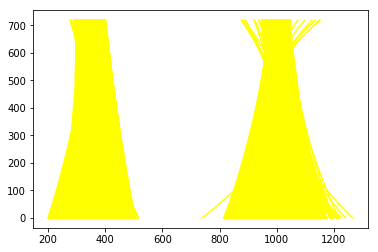

In [19]:
video_output = './output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(20,50)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))